# <font color="green"> Library Imports </font>

CRIAR A FEATURE 'season_of_year_N_E' e 'season_of_year_S_E' (estação da ano - hemisfério norte e sul)

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor

from boruta   import BorutaPy


from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
import xgboost                   as xgb
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import sgd_experimental

# <font color="green"> Helper functions </font>

In [2]:
def descriptive_statistics(df):
    
    df = df.select_dtypes(include=['int64', 'float64'])

    # Descriptive statistics

    df_descriptive = pd.DataFrame(data=[df.apply(np.min),
                                        df.apply(np.max),
                                        df.apply(lambda x: np.max(x) - np.min(x)),
                                        df.apply(np.mean),
                                        df.apply(np.median),
                                        df.apply(np.std),
                                        df.apply(lambda x: x.skew()),
                                        df.apply(lambda x: x.kurtosis())],
                                  index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']))
    
    return df_descriptive

<font color='red'><b>Estabelecendo as terminologias:</b></font>



<font><b>Gross revenue</b></font> -> receita bruta (https://bugg.com.br/buggpedia-o-que-e-a-receita-bruta-gross-revenue/). Equivalente ao faturamento (http://bitly.ws/rUMX).

<i>"Gross revenue, also known as gross income, is the sum of all money generated by a business, without taking into account any part of that total that has been or will be used for expenses. As such, gross revenue includes not just money made from the sale of goods and services but also from interest, sale of shares, exchange rates and sales of property and equipment."</i> (https://www.techtarget.com/whatis/definition/gross-revenue)

<b>net revenue</b> -> receita líquida .

<i>'the amount of money received from selling goods or services after all costs have been paid'</i> (https://dictionary.cambridge.org/pt/dicionario/ingles/net-revenue)

<b>ticket médio</b> -><i>"O ticket médio é um indicador de desempenho essencial que fornece o valor médio de vendas por cliente. Para calcular o ticket médio, basta dividir o faturamento total pelo número de vendas do período.Também é possível calcular o ticket médio de determinado produto, serviço ou categoria, conforme a necessidade da empresa."</i> (http://bitly.ws/rUMw)

<i>"Average ticket is a metric that provides details on the average amount of sales per customer. Statistically, the average ticket is computed as the mean size and is calculated by adding total sales over a specified period of time and dividing by the number of customers."</i>(http://bitly.ws/rUNW)

# 1.0 Data import and basic inspection

## <font color="gray"> 1.1 Data loading and checking </font>

In [3]:
# Data loading

df = pd.read_csv('data.csv')

df.head()

,Unnamed: 0,Unnamed: 0.1,customer_id,customer_acquisition_channel,year,net_revenue,gross_revenue,boxes,Unnamed: 7
0,0,206461;Paid Marketing;2014;W09;71;71;2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,462640;Paid Marketing;2015;W25;28;56;10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,666461;Referral;2015;W50;40;40;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,183202;Referral;2013;W42;18;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,410993;Referral;2014;W29;0;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))

print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 715875
Number of columns: 9


In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'customer_id',
       'customer_acquisition_channel', 'year', 'net_revenue', 'gross_revenue',
       'boxes', 'Unnamed: 7'],
      dtype='object')

In [6]:
# Droping first column

df = df[['Unnamed: 0.1', 'customer_id', 'customer_acquisition_channel',
         'year', 'net_revenue', 'gross_revenue', 'boxes', 'Unnamed: 7']]

In [7]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                     0
customer_id                     61
customer_acquisition_channel    61
year                            61
net_revenue                     61
gross_revenue                   61
boxes                           61
Unnamed: 7                      61
dtype: int64

In [8]:
# Filling NA's

for i in df[df['customer_id'].isna() & df['customer_acquisition_channel'].isna() & df['year'].isna()
          & df['net_revenue'].isna() & df['gross_revenue'].isna() & df['boxes'].isna() & df['Unnamed: 7'].isna()].index:
    
    
    df.loc[i, 'customer_id'] = df['Unnamed: 0.1'][i].split(';')[0]
    
    df.loc[i, 'customer_acquisition_channel'] = df['Unnamed: 0.1'][i].split(';')[1]
    
    df.loc[i, 'year'] = df['Unnamed: 0.1'][i].split(';')[2]
    
    df.loc[i, 'net_revenue'] = df['Unnamed: 0.1'][i].split(';')[3]
    
    df.loc[i, 'gross_revenue'] = df['Unnamed: 0.1'][i].split(';')[4]
    
    df.loc[i, 'boxes'] = df['Unnamed: 0.1'][i].split(';')[5]
    
    df.loc[i, 'Unnamed: 7'] = df['Unnamed: 0.1'][i].split(';')[6]



In [9]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                    0
customer_id                     0
customer_acquisition_channel    0
year                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
Unnamed: 7                      0
dtype: int64

In [10]:
# Droping 'Unnamed: 0.1' column

df = df.drop(columns=['Unnamed: 0.1'])

In [11]:
# checking data types

df.dtypes

customer_id                     object
customer_acquisition_channel    object
year                            object
net_revenue                     object
gross_revenue                   object
boxes                           object
Unnamed: 7                      object
dtype: object

In [12]:
# renaming columns 

df = df.rename(columns={'Unnamed: 7':'unknown'})

In [13]:
# Adjusting data types

df['customer_id'] = df['customer_id'].astype('int')

df['year'] = df['year'].astype('int')

df['gross_revenue'] = df['gross_revenue'].astype('int')

df['boxes'] = df['boxes'].astype('int')

De acordo com a definição do dicionário Cambridge 'net revenue' é definido como the 'amount of money received from selling goods or services after all costs have been paid', ou seja, a receita líquida, uma varável numérica. Dessa forma como a coluna 'net_revenue' do dataset apresenta um valor categórico e a coluna 'unknown' apresenta um valor numérico estou assumindo que essa atribuição esteja incorreta e farei os ajustes correspondentes no dataset.

In [14]:
df.columns = ['customer_id', 'customer_acquisition_channel', 'year', 'unknown',
              'gross_revenue', 'boxes', 'net_revenue']

In [15]:
# changing 'net_revenue' data type

df['net_revenue'] = df['net_revenue'].astype('int')

Da mesma forma uma vez que uma das colunas iniciais do dataset é anos e um dos exercícios propõe avaliar um modelo de previsão de vendas para os próximos 6 meses, a referida coluna possui valores no formado 'WX' onde X é um número qualquer. O valor máximo de W é 52 (a quantidade de semanas em 1 ano) e W se refere a 'week', portanto assumiremos essa variável como sendo a semana do ano.

In [16]:
print(df['unknown'].unique())


# creating 'week_of_year' columns
df['week_of_year'] = df['unknown'].apply(lambda x: x.split('W')[1])

# droping 'unknown' column
df = df.drop(columns=['unknown'])

# changing 'week_of_year' data type
df['week_of_year'] = df['week_of_year'].astype('int')

['W09' 'W25' 'W50' 'W42' 'W29' 'W11' 'W22' 'W52' 'W03' 'W20' 'W26' 'W27'
 'W07' 'W31' 'W45' 'W44' 'W19' 'W32' 'W10' 'W48' 'W46' 'W49' 'W35' 'W38'
 'W37' 'W04' 'W15' 'W51' 'W13' 'W41' 'W02' 'W18' 'W21' 'W47' 'W53' 'W08'
 'W39' 'W12' 'W01' 'W40' 'W36' 'W16' 'W14' 'W23' 'W43' 'W33' 'W30' 'W34'
 'W17' 'W06' 'W24' 'W28' 'W05']


In [17]:
df

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
0,206461,Paid Marketing,2014,71,71,2,9
1,462640,Paid Marketing,2015,28,56,10,25
2,666461,Referral,2015,40,40,1,50
3,183202,Referral,2013,18,37,1,42
4,410993,Referral,2014,0,37,1,29
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,0,40,1,51
715871,170503,Paid Marketing,2015,9,37,1,25
715872,169910,Referral,2015,37,37,1,4
715873,542301,Paid Marketing,2015,56,56,1,11


In [18]:
df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
gross_revenue                    int64
boxes                            int64
net_revenue                      int64
week_of_year                     int64
dtype: object

In [19]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   gross_revenue                 715875 non-null  int64 
 4   boxes                         715875 non-null  int64 
 5   net_revenue                   715875 non-null  int64 
 6   week_of_year                  715875 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 38.2+ MB


In [20]:
# Searching duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140874,283321,Paid Marketing,2014,37,37,1,31


In [21]:
# Showing duplicated rows

df[(df['customer_id']==283321) & (df['customer_acquisition_channel']=='Paid Marketing')
   & (df['year']==2014) & (df['week_of_year']==31) & (df['gross_revenue']==37) & (df['boxes']==37)
   & (df['net_revenue']==1.0)]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140872,283321,Paid Marketing,2014,37,37,1,31
140874,283321,Paid Marketing,2014,37,37,1,31


In [22]:
# Droping duplicated rows

df = df.drop_duplicates()

In [23]:
# Verifying duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year


## <font color="gray"> 1.2 Descriptive statistics </font>

### <i>1.2.1 descriptive statistics</i>

In [24]:
# Numerical and categorical attributes

num_attributes = df.select_dtypes(['int64','float64'])

cat_attributes = df.select_dtypes(exclude=['int64','float64'])

In [25]:
# Descriptive statistics

descriptive_statistics(num_attributes)

,customer_id,year,gross_revenue,boxes,net_revenue,week_of_year
min,103.000000,2013.000000,0.000000,14.000000,0.000000,1.000000
max,746721.000000,2015.000000,532.000000,532.000000,35.000000,53.000000
range,746618.000000,2.000000,532.000000,518.000000,35.000000,52.000000
mean,323665.946746,2014.196996,36.415566,41.430433,1.035540,27.492168
median,289530.000000,2014.000000,37.000000,37.000000,1.000000,28.000000
std,186133.109582,0.754551,13.645731,9.752438,0.235260,15.105273
skew,0.403604,-0.342471,0.526862,3.435149,41.392346,-0.061573
kurtosis,-1.048180,-1.179852,10.404687,36.808252,4480.780686,-1.238756


### <i>1.2.2 general view of attributes</i>

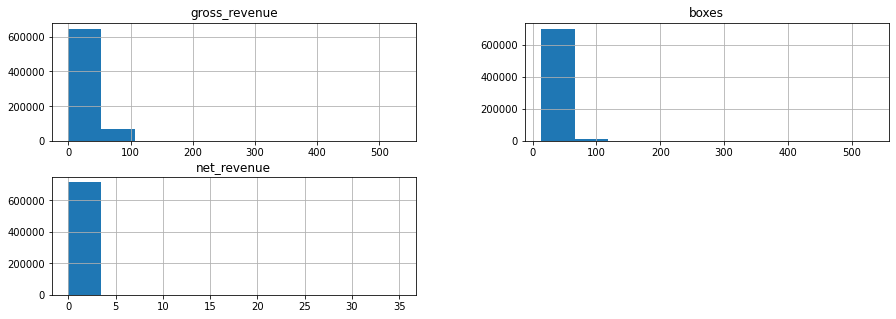

In [26]:
df[['gross_revenue','boxes','net_revenue']].hist(figsize=(15,5));

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="black"><b>Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

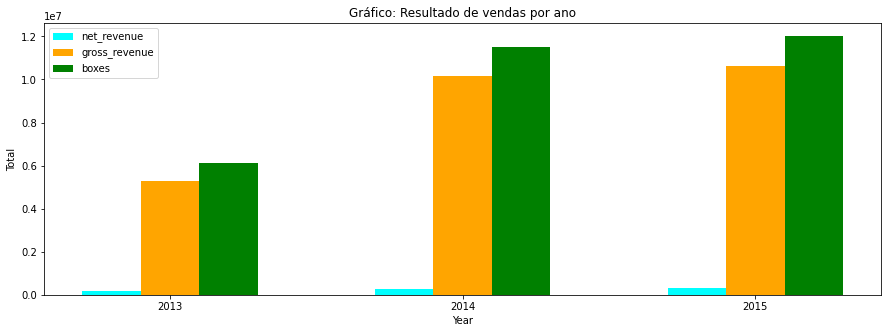

Tabela: Resultado de vendas por ano


,net_revenue,gross_revenue,boxes
year,,,
2013,156281,5295656,6134018
2014,292259,10162118,11505830
2015,292776,10611183,12019122


In [27]:
# data
x = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['year']
y2 = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['gross_revenue']
y1 = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['net_revenue']
y3 = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['boxes']
width = 0.2
 
plt.figure(figsize=(15,5))    
    
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['2013', '2014', '2015'])
plt.xlabel("Year")
plt.ylabel("Total")
plt.legend(["net_revenue", "gross_revenue", "boxes"])
plt.title('Gráfico: Resultado de vendas por ano')
plt.show()


# Tabela
print('Tabela: Resultado de vendas por ano')
df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum()

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="black"><b> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?

<b>R: Paid Marketing em 2013 e em 2015. Para isso seperaou-se o faturamento de cada customer_acquisition_channel e calculou-se a média para cada valor categórico dessa classe. Resposta abaixo</b></font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [28]:
# 2013

df.loc[df['year']==2013, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

,customer_acquisition_channel,gross_revenue
0,Paid Marketing,37.010380
1,Referral,31.170042


In [29]:
# 2015

df.loc[df['year']==2015, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

,customer_acquisition_channel,gross_revenue
0,Paid Marketing,38.059646
1,Referral,33.201835


https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="grey"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="black"><b>-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)

<b>R: Tabela e gráfico no snipet abaixo</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

Tabela:


,year,customer_id
0,2013,35849
1,2014,54864
2,2015,51643


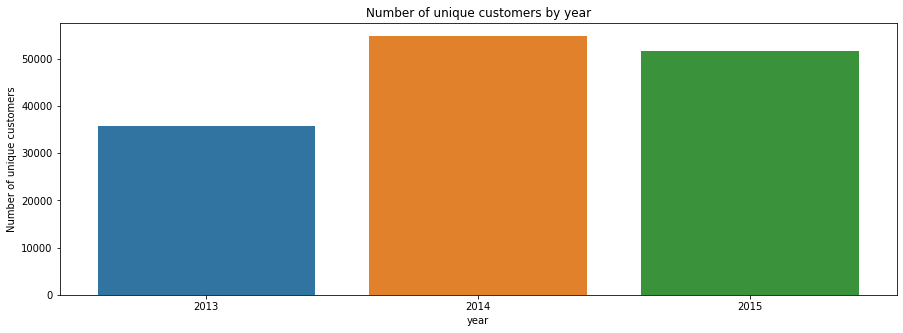

In [30]:
# Gráfico:
plt.figure(figsize=(15,5))
sns.barplot(x='year', y='customer_id', data=df[['customer_id','year']].groupby(['year']).nunique().reset_index())
plt.ylabel('Number of unique customers')
plt.title('Number of unique customers by year')
plt.plot()

# Tabela

# Grouping by year and counting uniques
print('Tabela:')
df[['customer_id','year']].groupby(['year']).nunique().reset_index()

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="black"><b>-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<b>R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<b>Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<b>Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</b></font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="black"><b>Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.
    
<b>Para resolver essa demanda todo o passo-a-passo para o desenvolvimento é descrito nas etapas 2.0 Feature engineering, 3.0 Data filtering, 4.0 Exploratory Data Analysis (EDA), 5.0 Data preparation e 6.0 Machine learning   
    
    
 </font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

# 2.0 Feature engineering

In [31]:
df_2 = df.copy()

## <font color="gray"> Semanas do ano </font>

https://www.epochconverter.com/pt/semanas/2015

<b>2013</b>




Janeiro -    semana 1 a 5    -> 1


Fevereiro -  semana 6 - 9    -> 2


Março -      semana 10 - 13  -> 3


Abril -      semana 14 - 18  -> 4


Maio -       semana 19 - 22  -> 5


Junho -      semana 23 - 26  -> 6


Julho -      semana 27 - 31  -> 7


Agosto -     semana 32 - 35  -> 8


Setembro -   semana 36 -40   -> 9


Outubro -    semana 41 - 44  -> 10


Novembro -   semana 45 - 48  -> 11


Dezembro -   semana 49 - 52  -> 12





<b>2014</b>



Janeiro -    semana 1 a 5    -> 1



Fevereiro -  semana 6 - 9    -> 2



Março -      semana 10 - 14  -> 3



 
Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 35  -> 8




Setembro -   semana 36 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 48  -> 11




Dezembro -   semana 49 - 52  -> 12



<b>2015</b>





Janeiro -    semana 1 a 5    -> 1




Fevereiro -  semana 6 - 9    -> 2




Março -      semana 10 - 14  -> 3 




Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 36  -> 8




Setembro -   semana 37 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 49  -> 11




Dezembro -   semana 50 - 53  -> 12

## <font color="gray"> 2.1 Creating new features </font>

In [32]:
# Creating 'semester_of_year' column

df_2['semester_of_year'] =  [1 if i <26 else 2 for i in df['week_of_year']]



# Creating 'month_of_year' column

df_2['month_of_year'] = np.nan


# Filling month of year

# 2013

df_2.loc[df_2['year']==2013, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=13
                                                  else 4 if 14<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=26
                                                  else 7 if 27<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2013, 'week_of_year'] ]


# 2014

df_2.loc[df_2['year']==2014, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2014, 'week_of_year'] ]


# 2015

df_2.loc[df_2['year']==2015, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=36
                                                  else 9 if 37<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=49
                                                  else 12 for i in df_2.loc[df_2['year']==2015, 'week_of_year'] ]


# changing 'month_of_year' data type

df_2['month_of_year'] = df_2['month_of_year'].astype('int')



# Creating 'quarter_of_the_year' column (trimestre)

df_2['quarter'] = [1 if i<= 3
                  else 2 if 4<=i<=6
                  else 3 if 7<=i<=9
                  else 4  for i in df_2['month_of_year']]




# Creating 'week_of_month' column

df_2['week_of_month'] = np.nan


# filling the column:


for i in tuple(df_2['year'].unique()):
    
    for it in tuple(df_2['month_of_year'].unique()):
    
        for count, value in tuple(enumerate(np.sort(df_2.loc[(df_2['month_of_year']==it) & (df_2['year']==i), 'week_of_year'].unique()).tolist())):

            df_2.loc[(df_2['month_of_year']==it) & (df_2['year']==i) & (df_2['week_of_year']==value), 'week_of_month'] = count+1
            


# changing 'week_of_month' data type

df_2['week_of_month'] = df_2['week_of_month'].astype('int')


In [33]:
df_2.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
gross_revenue                   0
boxes                           0
net_revenue                     0
week_of_year                    0
semester_of_year                0
month_of_year                   0
quarter                         0
week_of_month                   0
dtype: int64

# 3.0 Data filtering

In [34]:
df_3 = df_2.copy()

In [35]:
# Remover as linhas onde 'net_revenue'==0

df_3 = df_3[df_3['net_revenue']!=0]


# Organizar o dataset cronologicamente (importante para problemas de previsão)

df_3 = df_3.sort_values(by=['year','week_of_year'])



# Remover colunas que não estarão em produção ['customer_acquisition_channel', 'gross_revenue', 'boxes'] e
## agrupar o df mantendo a granulometria em cada semana do ano, somando o net_revenue para cada semana

df_grouped = df_3[['year',
                   'month_of_year',
                   'week_of_month',
                   'week_of_year',
                   'quarter',
                   'semester_of_year',
                   'net_revenue']].groupby(['year',
                                            'month_of_year',
                                            'week_of_month',
                                            'week_of_year',
                                            'quarter',
                                            'semester_of_year']).sum().reset_index()

É possível observar abaixo que a redução na granulometria diminuiu significativamente o tamanho do dataset. Isso pode trazer consequências nos resultados dos modelos a serem avaliados. Entretanto o pressuposto assumido neste momento é o de que essa ação é a que faria maior sentido já que não se sabe quais clientes farão compras futuras, não se sabe também quais serão 'customer_acquisition_channel' utilizados em compras futuras. Uma vez que o problema demanda previsão de 'net_revenue' então decideiu-se manter as variáveis que estarão presentes no futuro.

In [36]:
df_grouped

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,100
1,2013,1,2,3,1,1,526
2,2013,1,3,4,1,1,929
3,2013,1,4,5,1,1,1177
4,2013,2,1,6,1,1,1361
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,6792
152,2015,11,5,49,4,2,7320
153,2015,12,1,50,4,2,6988
154,2015,12,2,51,4,2,5492


# 4.0 Exploratory Data Analysis (EDA)

In [37]:
df_4 = df_3.copy()

## <font color="gray"> 4.1 Univariate analysis </font>

<AxesSubplot:>

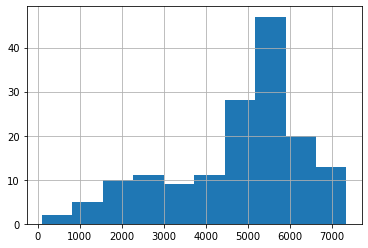

In [38]:
# Response variable

df_grouped['net_revenue'].hist()

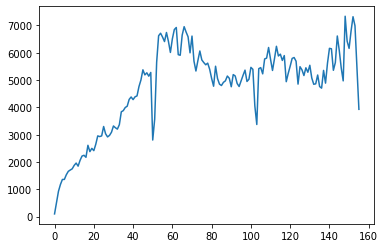

In [39]:
plt.plot(df_grouped['net_revenue'])

In [40]:
df_grouped

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,100
1,2013,1,2,3,1,1,526
2,2013,1,3,4,1,1,929
3,2013,1,4,5,1,1,1177
4,2013,2,1,6,1,1,1361
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,6792
152,2015,11,5,49,4,2,7320
153,2015,12,1,50,4,2,6988
154,2015,12,2,51,4,2,5492


### <i>4.1.1 numerical attributes</i>

### <i>4.1.2 categorical attributes</i>

### <i>4.2.1 validating hypothesis raised</i>

## <font color="gray"> 4.2 Multivariate analysis </font>

### <i>4.3.1 numerical attributes</i>

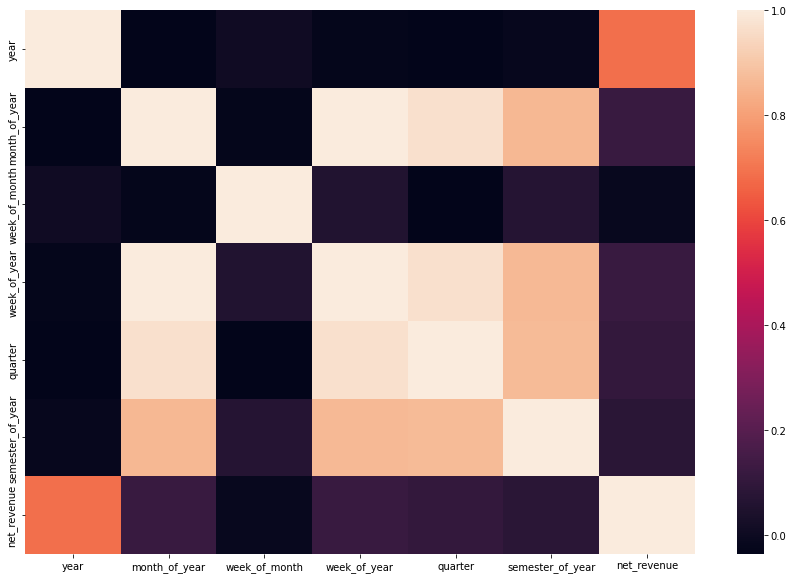

In [41]:
plt.figure(figsize=(15,10))

sns.heatmap(df_grouped.corr());

# 5.0 Data preparation

In [42]:
df_5 = df_grouped.copy()

## <font color="gray"> 5.1 Train/Test split </font>

A separação de treino e teste será feita respeitando a cronologia dos dados. Uma vez que eles já foram organizados na seção anterior então o split treino/teste será feito conforme o enunciado do problema demanda (6 meses futuros). Considerando que a granulometria dos dados ficou em semanas, dessa forma serão separados como conjunto teste as últimas 24 semanas.

In [43]:
df_5

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,100
1,2013,1,2,3,1,1,526
2,2013,1,3,4,1,1,929
3,2013,1,4,5,1,1,1177
4,2013,2,1,6,1,1,1361
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,6792
152,2015,11,5,49,4,2,7320
153,2015,12,1,50,4,2,6988
154,2015,12,2,51,4,2,5492


In [44]:
# Redefining os index

df_5.index = [i for i in range(0,len(df_5))]


# Uma vez que as variáveis de data já foi desmembrada em novas features, remover a coluna 'year'

df_5 = df_5.drop(columns=['year'])

In [45]:
# Train 

train, test = df_5.iloc[:-24,:], df_5.iloc[-24:,:]

# X
X_train, X_test = train.drop(columns=['net_revenue']), test.drop(columns=['net_revenue'])

# y 
y_train, y_test = train['net_revenue'].copy(), test['net_revenue'].copy()

In [46]:
# Saving X_test to csv

#X_test.to_csv('X_test.csv')

## <font color="gray"> 5.2 Scaling - numerical attributes </font>

As variáveis remanescentes são variáveis de natureza cíclica. Isso deve ser levado em consideração na hora de se fazer o scaling

In [47]:
# month_of_year

X_train['month_of_year_sin'] = X_train['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_train['month_of_year_cos'] = X_train['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


mms = MinMaxScaler()

X_train['month_of_year_sin'] = mms.fit_transform(X_train[['month_of_year_sin']].values)

mms = MinMaxScaler()

X_train['month_of_year_cos'] = mms.fit_transform(X_train[['month_of_year_cos']].values)




# week_of_month

X_train['week_of_month_sin'] = X_train['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['week_of_month_cos'] = X_train['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_train['week_of_month_sin'] = mms.fit_transform(X_train[['week_of_month_sin']].values)

mms = MinMaxScaler()

X_train['week_of_month_cos'] = mms.fit_transform(X_train[['week_of_month_cos']].values)




# week_of_year

X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))


mms = MinMaxScaler()

X_train['week_of_year_sin'] = mms.fit_transform(X_train[['week_of_year_sin']].values)

mms = MinMaxScaler()

X_train['week_of_year_cos'] = mms.fit_transform(X_train[['week_of_year_cos']].values)




# quarter

X_train['quarter_sin'] = X_train['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['quarter_cos'] = X_train['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_train['quarter_sin'] = mms.fit_transform(X_train[['quarter_sin']].values)

mms = MinMaxScaler()

X_train['quarter_cos'] = mms.fit_transform(X_train[['quarter_cos']].values)




# Mantendo apenas as colunas codificadas 

X_train = X_train[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]

A variável 'semester_of_year' será codificada usando dummies:

In [48]:
# 'semester_of_year' - dummies

X_train = pd.get_dummies(data=X_train, columns=['semester_of_year'], prefix=['semester_of_year'])

Fazendo o scaling dos dados de teste:

In [49]:
# month_of_year

X_test['month_of_year_sin'] = X_test['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_test['month_of_year_cos'] = X_test['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


mms = MinMaxScaler()

X_test['month_of_year_sin'] = mms.fit_transform(X_test[['month_of_year_sin']].values)

mms = MinMaxScaler()

X_test['month_of_year_cos'] = mms.fit_transform(X_test[['month_of_year_cos']].values)




# week_of_month

X_test['week_of_month_sin'] = X_test['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['week_of_month_cos'] = X_test['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_test['week_of_month_sin'] = mms.fit_transform(X_test[['week_of_month_sin']].values)

mms = MinMaxScaler()

X_test['week_of_month_cos'] = mms.fit_transform(X_test[['week_of_month_cos']].values)




# week_of_year

X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))


mms = MinMaxScaler()

X_test['week_of_year_sin'] = mms.fit_transform(X_test[['week_of_year_sin']].values)

mms = MinMaxScaler()

X_test['week_of_year_cos'] = mms.fit_transform(X_test[['week_of_year_cos']].values)




# quarter

X_test['quarter_sin'] = X_test['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['quarter_cos'] = X_test['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_test['quarter_sin'] = mms.fit_transform(X_test[['quarter_sin']].values)

mms = MinMaxScaler()

X_test['quarter_cos'] = mms.fit_transform(X_test[['quarter_cos']].values)




# Mantendo apenas as colunas codificadas 

X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]



# 'semester_of_year' - dummies

X_test = pd.get_dummies(data=X_test, columns=['semester_of_year'], prefix=['semester_of_year'])

O conjunto de teste não tem a variável 'semester_of_year_1' (porque o período se refere ao segundo semestre de 2015. Devemos adicionar a variável e atribuir o valor de 0 a ela no dado de teste.

In [50]:
# adicionando a coluna 'semester_of_year_1' ao conjunto teste

X_test['semester_of_year_1'] = 0


# reorganizando a ordem das colunas
X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin',
                 'week_of_month_cos', 'week_of_year_sin', 'week_of_year_cos',
                 'quarter_sin', 'quarter_cos', 'semester_of_year_1',
                 'semester_of_year_2']]

<AxesSubplot:xlabel='week_of_year_cos', ylabel='week_of_year_sin'>

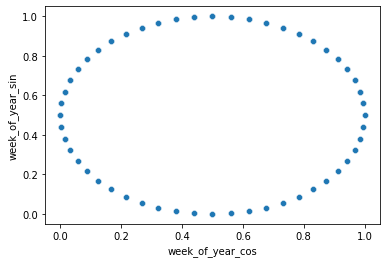

In [51]:
sns.scatterplot(x='week_of_year_cos', y='week_of_year_sin', data=X_train)

# 6.0 Machine learning

In [134]:
list_model_names = []
list_mae = []
list_mape = []
list_rmse = []
list_predictions = []

## <font color="gray"> 6.1 Baseline model </font>

In [135]:

# model definition
dummy_reg = DummyRegressor()

# model fit
dummy_reg.fit(X_train, y_train)

# predictions
y_pred = dummy_reg.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(dummy_reg))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(dummy_reg)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: DummyRegressor()

MAE: 1188.409722222222
MAPE: 0.1928806333457406
RMSE: 1434.9388416319557


## <font color="gray"> 6.2 Linear Regression </font>

In [136]:

# model definition
lr = LinearRegression()

# model fit
lr.fit(X_train, y_train)

# predictions
y_pred = lr.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(lr))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(lr)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: LinearRegression()

MAE: 1102.845197573453
MAPE: 0.18535787570673015
RMSE: 1268.075097449627


## <font color="gray"> 6.3 Lasso </font>

In [137]:

# model definition
lasso = Lasso()

# model fit
lasso.fit(X_train, y_train)

# predictions
y_pred = lasso.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(lasso))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(lasso)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: Lasso()

MAE: 1083.1874616274238
MAPE: 0.18098958573751087
RMSE: 1247.3075237144196


## <font color="gray"> 6.3 Elastic Net </font>

In [138]:

# model definition
elastic_net = ElasticNet()

# model fit
elastic_net.fit(X_train, y_train)

# predictions
y_pred = elastic_net.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(elastic_net))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(elastic_net)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: ElasticNet()

MAE: 1210.6764139179886
MAPE: 0.19786055302731523
RMSE: 1430.6342121404166


## <font color="gray"> 6.4 Random Forest </font>

In [139]:
# model definition
rf = RandomForestRegressor()

# model fit
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(rf))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Random Forest')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: RandomForestRegressor()

MAE: 1317.7524584986775
MAPE: 0.21688591286328618
RMSE: 1539.3766860415865


## <font color="gray"> 6.5 XGBoost </font>

In [140]:
# model definition
xg_boost = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9)

# model fit
xg_boost.fit(X_train, y_train)

# predictions
y_pred = xg_boost.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(xg_boost))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('XGBoost')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 1368.6994730631511
MAPE: 0.22917311763106155
RMSE: 1692.4266809347155


## <font color="gray"> 6.6 Neural Network - MLP</font>

In [141]:
# ========================= ANN com LOOCV ===================================================

# ========================= model training =======================================

in_dim = np.array(X_train).shape[1]
out_dim = np.array(y_train.to_frame()).shape[1]



   
# define model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(100, input_dim=in_dim, activation="relu"))
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(32, activation="relu"))
# Defining the Ouput layer
model.add(Dense(out_dim))
# Compiling the model
model.compile(loss="mse", optimizer="rmsprop")      

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

#predictions
y_pred = model.predict(X_test)
    

# ============================================================================================ 


# Metrics
print('Model metrics: {}\n'.format('Neural Network'))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Neural Network')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               1100      
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 913us/step - loss: 23492646.0000
Epoch 2/100
11/11 [==============================] - 0s 855us/step - loss: 23481312.0000
Epoch 3/100
11/11 [==============================] - 0s 868us/step - loss: 23466666.0000
Epoch 4/100
11/11 [==============================

11/11 [==============================] - 0s 756us/step - loss: 3395806.0000
Epoch 84/100
11/11 [==============================] - 0s 833us/step - loss: 3385388.2500
Epoch 85/100
11/11 [==============================] - 0s 788us/step - loss: 3372944.7500
Epoch 86/100
11/11 [==============================] - 0s 779us/step - loss: 3369664.7500
Epoch 87/100
11/11 [==============================] - 0s 772us/step - loss: 3358636.0000
Epoch 88/100
11/11 [==============================] - 0s 819us/step - loss: 3348990.0000
Epoch 89/100
11/11 [==============================] - 0s 744us/step - loss: 3344359.7500
Epoch 90/100
11/11 [==============================] - 0s 750us/step - loss: 3333564.7500
Epoch 91/100
11/11 [==============================] - 0s 775us/step - loss: 3326055.0000
Epoch 92/100
11/11 [==============================] - 0s 814us/step - loss: 3317251.0000
Epoch 93/100
11/11 [==============================] - 0s 799us/step - loss: 3308200.7500
Epoch 94/100
11/11 [==============

## <font color="gray"> 7.7 ARIMA </font>

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [142]:
# Dataframe para ARIMA

df_arima_train = pd.DataFrame(y_train)

df_arima_test = pd.DataFrame(y_test)

In [143]:
# Implementando ARIMA

decomposition =  seasonal_decompose(df_arima_train, period=62)

model = ARIMA(df_arima_train, order=(2,1,2))

results = model.fit()

In [144]:
## Ajuste arima

# results.fittedvalues


# Inserindo as predições no conjunto teste

df_arima_test['predictions'] = results.predict(start=132, end=155)

In [145]:
# Avaliando MAE, MAPE e RMSE do conjunto de teste para comparar com os algorítimos de machine learning



# MAE
print('MAE: {}'.format(mean_absolute_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(df_arima_test['net_revenue'].values,
                                                       df_arima_test['predictions'].values)))


# RMSE
print('RMSE: {}'.format(mean_squared_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values, squared=False)))


# storing metrics
list_model_names.append('ARIMA')
list_mae.append(mean_absolute_error(y_test, df_arima_test['predictions'].values))
list_mape.append(mean_absolute_percentage_error(y_test, df_arima_test['predictions'].values))
list_rmse.append(mean_squared_error(y_test, df_arima_test['predictions'].values, squared=False))

list_predictions.append(df_arima_test['predictions'].values)

MAE: 799.088910034829
MAPE: 0.13166795487607433
RMSE: 1021.7535534089687


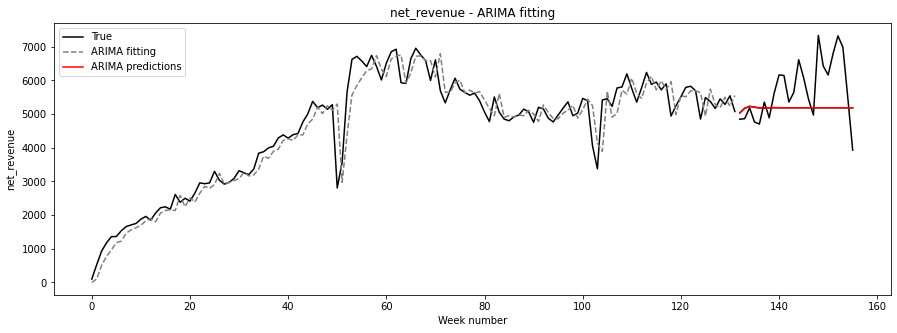

In [146]:
plt.figure(figsize=(15,5))


plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test, color='black')

plt.legend()

plt.plot(results.fittedvalues, color='gray', label='ARIMA fitting', linestyle="--")
plt.legend()


plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - ARIMA fitting');

## <font color="gray"> 7.8 Exponential Smoothing - HoltWinters </font>

In [147]:
# Dataframe para HW

df_hw_train = pd.DataFrame(y_train)

df_hw_test = pd.DataFrame(y_test)

In [148]:
model = ExponentialSmoothing(df_hw_train, seasonal_periods=26,trend='add', seasonal='add', initialization_method="estimated")

results = model.fit()

In [149]:
## Ajuste HW

results.fittedvalues


# Inserindo as predições no conjunto teste

df_hw_test['predictions'] = results.forecast(len(df_hw_test))

In [150]:
# Avaliando MAE, MAPE e RMSE do conjunto de teste para comparar com os algorítimos de machine learning



# MAE
print('MAE: {}'.format(mean_absolute_error(df_hw_test['net_revenue'].values,
                                           df_hw_test['predictions'].values)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(df_hw_test['net_revenue'].values,
                                                       df_hw_test['predictions'].values)))


# RMSE
print('RMSE: {}'.format(mean_squared_error(df_hw_test['net_revenue'].values,
                                           df_hw_test['predictions'].values, squared=False)))


# storing metrics
list_model_names.append('Exp. Smoothing')
list_mae.append(mean_absolute_error(y_test, df_hw_test['predictions'].values))
list_mape.append(mean_absolute_percentage_error(y_test, df_hw_test['predictions'].values))
list_rmse.append(mean_squared_error(y_test, df_hw_test['predictions'].values, squared=False))

list_predictions.append(df_hw_test['predictions'].values)

MAE: 909.8647865581116
MAPE: 0.1459890067151265
RMSE: 1163.9301050464428


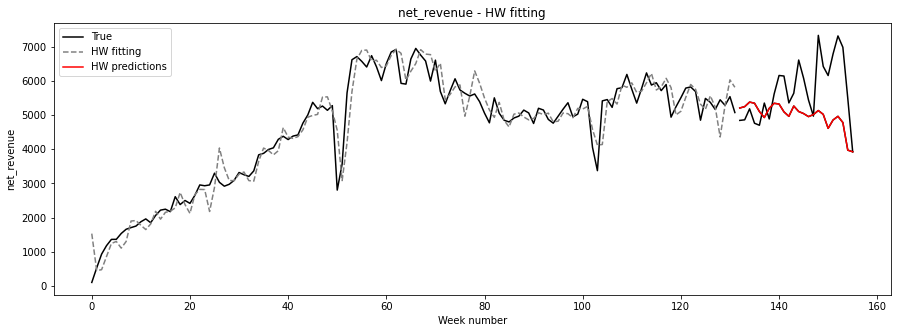

In [151]:
plt.figure(figsize=(15,5))


plt.plot(df_hw_train, color='black', label='True')
plt.plot(df_hw_test, color='black')

plt.legend()

plt.plot(results.fittedvalues, color='gray', label='HW fitting', linestyle="--")
plt.legend()


plt.plot(df_hw_test['predictions'], color='red', label='HW predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - HW fitting');

## <font color="gray"> Overall results </font>

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="black"><b>Qual modelo teve a melhor performance?
    
<font color="black"><b>R: Considerando a métrica MAE (e também MAPE e RMSE) a abordagem que retornou o menor erro no conjunto de teste foi o ARIMA (tabela abaixo).</b></font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [152]:
print('Resultado modelos:')

pd.DataFrame({'MAPE':list_mape, 'MAE':list_mae, 'RMSE':list_rmse}, index=list_model_names).sort_values(by=['MAE'])

Resultado modelos:


,MAPE,MAE,RMSE
ARIMA,0.131668,799.088910,1021.753553
Exp. Smoothing,0.145989,909.864787,1163.930105
Lasso(),0.180990,1083.187462,1247.307524
LinearRegression(),0.185358,1102.845198,1268.075097
DummyRegressor(),0.192881,1188.409722,1434.938842
ElasticNet(),0.197861,1210.676414,1430.634212
Random Forest,0.216886,1317.752458,1539.376686
XGBoost,0.229173,1368.699473,1692.426681
Neural Network,0.306037,1684.922099,1864.026316


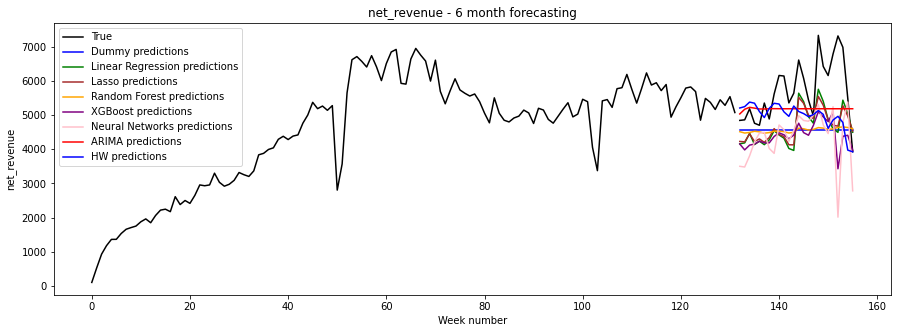

In [153]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()

# Dummy
plt.plot(pd.DataFrame(list_predictions[0], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='blue', label='Dummy predictions')

plt.legend()


# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()


# Lasso
plt.plot(pd.DataFrame(list_predictions[2], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Brown', label='Lasso predictions')

plt.legend()


# Random Forest
plt.plot(pd.DataFrame(list_predictions[3], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Orange', label='Random Forest predictions')

plt.legend()


# XGBoost
plt.plot(pd.DataFrame(list_predictions[4], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Purple', label='XGBoost predictions')

plt.legend()


# Neural Networks
plt.plot(pd.DataFrame(list_predictions[5], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Pink', label='Neural Networks predictions')

plt.legend()


# ARIMA
plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()


# Exp Smooth
plt.plot(df_hw_test['predictions'], color='blue', label='HW predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

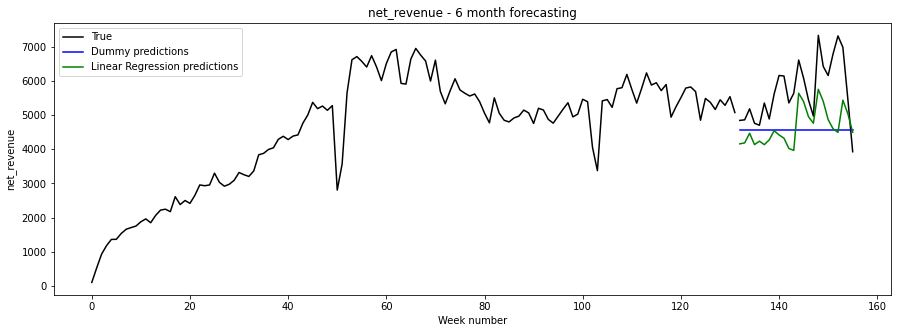

In [154]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()

# Dummy
plt.plot(pd.DataFrame(list_predictions[0], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='blue', label='Dummy predictions')

plt.legend()


# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()




plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

In [ ]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()




# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()


# Lasso
plt.plot(pd.DataFrame(list_predictions[2], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Brown', label='Lasso predictions')

plt.legend()


# Random Forest
plt.plot(pd.DataFrame(list_predictions[3], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Orange', label='Random Forest predictions')

plt.legend()


# Exp Smooth
plt.plot(df_hw_test['predictions'], color='blue', label='HW predictions')

plt.legend()

# Neural Networks
plt.plot(pd.DataFrame(list_predictions[5], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Pink', label='Neural Networks predictions')




plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="grey">Qual modelo teve a melhor performance?

- <font color="grey">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="black"><b>Como realizou treino e teste?</b></font>
    
<font color="black"><b>R: Conforme mencionado anteriormente, por se tratar de um problema de previsão no tempo é importante considerar essa informação na resolução do problema na parte da separação dos respectivos conjuntos de treino e teste. Ambos os conjuntos precisam estar organizados temporalmente onde o conjunto teste deve corresponder ao período futuro em relação ao conjunto de treino. Uma vez que a granulometria usada para resolver o problema estava em semanas e a demanda de previsão era para 6 meses então separou-se as últimas 24 semanas para ser o conjunto teste.</b></font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

## <font color="orange"> Evaluating data slices </font>

Ao observar o plot abaixo de net_revenue em função das semanas é possível observar que o comportamento de net_revenue antes de 60 semanas é diferente do comportamento após 60 semanas. Enquanto que no primeiro caso é possível observar um comportament de crescimento em função do tempo, no segundo caso esse comportamento é diferente. Dessa forma esses diferentes perfis de comportamento podem, de alguma forma, estar comprometendo a eficiência do algoritmo na previsão de vendas para 6 meses.


Uma vez que o enunciado do problema demanda a previsão de vendas para 6 meses (24 semanas) e que não foi mencionado sobre critérios de utilização dos dados no treinamento dos algoritmos, decidiu-se então adotar a seguinte estratégia:

- O conjunto de teste foi mantido para as últimas 24 semanas do dataset conforme as demais avaliações.
- Foram avaliados diferentes conjuntos de treinamento relizando-se diferentes slices no conjunto de treinamento, variando a data mais antiga do dado de treinamento (início do slicing) e mantendo a data mais recente (mais próxima da primeira data do conjunto de teste, término do slicing).
- As métricas do modelo foram coletadas para cada diferente slicing aplicado aos dados para então se obter um ponto de corte ideal que maximiza do desempenho do modelo.
- A estratégia foi repetida para os demais modelos de machine learning avaliados anteriormente

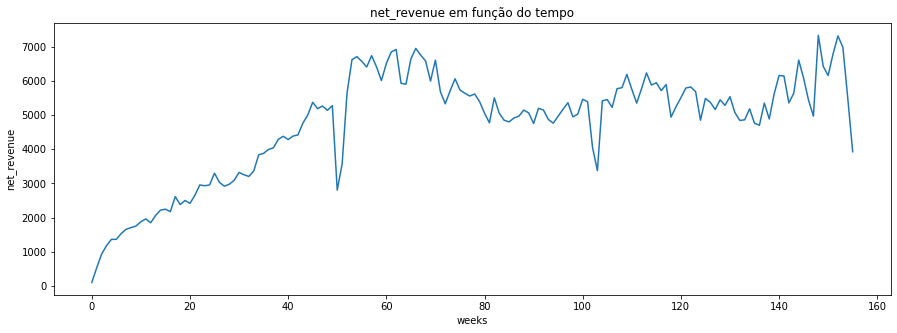

In [205]:
plt.figure(figsize=(15,5))
plt.plot(df_grouped['net_revenue']);
plt.xlabel('weeks')
plt.ylabel('net_revenue')
plt.title('net_revenue em função do tempo');

In [186]:
# Lists to store metrics for optimed slicing

list_best_mae = []
list_best_mape = []
list_best_rmse = []
list_best_slicing_index = []

list_model_names = []

### <font color="orange"> Linear Regression </font>

In [187]:
# Linear Regression - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = LinearRegression()
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format(model))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append(lr)
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: LinearRegression()

MAE: 1102.845197573453
MAPE: 0.18535787570673015
RMSE: 1268.075097449627

Initial slicing index evaluated: 1

Model metrics: LinearRegression()

MAE: 1063.8138857905267
MAPE: 0.17856558662937835
RMSE: 1238.0500066128548

Initial slicing index evaluated: 2

Model metrics: LinearRegression()

MAE: 971.4908377794467
MAPE: 0.16259375202315623
RMSE: 1157.5136959278805

Initial slicing index evaluated: 3

Model metrics: LinearRegression()

MAE: 890.2798707689418
MAPE: 0.1483192949568589
RMSE: 1081.5450184351446

Initial slicing index evaluated: 4

Model metrics: LinearRegression()

MAE: 835.2445565080212
MAPE: 0.13913039159661314
RMSE: 1015.9105704346327

Initial slicing index evaluated: 5

Model metrics: LinearRegression()

MAE: 840.8534332552799
MAPE: 0.14088103271014604
RMSE: 1013.7995163774493

Initial slicing index evaluated: 6

Model metrics: LinearRegression()

MAE: 803.1599268569344
MAPE: 0.1353414722260057
RMSE:


Initial slicing index evaluated: 63

Model metrics: LinearRegression()

MAE: 829.6690219296161
MAPE: 0.13661846700850355
RMSE: 1030.0105361704523

Initial slicing index evaluated: 64

Model metrics: LinearRegression()

MAE: 833.218418949244
MAPE: 0.13712202271249563
RMSE: 1032.0457787986188

Initial slicing index evaluated: 65

Model metrics: LinearRegression()

MAE: 834.0100231223718
MAPE: 0.13723805737520073
RMSE: 1032.5027045041431

Initial slicing index evaluated: 66

Model metrics: LinearRegression()

MAE: 840.4361031680429
MAPE: 0.13802913995115126
RMSE: 1041.9161532945843

Initial slicing index evaluated: 67

Model metrics: LinearRegression()

MAE: 805.6312521879667
MAPE: 0.13172511746096116
RMSE: 1016.1590723774339

Initial slicing index evaluated: 68

Model metrics: LinearRegression()

MAE: 778.6263734342041
MAPE: 0.1264510967677908
RMSE: 1001.0812183142492

Initial slicing index evaluated: 69

Model metrics: LinearRegression()

MAE: 765.717558245566
MAPE: 0.12444781827718492

### <font color="orange"> Elastic Net </font>

In [189]:
# Elastic net - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = ElasticNet()
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format(model))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append(model)
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: ElasticNet()

MAE: 1210.6764139179886
MAPE: 0.19786055302731523
RMSE: 1430.6342121404166

Initial slicing index evaluated: 1

Model metrics: ElasticNet()

MAE: 1192.3133066850726
MAPE: 0.19519944141972304
RMSE: 1404.1617560494362

Initial slicing index evaluated: 2

Model metrics: ElasticNet()

MAE: 1175.1179531804016
MAPE: 0.19268225539827366
RMSE: 1381.3921546716008

Initial slicing index evaluated: 3

Model metrics: ElasticNet()

MAE: 1160.7341068682158
MAPE: 0.19057573440845568
RMSE: 1363.7957962687478

Initial slicing index evaluated: 4

Model metrics: ElasticNet()

MAE: 1147.4185907602607
MAPE: 0.18866986048764423
RMSE: 1345.9006806607108

Initial slicing index evaluated: 5

Model metrics: ElasticNet()

MAE: 1134.7932853285272
MAPE: 0.1869145208911407
RMSE: 1327.490602793663

Initial slicing index evaluated: 6

Model metrics: ElasticNet()

MAE: 1121.7480375095122
MAPE: 0.18506981890970042
RMSE: 1310.6007823440184

Initial slicin


Initial slicing index evaluated: 59

Model metrics: ElasticNet()

MAE: 787.2629227475112
MAPE: 0.13219655320091359
RMSE: 975.8875749715183

Initial slicing index evaluated: 60

Model metrics: ElasticNet()

MAE: 789.4711654879453
MAPE: 0.13249392858589987
RMSE: 978.1647415627855

Initial slicing index evaluated: 61

Model metrics: ElasticNet()

MAE: 793.8852152415662
MAPE: 0.1330724896115851
RMSE: 984.1139135731156

Initial slicing index evaluated: 62

Model metrics: ElasticNet()

MAE: 799.9429638900598
MAPE: 0.13387099345634246
RMSE: 993.1071512879602

Initial slicing index evaluated: 63

Model metrics: ElasticNet()

MAE: 806.9557806956932
MAPE: 0.1348041146149143
RMSE: 1001.7026588192481

Initial slicing index evaluated: 64

Model metrics: ElasticNet()

MAE: 808.6605853239615
MAPE: 0.13501768563049624
RMSE: 1003.6943333391404

Initial slicing index evaluated: 65

Model metrics: ElasticNet()

MAE: 810.0566350230174
MAPE: 0.1351874678644864
RMSE: 1005.7603967032738

Initial slicing ind

### <font color="orange"> Random Forest </font>

In [190]:
# Random Forest - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = RandomForestRegressor()
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format('Random Forest'))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append('Random Forest')
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: RandomForestRegressor()

MAE: 1358.283259424603
MAPE: 0.2229580133286965
RMSE: 1589.7423626334169

Initial slicing index evaluated: 1

Model metrics: RandomForestRegressor()

MAE: 1226.1030912698411
MAPE: 0.2067016567626112
RMSE: 1328.0415280100692

Initial slicing index evaluated: 2

Model metrics: RandomForestRegressor()

MAE: 1165.452047123016
MAPE: 0.19425064022037328
RMSE: 1289.9214459406521

Initial slicing index evaluated: 3

Model metrics: RandomForestRegressor()

MAE: 1097.9434206349204
MAPE: 0.18507458883947972
RMSE: 1203.3155352928825

Initial slicing index evaluated: 4

Model metrics: RandomForestRegressor()

MAE: 1070.3460801917988
MAPE: 0.1787609878776976
RMSE: 1204.8592116633395

Initial slicing index evaluated: 5

Model metrics: RandomForestRegressor()

MAE: 1053.6609126984129
MAPE: 0.1777839596928222
RMSE: 1172.9979388775748

Initial slicing index evaluated: 6

Model metrics: RandomForestRegressor()

MAE: 992.35250694


Initial slicing index evaluated: 57

Model metrics: RandomForestRegressor()

MAE: 866.0698472222224
MAPE: 0.14685156831919824
RMSE: 1034.2850287447422

Initial slicing index evaluated: 58

Model metrics: RandomForestRegressor()

MAE: 857.8283720238093
MAPE: 0.14523958063348366
RMSE: 1025.6380320865412

Initial slicing index evaluated: 59

Model metrics: RandomForestRegressor()

MAE: 850.382693452381
MAPE: 0.1442382890003573
RMSE: 1017.2977430152165

Initial slicing index evaluated: 60

Model metrics: RandomForestRegressor()

MAE: 842.4945456349205
MAPE: 0.14266084150125768
RMSE: 1012.5757667525423

Initial slicing index evaluated: 61

Model metrics: RandomForestRegressor()

MAE: 836.2708015873017
MAPE: 0.140440348764646
RMSE: 1010.0262669131026

Initial slicing index evaluated: 62

Model metrics: RandomForestRegressor()

MAE: 830.348215277778
MAPE: 0.13973030219751734
RMSE: 1000.7561643868169

Initial slicing index evaluated: 63

Model metrics: RandomForestRegressor()

MAE: 832.889381


Initial slicing index evaluated: 114

Model metrics: RandomForestRegressor()

MAE: 706.1454166666667
MAPE: 0.12224284281900155
RMSE: 886.02376344872

Initial slicing index evaluated: 115

Model metrics: RandomForestRegressor()

MAE: 678.8116666666668
MAPE: 0.11784971406923468
RMSE: 856.2765019110359

Initial slicing index evaluated: 116

Model metrics: RandomForestRegressor()

MAE: 704.9250000000001
MAPE: 0.12038577203611389
RMSE: 899.360640927765

Initial slicing index evaluated: 117

Model metrics: RandomForestRegressor()

MAE: 742.0225
MAPE: 0.1255380215080047
RMSE: 935.1762313819072

Initial slicing index evaluated: 118

Model metrics: RandomForestRegressor()

MAE: 779.5708333333333
MAPE: 0.12967829801200617
RMSE: 984.566275473622

Initial slicing index evaluated: 119

Model metrics: RandomForestRegressor()

MAE: 746.0287500000001
MAPE: 0.12579937005856032
RMSE: 940.1917466909787

Initial slicing index evaluated: 120

Model metrics: RandomForestRegressor()

MAE: 715.1891666666666


### <font color="orange"> XGBoost </font>

In [191]:
# XGBoost - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9)
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format('XGBoost'))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append('XGBoost')
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 1368.6994730631511
MAPE: 0.22917311763106155
RMSE: 1692.4266809347155

Initial slicing index evaluated: 1

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 1038.2974039713542
MAPE: 0.17336641309054968
RMSE: 1195.6515088627052

Initial slicing index evaluated: 2

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 1059.9427795410156
MAPE: 0.17732212624404498
RMSE: 1190.1323246795066

Initial slicing index evaluated: 3

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 1296.0574239095051
MAPE: 0.22076857738468303
RMSE: 1403.7419178131702

Initial slicing ind

RMSE: 1008.4192379513689

Initial slicing index evaluated: 39

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 853.3505554199219
MAPE: 0.13646239351608877
RMSE: 1096.7486986246433

Initial slicing index evaluated: 40

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 729.3191935221354
MAPE: 0.11807562298945473
RMSE: 910.4828910431102

Initial slicing index evaluated: 41

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 796.81591796875
MAPE: 0.12717166270547256
RMSE: 1023.2572777845339

Initial slicing index evaluated: 42

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 810.3892822265625
MAPE: 0.12967349966718908
RMSE: 1057.831826463363


Initial slicing index evaluated: 74

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 704.693369547526
MAPE: 0.11600483987649284
RMSE: 819.0857839751683

Initial slicing index evaluated: 75

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 744.361826578776
MAPE: 0.12207568607227526
RMSE: 881.2057387613071

Initial slicing index evaluated: 76

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 711.5486450195312
MAPE: 0.11531453696174561
RMSE: 860.381737724963

Initial slicing index evaluated: 77

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 690.6808369954427
MAPE: 0.11238102629649517
RMSE: 822.4944622744257

Initial slicing index eval

### <font color="orange"> Neural Networks MLP </font>

In [192]:
# MLP Neural Networks - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    in_dim = np.array(X_train).shape[1]
    out_dim = np.array(y_train.to_frame()).shape[1]
    
    
    
       
    # define model
    model = Sequential()
    
    # Defining the Input layer and FIRST hidden layer, both are same!
    model.add(Dense(100, input_dim=in_dim, activation="relu"))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(32, activation="relu"))
    # Defining the Ouput layer
    model.add(Dense(out_dim))
    # Compiling the model
    model.compile(loss="mse", optimizer="rmsprop")      
    
    model.summary()
    
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]], epochs=100, batch_size=12, verbose=1)
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format('MLP'))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append('MLP')
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))

Model: "sequential_246"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_738 (Dense)           (None, 100)               1100      
                                                                 
 dense_739 (Dense)           (None, 32)                3232      
                                                                 
 dense_740 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 869us/step - loss: 23492878.0000
Epoch 2/100
11/11 [==============================] - 0s 823us/step - loss: 23479772.0000
Epoch 3/100
11/11 [==============================] - 0s 920us/step - loss: 23462994.0000
Epoch 4/100
11/11 [============================

11/11 [==============================] - 0s 886us/step - loss: 3338791.5000
Epoch 84/100
11/11 [==============================] - 0s 793us/step - loss: 3330982.2500
Epoch 85/100
11/11 [==============================] - 0s 782us/step - loss: 3331414.2500
Epoch 86/100
11/11 [==============================] - 0s 862us/step - loss: 3311743.5000
Epoch 87/100
11/11 [==============================] - 0s 781us/step - loss: 3307961.0000
Epoch 88/100
11/11 [==============================] - 0s 753us/step - loss: 3299503.0000
Epoch 89/100
11/11 [==============================] - 0s 792us/step - loss: 3290140.7500
Epoch 90/100
11/11 [==============================] - 0s 718us/step - loss: 3283393.0000
Epoch 91/100
11/11 [==============================] - 0s 706us/step - loss: 3275599.5000
Epoch 92/100
11/11 [==============================] - 0s 755us/step - loss: 3271392.5000
Epoch 93/100
11/11 [==============================] - 0s 693us/step - loss: 3263135.5000
Epoch 94/100
11/11 [==============

11/11 [==============================] - 0s 783us/step - loss: 3873642.7500
Epoch 64/100
11/11 [==============================] - 0s 938us/step - loss: 3701743.7500
Epoch 65/100
11/11 [==============================] - 0s 799us/step - loss: 3559706.2500
Epoch 66/100
11/11 [==============================] - 0s 794us/step - loss: 3452780.0000
Epoch 67/100
11/11 [==============================] - 0s 852us/step - loss: 3377507.7500
Epoch 68/100
11/11 [==============================] - 0s 760us/step - loss: 3319406.0000
Epoch 69/100
11/11 [==============================] - 0s 771us/step - loss: 3284173.7500
Epoch 70/100
11/11 [==============================] - 0s 908us/step - loss: 3262761.5000
Epoch 71/100
11/11 [==============================] - 0s 803us/step - loss: 3237294.0000
Epoch 72/100
11/11 [==============================] - 0s 776us/step - loss: 3225304.5000
Epoch 73/100
11/11 [==============================] - 0s 801us/step - loss: 3214210.0000
Epoch 74/100
11/11 [==============

11/11 [==============================] - 0s 913us/step - loss: 10921559.0000
Epoch 44/100
11/11 [==============================] - 0s 809us/step - loss: 10350682.0000
Epoch 45/100
11/11 [==============================] - 0s 774us/step - loss: 9792683.0000
Epoch 46/100
11/11 [==============================] - 0s 837us/step - loss: 9228787.0000
Epoch 47/100
11/11 [==============================] - 0s 772us/step - loss: 8680931.0000
Epoch 48/100
11/11 [==============================] - 0s 773us/step - loss: 8150672.0000
Epoch 49/100
11/11 [==============================] - 0s 915us/step - loss: 7623509.5000
Epoch 50/100
11/11 [==============================] - 0s 781us/step - loss: 7113203.5000
Epoch 51/100
11/11 [==============================] - 0s 802us/step - loss: 6617419.0000
Epoch 52/100
11/11 [==============================] - 0s 853us/step - loss: 6153899.0000
Epoch 53/100
11/11 [==============================] - 0s 796us/step - loss: 5731832.5000
Epoch 54/100
11/11 [============

11/11 [==============================] - 0s 838us/step - loss: 20990166.0000
Epoch 24/100
11/11 [==============================] - 0s 849us/step - loss: 20679954.0000
Epoch 25/100
11/11 [==============================] - 0s 833us/step - loss: 20351602.0000
Epoch 26/100
11/11 [==============================] - 0s 825us/step - loss: 20011590.0000
Epoch 27/100
11/11 [==============================] - 0s 843us/step - loss: 19655534.0000
Epoch 28/100
11/11 [==============================] - 0s 802us/step - loss: 19281528.0000
Epoch 29/100
11/11 [==============================] - 0s 857us/step - loss: 18884762.0000
Epoch 30/100
11/11 [==============================] - 0s 805us/step - loss: 18475006.0000
Epoch 31/100
11/11 [==============================] - 0s 795us/step - loss: 18044968.0000
Epoch 32/100
11/11 [==============================] - 0s 939us/step - loss: 17608576.0000
Epoch 33/100
11/11 [==============================] - 0s 836us/step - loss: 17152632.0000
Epoch 34/100
11/11 [===

11/11 [==============================] - 0s 927us/step - loss: 24175016.0000
Epoch 4/100
11/11 [==============================] - 0s 952us/step - loss: 24154826.0000
Epoch 5/100
11/11 [==============================] - 0s 934us/step - loss: 24129152.0000
Epoch 6/100
11/11 [==============================] - 0s 932us/step - loss: 24097636.0000
Epoch 7/100
11/11 [==============================] - 0s 935us/step - loss: 24060414.0000
Epoch 8/100
11/11 [==============================] - 0s 893us/step - loss: 24014360.0000
Epoch 9/100
11/11 [==============================] - 0s 783us/step - loss: 23960974.0000
Epoch 10/100
11/11 [==============================] - 0s 849us/step - loss: 23899832.0000
Epoch 11/100
11/11 [==============================] - 0s 811us/step - loss: 23832012.0000
Epoch 12/100
11/11 [==============================] - 0s 778us/step - loss: 23756200.0000
Epoch 13/100
11/11 [==============================] - 0s 826us/step - loss: 23671274.0000
Epoch 14/100
11/11 [=========

11/11 [==============================] - 0s 930us/step - loss: 2730667.2500
Epoch 95/100
11/11 [==============================] - 0s 767us/step - loss: 2725121.5000
Epoch 96/100
11/11 [==============================] - 0s 728us/step - loss: 2715588.5000
Epoch 97/100
11/11 [==============================] - 0s 828us/step - loss: 2712863.0000
Epoch 98/100
11/11 [==============================] - 0s 815us/step - loss: 2703578.5000
Epoch 99/100
11/11 [==============================] - 0s 754us/step - loss: 2699823.2500
Epoch 100/100
11/11 [==============================] - 0s 869us/step - loss: 2695226.7500

Initial slicing index evaluated: 4

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f74186160>

MAE: 1635.9505513509114
MAPE: 0.300040042566718
RMSE: 1830.2970405130695
Model: "sequential_251"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_753 (Dense)           (None, 100)     

11/11 [==============================] - 0s 780us/step - loss: 2589367.5000
Epoch 75/100
11/11 [==============================] - 0s 795us/step - loss: 2581902.0000
Epoch 76/100
11/11 [==============================] - 0s 758us/step - loss: 2576449.2500
Epoch 77/100
11/11 [==============================] - 0s 829us/step - loss: 2567310.7500
Epoch 78/100
11/11 [==============================] - 0s 738us/step - loss: 2562335.0000
Epoch 79/100
11/11 [==============================] - 0s 759us/step - loss: 2558268.0000
Epoch 80/100
11/11 [==============================] - 0s 835us/step - loss: 2551405.2500
Epoch 81/100
11/11 [==============================] - 0s 805us/step - loss: 2547207.2500
Epoch 82/100
11/11 [==============================] - 0s 776us/step - loss: 2538773.2500
Epoch 83/100
11/11 [==============================] - 0s 894us/step - loss: 2544452.2500
Epoch 84/100
11/11 [==============================] - 0s 838us/step - loss: 2532108.7500
Epoch 85/100
11/11 [==============

11/11 [==============================] - 0s 813us/step - loss: 9081981.0000
Epoch 55/100
11/11 [==============================] - 0s 857us/step - loss: 8565730.0000
Epoch 56/100
11/11 [==============================] - 0s 807us/step - loss: 8074778.0000
Epoch 57/100
11/11 [==============================] - 0s 777us/step - loss: 7592486.5000
Epoch 58/100
11/11 [==============================] - 0s 769us/step - loss: 7094240.0000
Epoch 59/100
11/11 [==============================] - 0s 844us/step - loss: 6623354.5000
Epoch 60/100
11/11 [==============================] - 0s 780us/step - loss: 6177538.0000
Epoch 61/100
11/11 [==============================] - 0s 783us/step - loss: 5757426.5000
Epoch 62/100
11/11 [==============================] - 0s 848us/step - loss: 5338913.0000
Epoch 63/100
11/11 [==============================] - 0s 789us/step - loss: 4941024.0000
Epoch 64/100
11/11 [==============================] - 0s 886us/step - loss: 4585915.0000
Epoch 65/100
11/11 [==============

11/11 [==============================] - 0s 857us/step - loss: 18044602.0000
Epoch 35/100
11/11 [==============================] - 0s 804us/step - loss: 17593368.0000
Epoch 36/100
11/11 [==============================] - 0s 790us/step - loss: 17126092.0000
Epoch 37/100
11/11 [==============================] - 0s 791us/step - loss: 16652837.0000
Epoch 38/100
11/11 [==============================] - 0s 758us/step - loss: 16160298.0000
Epoch 39/100
11/11 [==============================] - 0s 782us/step - loss: 15656473.0000
Epoch 40/100
11/11 [==============================] - 0s 743us/step - loss: 15159163.0000
Epoch 41/100
11/11 [==============================] - 0s 830us/step - loss: 14630256.0000
Epoch 42/100
11/11 [==============================] - 0s 786us/step - loss: 14098312.0000
Epoch 43/100
11/11 [==============================] - 0s 755us/step - loss: 13560921.0000
Epoch 44/100
11/11 [==============================] - 0s 828us/step - loss: 13024239.0000
Epoch 45/100
11/11 [===

11/11 [==============================] - 0s 857us/step - loss: 24156294.0000
Epoch 15/100
11/11 [==============================] - 0s 754us/step - loss: 24032766.0000
Epoch 16/100
11/11 [==============================] - 0s 759us/step - loss: 23897880.0000
Epoch 17/100
11/11 [==============================] - 0s 819us/step - loss: 23750164.0000
Epoch 18/100
11/11 [==============================] - 0s 792us/step - loss: 23592974.0000
Epoch 19/100
11/11 [==============================] - 0s 751us/step - loss: 23422262.0000
Epoch 20/100
11/11 [==============================] - 0s 840us/step - loss: 23239500.0000
Epoch 21/100
11/11 [==============================] - 0s 738us/step - loss: 23041770.0000
Epoch 22/100
11/11 [==============================] - 0s 819us/step - loss: 22832694.0000
Epoch 23/100
11/11 [==============================] - 0s 734us/step - loss: 22615062.0000
Epoch 24/100
11/11 [==============================] - 0s 731us/step - loss: 22377322.0000
Epoch 25/100
11/11 [===

                                                                 
 dense_766 (Dense)           (None, 32)                3232      
                                                                 
 dense_767 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 921us/step - loss: 25090910.0000
Epoch 2/100
11/11 [==============================] - 0s 910us/step - loss: 25074472.0000
Epoch 3/100
11/11 [==============================] - 0s 859us/step - loss: 25054810.0000
Epoch 4/100
11/11 [==============================] - 0s 837us/step - loss: 25028570.0000
Epoch 5/100
11/11 [==============================] - 0s 833us/step - loss: 24995906.0000
Epoch 6/100
11/11 [==============================] - 0s 873us/step - loss: 24954570.0000
Ep

11/11 [==============================] - 0s 817us/step - loss: 2063708.8750
Epoch 87/100
11/11 [==============================] - 0s 857us/step - loss: 2057310.2500
Epoch 88/100
11/11 [==============================] - 0s 802us/step - loss: 2054238.1250
Epoch 89/100
11/11 [==============================] - 0s 828us/step - loss: 2052942.6250
Epoch 90/100
11/11 [==============================] - 0s 792us/step - loss: 2041069.3750
Epoch 91/100
11/11 [==============================] - 0s 801us/step - loss: 2038411.5000
Epoch 92/100
11/11 [==============================] - 0s 796us/step - loss: 2040114.0000
Epoch 93/100
11/11 [==============================] - 0s 800us/step - loss: 2029393.7500
Epoch 94/100
11/11 [==============================] - 0s 771us/step - loss: 2024089.6250
Epoch 95/100
11/11 [==============================] - 0s 773us/step - loss: 2023466.1250
Epoch 96/100
11/11 [==============================] - 0s 851us/step - loss: 2019219.1250
Epoch 97/100
11/11 [==============

11/11 [==============================] - 0s 867us/step - loss: 2435518.2500
Epoch 67/100
11/11 [==============================] - 0s 819us/step - loss: 2288236.2500
Epoch 68/100
11/11 [==============================] - 0s 801us/step - loss: 2189821.0000
Epoch 69/100
11/11 [==============================] - 0s 785us/step - loss: 2133170.5000
Epoch 70/100
11/11 [==============================] - 0s 824us/step - loss: 2077861.6250
Epoch 71/100
11/11 [==============================] - 0s 822us/step - loss: 2040853.2500
Epoch 72/100
11/11 [==============================] - 0s 833us/step - loss: 2025509.6250
Epoch 73/100
11/11 [==============================] - 0s 836us/step - loss: 2015527.1250
Epoch 74/100
11/11 [==============================] - 0s 810us/step - loss: 2009801.0000
Epoch 75/100
11/11 [==============================] - 0s 825us/step - loss: 2008484.3750
Epoch 76/100
11/11 [==============================] - 0s 828us/step - loss: 2000873.1250
Epoch 77/100
11/11 [==============

11/11 [==============================] - 0s 831us/step - loss: 9860334.0000
Epoch 47/100
11/11 [==============================] - 0s 791us/step - loss: 9250072.0000
Epoch 48/100
11/11 [==============================] - 0s 896us/step - loss: 8617494.0000
Epoch 49/100
11/11 [==============================] - 0s 813us/step - loss: 7982366.0000
Epoch 50/100
11/11 [==============================] - 0s 781us/step - loss: 7412693.0000
Epoch 51/100
11/11 [==============================] - 0s 812us/step - loss: 6803305.5000
Epoch 52/100
11/11 [==============================] - 0s 753us/step - loss: 6284849.5000
Epoch 53/100
11/11 [==============================] - 0s 809us/step - loss: 5716860.0000
Epoch 54/100
11/11 [==============================] - 0s 812us/step - loss: 5233073.5000
Epoch 55/100
11/11 [==============================] - 0s 773us/step - loss: 4715939.0000
Epoch 56/100
11/11 [==============================] - 0s 818us/step - loss: 4268799.5000
Epoch 57/100
11/11 [==============

10/10 [==============================] - 0s 758us/step - loss: 22801978.0000
Epoch 27/100
10/10 [==============================] - 0s 779us/step - loss: 22537446.0000
Epoch 28/100
10/10 [==============================] - 0s 744us/step - loss: 22257970.0000
Epoch 29/100
10/10 [==============================] - 0s 821us/step - loss: 21961842.0000
Epoch 30/100
10/10 [==============================] - 0s 826us/step - loss: 21653432.0000
Epoch 31/100
10/10 [==============================] - 0s 763us/step - loss: 21331904.0000
Epoch 32/100
10/10 [==============================] - 0s 846us/step - loss: 20997276.0000
Epoch 33/100
10/10 [==============================] - 0s 734us/step - loss: 20644290.0000
Epoch 34/100
10/10 [==============================] - 0s 750us/step - loss: 20281582.0000
Epoch 35/100
10/10 [==============================] - 0s 737us/step - loss: 19909198.0000
Epoch 36/100
10/10 [==============================] - 0s 765us/step - loss: 19520666.0000
Epoch 37/100
10/10 [===

10/10 [==============================] - 0s 914us/step - loss: 25753004.0000
Epoch 7/100
10/10 [==============================] - 0s 889us/step - loss: 25727606.0000
Epoch 8/100
10/10 [==============================] - 0s 925us/step - loss: 25696984.0000
Epoch 9/100
10/10 [==============================] - 0s 901us/step - loss: 25661210.0000
Epoch 10/100
10/10 [==============================] - 0s 839us/step - loss: 25620196.0000
Epoch 11/100
10/10 [==============================] - 0s 790us/step - loss: 25572890.0000
Epoch 12/100
10/10 [==============================] - 0s 848us/step - loss: 25518758.0000
Epoch 13/100
10/10 [==============================] - 0s 780us/step - loss: 25459062.0000
Epoch 14/100
10/10 [==============================] - 0s 814us/step - loss: 25393666.0000
Epoch 15/100
10/10 [==============================] - 0s 767us/step - loss: 25321698.0000
Epoch 16/100
10/10 [==============================] - 0s 833us/step - loss: 25242764.0000
Epoch 17/100
10/10 [======

10/10 [==============================] - 0s 837us/step - loss: 1692522.0000
Epoch 98/100
10/10 [==============================] - 0s 778us/step - loss: 1684423.1250
Epoch 99/100
10/10 [==============================] - 0s 799us/step - loss: 1676985.5000
Epoch 100/100
10/10 [==============================] - 0s 766us/step - loss: 1671151.7500

Initial slicing index evaluated: 13

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f9093dc40>

MAE: 1539.1033121744792
MAPE: 0.2877231092489169
RMSE: 1778.572200400615
Model: "sequential_260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_780 (Dense)           (None, 100)               1100      
                                                                 
 dense_781 (Dense)           (None, 32)                3232      
                                                                 
 dense_782 (Dense)           (None, 1)         

10/10 [==============================] - 0s 834us/step - loss: 3825573.2500
Epoch 78/100
10/10 [==============================] - 0s 802us/step - loss: 3507579.7500
Epoch 79/100
10/10 [==============================] - 0s 806us/step - loss: 3215998.2500
Epoch 80/100
10/10 [==============================] - 0s 763us/step - loss: 2946969.5000
Epoch 81/100
10/10 [==============================] - 0s 774us/step - loss: 2705838.7500
Epoch 82/100
10/10 [==============================] - 0s 808us/step - loss: 2486702.2500
Epoch 83/100
10/10 [==============================] - 0s 744us/step - loss: 2294359.2500
Epoch 84/100
10/10 [==============================] - 0s 839us/step - loss: 2132521.2500
Epoch 85/100
10/10 [==============================] - 0s 759us/step - loss: 1994659.5000
Epoch 86/100
10/10 [==============================] - 0s 936us/step - loss: 1886598.7500
Epoch 87/100
10/10 [==============================] - 0s 794us/step - loss: 1805833.6250
Epoch 88/100
10/10 [==============

10/10 [==============================] - 0s 790us/step - loss: 8682355.0000
Epoch 58/100
10/10 [==============================] - 0s 838us/step - loss: 8136519.5000
Epoch 59/100
10/10 [==============================] - 0s 790us/step - loss: 7601548.5000
Epoch 60/100
10/10 [==============================] - 0s 780us/step - loss: 7086287.0000
Epoch 61/100
10/10 [==============================] - 0s 806us/step - loss: 6564742.5000
Epoch 62/100
10/10 [==============================] - 0s 768us/step - loss: 6066282.0000
Epoch 63/100
10/10 [==============================] - 0s 790us/step - loss: 5584538.5000
Epoch 64/100
10/10 [==============================] - 0s 742us/step - loss: 5118859.5000
Epoch 65/100
10/10 [==============================] - 0s 705us/step - loss: 4664939.0000
Epoch 66/100
10/10 [==============================] - 0s 784us/step - loss: 4245912.5000
Epoch 67/100
10/10 [==============================] - 0s 738us/step - loss: 3848061.7500
Epoch 68/100
10/10 [==============

10/10 [==============================] - 0s 830us/step - loss: 19594160.0000
Epoch 38/100
10/10 [==============================] - 0s 785us/step - loss: 19163716.0000
Epoch 39/100
10/10 [==============================] - 0s 799us/step - loss: 18719092.0000
Epoch 40/100
10/10 [==============================] - 0s 883us/step - loss: 18268138.0000
Epoch 41/100
10/10 [==============================] - 0s 814us/step - loss: 17805252.0000
Epoch 42/100
10/10 [==============================] - 0s 790us/step - loss: 17326376.0000
Epoch 43/100
10/10 [==============================] - 0s 813us/step - loss: 16841768.0000
Epoch 44/100
10/10 [==============================] - 0s 848us/step - loss: 16343857.0000
Epoch 45/100
10/10 [==============================] - 0s 817us/step - loss: 15840056.0000
Epoch 46/100
10/10 [==============================] - 0s 815us/step - loss: 15323869.0000
Epoch 47/100
10/10 [==============================] - 0s 867us/step - loss: 14803273.0000
Epoch 48/100
10/10 [===

10/10 [==============================] - 0s 787us/step - loss: 25409044.0000
Epoch 18/100
10/10 [==============================] - 0s 902us/step - loss: 25248528.0000
Epoch 19/100
10/10 [==============================] - 0s 787us/step - loss: 25077614.0000
Epoch 20/100
10/10 [==============================] - 0s 776us/step - loss: 24893798.0000
Epoch 21/100
10/10 [==============================] - 0s 875us/step - loss: 24696780.0000
Epoch 22/100
10/10 [==============================] - 0s 771us/step - loss: 24489892.0000
Epoch 23/100
10/10 [==============================] - 0s 804us/step - loss: 24267370.0000
Epoch 24/100
10/10 [==============================] - 0s 854us/step - loss: 24028990.0000
Epoch 25/100
10/10 [==============================] - 0s 797us/step - loss: 23779196.0000
Epoch 26/100
10/10 [==============================] - 0s 873us/step - loss: 23516280.0000
Epoch 27/100
10/10 [==============================] - 0s 802us/step - loss: 23239086.0000
Epoch 28/100
10/10 [===

                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 946us/step - loss: 26730266.0000
Epoch 2/100
10/10 [==============================] - 0s 896us/step - loss: 26717246.0000
Epoch 3/100
10/10 [==============================] - 0s 910us/step - loss: 26703110.0000
Epoch 4/100
10/10 [==============================] - 0s 903us/step - loss: 26685560.0000
Epoch 5/100
10/10 [==============================] - 0s 831us/step - loss: 26663768.0000
Epoch 6/100
10/10 [==============================] - 0s 850us/step - loss: 26635614.0000
Epoch 7/100
10/10 [==============================] - 0s 847us/step - loss: 26601216.0000
Epoch 8/100
10/10 [==============================] - 0s 820us/step - loss: 26560734.0000
Epoch 9/100
10/10 [==============================] - 0s 924us/step - loss: 26513862.0000

10/10 [==============================] - 0s 815us/step - loss: 1453479.6250
Epoch 90/100
10/10 [==============================] - 0s 826us/step - loss: 1441631.7500
Epoch 91/100
10/10 [==============================] - 0s 769us/step - loss: 1430725.0000
Epoch 92/100
10/10 [==============================] - 0s 789us/step - loss: 1420176.7500
Epoch 93/100
10/10 [==============================] - 0s 782us/step - loss: 1417992.1250
Epoch 94/100
10/10 [==============================] - 0s 802us/step - loss: 1405425.8750
Epoch 95/100
10/10 [==============================] - 0s 806us/step - loss: 1399906.7500
Epoch 96/100
10/10 [==============================] - 0s 795us/step - loss: 1392349.2500
Epoch 97/100
10/10 [==============================] - 0s 822us/step - loss: 1386990.0000
Epoch 98/100
10/10 [==============================] - 0s 790us/step - loss: 1377560.0000
Epoch 99/100
10/10 [==============================] - 0s 875us/step - loss: 1373920.1250
Epoch 100/100
10/10 [=============

10/10 [==============================] - 0s 768us/step - loss: 7275752.0000
Epoch 70/100
10/10 [==============================] - 0s 806us/step - loss: 6819771.0000
Epoch 71/100
10/10 [==============================] - 0s 789us/step - loss: 6368060.0000
Epoch 72/100
10/10 [==============================] - 0s 760us/step - loss: 5922985.5000
Epoch 73/100
10/10 [==============================] - 0s 839us/step - loss: 5505931.0000
Epoch 74/100
10/10 [==============================] - 0s 774us/step - loss: 5083357.5000
Epoch 75/100
10/10 [==============================] - 0s 757us/step - loss: 4688998.5000
Epoch 76/100
10/10 [==============================] - 0s 757us/step - loss: 4307998.5000
Epoch 77/100
10/10 [==============================] - 0s 858us/step - loss: 3937019.2500
Epoch 78/100
10/10 [==============================] - 0s 730us/step - loss: 3605102.2500
Epoch 79/100
10/10 [==============================] - 0s 749us/step - loss: 3290323.0000
Epoch 80/100
10/10 [==============

10/10 [==============================] - 0s 804us/step - loss: 12928561.0000
Epoch 50/100
10/10 [==============================] - 0s 821us/step - loss: 12327374.0000
Epoch 51/100
10/10 [==============================] - 0s 749us/step - loss: 11731577.0000
Epoch 52/100
10/10 [==============================] - 0s 732us/step - loss: 11132816.0000
Epoch 53/100
10/10 [==============================] - 0s 813us/step - loss: 10547685.0000
Epoch 54/100
10/10 [==============================] - 0s 826us/step - loss: 9947639.0000
Epoch 55/100
10/10 [==============================] - 0s 815us/step - loss: 9368815.0000
Epoch 56/100
10/10 [==============================] - 0s 784us/step - loss: 8782488.0000
Epoch 57/100
10/10 [==============================] - 0s 817us/step - loss: 8200324.0000
Epoch 58/100
10/10 [==============================] - 0s 774us/step - loss: 7628267.0000
Epoch 59/100
10/10 [==============================] - 0s 837us/step - loss: 7077444.5000
Epoch 60/100
10/10 [=========

10/10 [==============================] - 0s 874us/step - loss: 25247734.0000
Epoch 30/100
10/10 [==============================] - 0s 788us/step - loss: 25071174.0000
Epoch 31/100
10/10 [==============================] - 0s 788us/step - loss: 24884658.0000
Epoch 32/100
10/10 [==============================] - 0s 839us/step - loss: 24691536.0000
Epoch 33/100
10/10 [==============================] - 0s 838us/step - loss: 24492836.0000
Epoch 34/100
10/10 [==============================] - 0s 866us/step - loss: 24282930.0000
Epoch 35/100
10/10 [==============================] - 0s 793us/step - loss: 24064166.0000
Epoch 36/100
10/10 [==============================] - 0s 802us/step - loss: 23839132.0000
Epoch 37/100
10/10 [==============================] - 0s 883us/step - loss: 23600728.0000
Epoch 38/100
10/10 [==============================] - 0s 786us/step - loss: 23352708.0000
Epoch 39/100
10/10 [==============================] - 0s 758us/step - loss: 23098440.0000
Epoch 40/100
10/10 [===

10/10 [==============================] - 0s 1ms/step - loss: 27153750.0000
Epoch 10/100
10/10 [==============================] - 0s 841us/step - loss: 27069310.0000
Epoch 11/100
10/10 [==============================] - 0s 807us/step - loss: 26976030.0000
Epoch 12/100
10/10 [==============================] - 0s 840us/step - loss: 26869578.0000
Epoch 13/100
10/10 [==============================] - 0s 808us/step - loss: 26750324.0000
Epoch 14/100
10/10 [==============================] - 0s 822us/step - loss: 26625540.0000
Epoch 15/100
10/10 [==============================] - 0s 812us/step - loss: 26484674.0000
Epoch 16/100
10/10 [==============================] - 0s 774us/step - loss: 26329108.0000
Epoch 17/100
10/10 [==============================] - 0s 855us/step - loss: 26160194.0000
Epoch 18/100
10/10 [==============================] - 0s 755us/step - loss: 25974560.0000
Epoch 19/100
10/10 [==============================] - 0s 871us/step - loss: 25782510.0000
Epoch 20/100
10/10 [=====

10/10 [==============================] - 0s 787us/step - loss: 1141053.8750

Initial slicing index evaluated: 22

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f1c1d8790>

MAE: 1449.3644104003906
MAPE: 0.26939830846812335
RMSE: 1667.0880926721672
Model: "sequential_269"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_807 (Dense)           (None, 100)               1100      
                                                                 
 dense_808 (Dense)           (None, 32)                3232      
                                                                 
 dense_809 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [============================

10/10 [==============================] - 0s 823us/step - loss: 1432917.6250
Epoch 81/100
10/10 [==============================] - 0s 786us/step - loss: 1424432.2500
Epoch 82/100
10/10 [==============================] - 0s 831us/step - loss: 1397548.1250
Epoch 83/100
10/10 [==============================] - 0s 802us/step - loss: 1386874.7500
Epoch 84/100
10/10 [==============================] - 0s 801us/step - loss: 1368680.5000
Epoch 85/100
10/10 [==============================] - 0s 839us/step - loss: 1359305.7500
Epoch 86/100
10/10 [==============================] - 0s 828us/step - loss: 1347838.2500
Epoch 87/100
10/10 [==============================] - 0s 827us/step - loss: 1339508.8750
Epoch 88/100
10/10 [==============================] - 0s 767us/step - loss: 1324638.6250
Epoch 89/100
10/10 [==============================] - 0s 810us/step - loss: 1313530.1250
Epoch 90/100
10/10 [==============================] - 0s 855us/step - loss: 1306410.8750
Epoch 91/100
10/10 [==============

9/9 [==============================] - 0s 792us/step - loss: 12942792.0000
Epoch 62/100
9/9 [==============================] - 0s 787us/step - loss: 12453225.0000
Epoch 63/100
9/9 [==============================] - 0s 856us/step - loss: 11957828.0000
Epoch 64/100
9/9 [==============================] - 0s 827us/step - loss: 11462305.0000
Epoch 65/100
9/9 [==============================] - 0s 863us/step - loss: 10966303.0000
Epoch 66/100
9/9 [==============================] - 0s 850us/step - loss: 10473246.0000
Epoch 67/100
9/9 [==============================] - 0s 826us/step - loss: 9979083.0000
Epoch 68/100
9/9 [==============================] - 0s 904us/step - loss: 9489000.0000
Epoch 69/100
9/9 [==============================] - 0s 779us/step - loss: 9001878.0000
Epoch 70/100
9/9 [==============================] - 0s 773us/step - loss: 8522427.0000
Epoch 71/100
9/9 [==============================] - 0s 803us/step - loss: 8048594.0000
Epoch 72/100
9/9 [==============================] 

9/9 [==============================] - 0s 931us/step - loss: 21012652.0000
Epoch 44/100
9/9 [==============================] - 0s 933us/step - loss: 20639192.0000
Epoch 45/100
9/9 [==============================] - 0s 809us/step - loss: 20257058.0000
Epoch 46/100
9/9 [==============================] - 0s 939us/step - loss: 19869222.0000
Epoch 47/100
9/9 [==============================] - 0s 868us/step - loss: 19469872.0000
Epoch 48/100
9/9 [==============================] - 0s 817us/step - loss: 19065324.0000
Epoch 49/100
9/9 [==============================] - 0s 793us/step - loss: 18654246.0000
Epoch 50/100
9/9 [==============================] - 0s 837us/step - loss: 18230342.0000
Epoch 51/100
9/9 [==============================] - 0s 936us/step - loss: 17802324.0000
Epoch 52/100
9/9 [==============================] - 0s 775us/step - loss: 17365268.0000
Epoch 53/100
9/9 [==============================] - 0s 905us/step - loss: 16920804.0000
Epoch 54/100
9/9 [===========================

9/9 [==============================] - 0s 837us/step - loss: 25579056.0000
Epoch 26/100
9/9 [==============================] - 0s 900us/step - loss: 25335202.0000
Epoch 27/100
9/9 [==============================] - 0s 784us/step - loss: 25077546.0000
Epoch 28/100
9/9 [==============================] - 0s 828us/step - loss: 24806124.0000
Epoch 29/100
9/9 [==============================] - 0s 740us/step - loss: 24521976.0000
Epoch 30/100
9/9 [==============================] - 0s 794us/step - loss: 24225976.0000
Epoch 31/100
9/9 [==============================] - 0s 731us/step - loss: 23918080.0000
Epoch 32/100
9/9 [==============================] - 0s 953us/step - loss: 23593412.0000
Epoch 33/100
9/9 [==============================] - 0s 764us/step - loss: 23254566.0000
Epoch 34/100
9/9 [==============================] - 0s 962us/step - loss: 22904224.0000
Epoch 35/100
9/9 [==============================] - 0s 853us/step - loss: 22542148.0000
Epoch 36/100
9/9 [===========================

9/9 [==============================] - 0s 1ms/step - loss: 28252702.0000
Epoch 8/100
9/9 [==============================] - 0s 1ms/step - loss: 28223636.0000
Epoch 9/100
9/9 [==============================] - 0s 999us/step - loss: 28189526.0000
Epoch 10/100
9/9 [==============================] - 0s 872us/step - loss: 28150120.0000
Epoch 11/100
9/9 [==============================] - 0s 888us/step - loss: 28105768.0000
Epoch 12/100
9/9 [==============================] - 0s 878us/step - loss: 28055172.0000
Epoch 13/100
9/9 [==============================] - 0s 820us/step - loss: 27997548.0000
Epoch 14/100
9/9 [==============================] - 0s 878us/step - loss: 27932986.0000
Epoch 15/100
9/9 [==============================] - 0s 795us/step - loss: 27862272.0000
Epoch 16/100
9/9 [==============================] - 0s 827us/step - loss: 27783722.0000
Epoch 17/100
9/9 [==============================] - 0s 809us/step - loss: 27698032.0000
Epoch 18/100
9/9 [==============================] -

9/9 [==============================] - 0s 813us/step - loss: 1417655.0000

Initial slicing index evaluated: 27

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f740213a0>

MAE: 1492.3681131998699
MAPE: 0.28024137408094724
RMSE: 1745.0211863742654
Model: "sequential_274"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_822 (Dense)           (None, 100)               1100      
                                                                 
 dense_823 (Dense)           (None, 32)                3232      
                                                                 
 dense_824 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] 

9/9 [==============================] - 0s 757us/step - loss: 3224384.2500
Epoch 83/100
9/9 [==============================] - 0s 768us/step - loss: 2925217.0000
Epoch 84/100
9/9 [==============================] - 0s 779us/step - loss: 2651869.7500
Epoch 85/100
9/9 [==============================] - 0s 894us/step - loss: 2411941.2500
Epoch 86/100
9/9 [==============================] - 0s 820us/step - loss: 2197478.2500
Epoch 87/100
9/9 [==============================] - 0s 804us/step - loss: 2011675.2500
Epoch 88/100
9/9 [==============================] - 0s 825us/step - loss: 1862362.5000
Epoch 89/100
9/9 [==============================] - 0s 833us/step - loss: 1735583.5000
Epoch 90/100
9/9 [==============================] - 0s 975us/step - loss: 1635180.1250
Epoch 91/100
9/9 [==============================] - 0s 776us/step - loss: 1564356.1250
Epoch 92/100
9/9 [==============================] - 0s 801us/step - loss: 1510463.5000
Epoch 93/100
9/9 [==============================] - 0s 8

9/9 [==============================] - 0s 813us/step - loss: 9807764.0000
Epoch 65/100
9/9 [==============================] - 0s 872us/step - loss: 9267375.0000
Epoch 66/100
9/9 [==============================] - 0s 783us/step - loss: 8733547.0000
Epoch 67/100
9/9 [==============================] - 0s 826us/step - loss: 8204450.0000
Epoch 68/100
9/9 [==============================] - 0s 769us/step - loss: 7684836.5000
Epoch 69/100
9/9 [==============================] - 0s 856us/step - loss: 7174241.0000
Epoch 70/100
9/9 [==============================] - 0s 798us/step - loss: 6677612.0000
Epoch 71/100
9/9 [==============================] - 0s 865us/step - loss: 6197353.5000
Epoch 72/100
9/9 [==============================] - 0s 824us/step - loss: 5721486.5000
Epoch 73/100
9/9 [==============================] - 0s 747us/step - loss: 5274258.0000
Epoch 74/100
9/9 [==============================] - 0s 815us/step - loss: 4837850.0000
Epoch 75/100
9/9 [==============================] - 0s 7

9/9 [==============================] - 0s 790us/step - loss: 20555322.0000
Epoch 47/100
9/9 [==============================] - 0s 797us/step - loss: 20125296.0000
Epoch 48/100
9/9 [==============================] - 0s 775us/step - loss: 19693708.0000
Epoch 49/100
9/9 [==============================] - 0s 746us/step - loss: 19258946.0000
Epoch 50/100
9/9 [==============================] - 0s 872us/step - loss: 18812564.0000
Epoch 51/100
9/9 [==============================] - 0s 791us/step - loss: 18351156.0000
Epoch 52/100
9/9 [==============================] - 0s 760us/step - loss: 17878800.0000
Epoch 53/100
9/9 [==============================] - 0s 816us/step - loss: 17407554.0000
Epoch 54/100
9/9 [==============================] - 0s 794us/step - loss: 16924144.0000
Epoch 55/100
9/9 [==============================] - 0s 787us/step - loss: 16434067.0000
Epoch 56/100
9/9 [==============================] - 0s 811us/step - loss: 15932720.0000
Epoch 57/100
9/9 [===========================

9/9 [==============================] - 0s 840us/step - loss: 25690346.0000
Epoch 29/100
9/9 [==============================] - 0s 805us/step - loss: 25404820.0000
Epoch 30/100
9/9 [==============================] - 0s 790us/step - loss: 25107630.0000
Epoch 31/100
9/9 [==============================] - 0s 814us/step - loss: 24795968.0000
Epoch 32/100
9/9 [==============================] - 0s 905us/step - loss: 24474010.0000
Epoch 33/100
9/9 [==============================] - 0s 800us/step - loss: 24134990.0000
Epoch 34/100
9/9 [==============================] - 0s 814us/step - loss: 23784958.0000
Epoch 35/100
9/9 [==============================] - 0s 805us/step - loss: 23412214.0000
Epoch 36/100
9/9 [==============================] - 0s 803us/step - loss: 23039364.0000
Epoch 37/100
9/9 [==============================] - 0s 851us/step - loss: 22647184.0000
Epoch 38/100
9/9 [==============================] - 0s 752us/step - loss: 22237622.0000
Epoch 39/100
9/9 [===========================

9/9 [==============================] - 0s 868us/step - loss: 28730494.0000
Epoch 11/100
9/9 [==============================] - 0s 843us/step - loss: 28611198.0000
Epoch 12/100
9/9 [==============================] - 0s 856us/step - loss: 28478868.0000
Epoch 13/100
9/9 [==============================] - 0s 849us/step - loss: 28333102.0000
Epoch 14/100
9/9 [==============================] - 0s 880us/step - loss: 28169388.0000
Epoch 15/100
9/9 [==============================] - 0s 793us/step - loss: 27991636.0000
Epoch 16/100
9/9 [==============================] - 0s 887us/step - loss: 27800074.0000
Epoch 17/100
9/9 [==============================] - 0s 806us/step - loss: 27597186.0000
Epoch 18/100
9/9 [==============================] - 0s 898us/step - loss: 27374758.0000
Epoch 19/100
9/9 [==============================] - 0s 777us/step - loss: 27131756.0000
Epoch 20/100
9/9 [==============================] - 0s 829us/step - loss: 26870656.0000
Epoch 21/100
9/9 [===========================

 Layer (type)                Output Shape              Param #   
 dense_837 (Dense)           (None, 100)               1100      
                                                                 
 dense_838 (Dense)           (None, 32)                3232      
                                                                 
 dense_839 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 1ms/step - loss: 29472386.0000
Epoch 2/100
9/9 [==============================] - 0s 1ms/step - loss: 29460438.0000
Epoch 3/100
9/9 [==============================] - 0s 977us/step - loss: 29445844.0000
Epoch 4/100
9/9 [==============================] - 0s 1ms/step - loss: 29426594.0000
Epoch 5/100
9/9 [==============================] - 0s 989us/st

9/9 [==============================] - 0s 802us/step - loss: 1820529.6250
Epoch 87/100
9/9 [==============================] - 0s 778us/step - loss: 1728148.8750
Epoch 88/100
9/9 [==============================] - 0s 876us/step - loss: 1647253.0000
Epoch 89/100
9/9 [==============================] - 0s 747us/step - loss: 1587486.8750
Epoch 90/100
9/9 [==============================] - 0s 814us/step - loss: 1545780.2500
Epoch 91/100
9/9 [==============================] - 0s 774us/step - loss: 1522909.6250
Epoch 92/100
9/9 [==============================] - 0s 828us/step - loss: 1505307.1250
Epoch 93/100
9/9 [==============================] - 0s 897us/step - loss: 1483796.0000
Epoch 94/100
9/9 [==============================] - 0s 782us/step - loss: 1471757.3750
Epoch 95/100
9/9 [==============================] - 0s 819us/step - loss: 1456132.0000
Epoch 96/100
9/9 [==============================] - 0s 793us/step - loss: 1441545.0000
Epoch 97/100
9/9 [==============================] - 0s 8

9/9 [==============================] - 0s 864us/step - loss: 9231744.0000
Epoch 69/100
9/9 [==============================] - 0s 912us/step - loss: 8695000.0000
Epoch 70/100
9/9 [==============================] - 0s 848us/step - loss: 8176557.0000
Epoch 71/100
9/9 [==============================] - 0s 889us/step - loss: 7680585.0000
Epoch 72/100
9/9 [==============================] - 0s 770us/step - loss: 7182349.0000
Epoch 73/100
9/9 [==============================] - 0s 883us/step - loss: 6697770.5000
Epoch 74/100
9/9 [==============================] - 0s 817us/step - loss: 6212929.5000
Epoch 75/100
9/9 [==============================] - 0s 836us/step - loss: 5766885.0000
Epoch 76/100
9/9 [==============================] - 0s 875us/step - loss: 5327654.5000
Epoch 77/100
9/9 [==============================] - 0s 780us/step - loss: 4900956.0000
Epoch 78/100
9/9 [==============================] - 0s 837us/step - loss: 4505860.0000
Epoch 79/100
9/9 [==============================] - 0s 7

9/9 [==============================] - 0s 758us/step - loss: 16222357.0000
Epoch 51/100
9/9 [==============================] - 0s 791us/step - loss: 15646490.0000
Epoch 52/100
9/9 [==============================] - 0s 751us/step - loss: 15080824.0000
Epoch 53/100
9/9 [==============================] - 0s 833us/step - loss: 14477956.0000
Epoch 54/100
9/9 [==============================] - 0s 811us/step - loss: 13895429.0000
Epoch 55/100
9/9 [==============================] - 0s 904us/step - loss: 13310443.0000
Epoch 56/100
9/9 [==============================] - 0s 745us/step - loss: 12725871.0000
Epoch 57/100
9/9 [==============================] - 0s 777us/step - loss: 12145968.0000
Epoch 58/100
9/9 [==============================] - 0s 752us/step - loss: 11544329.0000
Epoch 59/100
9/9 [==============================] - 0s 861us/step - loss: 10952279.0000
Epoch 60/100
9/9 [==============================] - 0s 778us/step - loss: 10351476.0000
Epoch 61/100
9/9 [===========================

8/8 [==============================] - 0s 798us/step - loss: 26722624.0000
Epoch 33/100
8/8 [==============================] - 0s 763us/step - loss: 26482898.0000
Epoch 34/100
8/8 [==============================] - 0s 741us/step - loss: 26231334.0000
Epoch 35/100
8/8 [==============================] - 0s 754us/step - loss: 25971944.0000
Epoch 36/100
8/8 [==============================] - 0s 752us/step - loss: 25700526.0000
Epoch 37/100
8/8 [==============================] - 0s 763us/step - loss: 25420642.0000
Epoch 38/100
8/8 [==============================] - 0s 774us/step - loss: 25133168.0000
Epoch 39/100
8/8 [==============================] - 0s 788us/step - loss: 24832400.0000
Epoch 40/100
8/8 [==============================] - 0s 777us/step - loss: 24521798.0000
Epoch 41/100
8/8 [==============================] - 0s 770us/step - loss: 24202102.0000
Epoch 42/100
8/8 [==============================] - 0s 890us/step - loss: 23872826.0000
Epoch 43/100
8/8 [===========================

8/8 [==============================] - 0s 817us/step - loss: 29638758.0000
Epoch 15/100
8/8 [==============================] - 0s 827us/step - loss: 29559150.0000
Epoch 16/100
8/8 [==============================] - 0s 788us/step - loss: 29471620.0000
Epoch 17/100
8/8 [==============================] - 0s 775us/step - loss: 29377050.0000
Epoch 18/100
8/8 [==============================] - 0s 809us/step - loss: 29275152.0000
Epoch 19/100
8/8 [==============================] - 0s 813us/step - loss: 29163962.0000
Epoch 20/100
8/8 [==============================] - 0s 825us/step - loss: 29043690.0000
Epoch 21/100
8/8 [==============================] - 0s 847us/step - loss: 28915306.0000
Epoch 22/100
8/8 [==============================] - 0s 855us/step - loss: 28777524.0000
Epoch 23/100
8/8 [==============================] - 0s 855us/step - loss: 28630574.0000
Epoch 24/100
8/8 [==============================] - 0s 817us/step - loss: 28473920.0000
Epoch 25/100
8/8 [===========================

                                                                 
 dense_854 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 30255174.0000
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 30243010.0000
Epoch 3/100
8/8 [==============================] - 0s 917us/step - loss: 30230526.0000
Epoch 4/100
8/8 [==============================] - 0s 906us/step - loss: 30215486.0000
Epoch 5/100
8/8 [==============================] - 0s 883us/step - loss: 30197156.0000
Epoch 6/100
8/8 [==============================] - 0s 869us/step - loss: 30174908.0000
Epoch 7/100
8/8 [==============================] - 0s 879us/step - loss: 30147530.0000
Epoch 8/100
8/8 [==============================] - 0s 865us/ste

Epoch 90/100
8/8 [==============================] - 0s 823us/step - loss: 3967560.2500
Epoch 91/100
8/8 [==============================] - 0s 817us/step - loss: 3657780.5000
Epoch 92/100
8/8 [==============================] - 0s 823us/step - loss: 3367346.7500
Epoch 93/100
8/8 [==============================] - 0s 834us/step - loss: 3100718.0000
Epoch 94/100
8/8 [==============================] - 0s 888us/step - loss: 2851181.0000
Epoch 95/100
8/8 [==============================] - 0s 876us/step - loss: 2628687.2500
Epoch 96/100
8/8 [==============================] - 0s 902us/step - loss: 2423444.0000
Epoch 97/100
8/8 [==============================] - 0s 817us/step - loss: 2242383.5000
Epoch 98/100
8/8 [==============================] - 0s 832us/step - loss: 2090798.5000
Epoch 99/100
8/8 [==============================] - 0s 798us/step - loss: 1962545.7500
Epoch 100/100
8/8 [==============================] - 0s 844us/step - loss: 1859886.0000

Initial slicing index evaluated: 38

Mode

Epoch 72/100
8/8 [==============================] - 0s 849us/step - loss: 13407612.0000
Epoch 73/100
8/8 [==============================] - 0s 830us/step - loss: 12932172.0000
Epoch 74/100
8/8 [==============================] - 0s 888us/step - loss: 12453066.0000
Epoch 75/100
8/8 [==============================] - 0s 822us/step - loss: 11975926.0000
Epoch 76/100
8/8 [==============================] - 0s 827us/step - loss: 11496484.0000
Epoch 77/100
8/8 [==============================] - 0s 826us/step - loss: 11021369.0000
Epoch 78/100
8/8 [==============================] - 0s 816us/step - loss: 10551127.0000
Epoch 79/100
8/8 [==============================] - 0s 798us/step - loss: 10083352.0000
Epoch 80/100
8/8 [==============================] - 0s 866us/step - loss: 9615882.0000
Epoch 81/100
8/8 [==============================] - 0s 827us/step - loss: 9152403.0000
Epoch 82/100
8/8 [==============================] - 0s 857us/step - loss: 8697440.0000
Epoch 83/100
8/8 [=================

8/8 [==============================] - 0s 846us/step - loss: 20457812.0000
Epoch 55/100
8/8 [==============================] - 0s 895us/step - loss: 20041154.0000
Epoch 56/100
8/8 [==============================] - 0s 827us/step - loss: 19614064.0000
Epoch 57/100
8/8 [==============================] - 0s 822us/step - loss: 19181094.0000
Epoch 58/100
8/8 [==============================] - 0s 818us/step - loss: 18745270.0000
Epoch 59/100
8/8 [==============================] - 0s 866us/step - loss: 18302490.0000
Epoch 60/100
8/8 [==============================] - 0s 859us/step - loss: 17853186.0000
Epoch 61/100
8/8 [==============================] - 0s 835us/step - loss: 17398932.0000
Epoch 62/100
8/8 [==============================] - 0s 838us/step - loss: 16943234.0000
Epoch 63/100
8/8 [==============================] - 0s 847us/step - loss: 16478845.0000
Epoch 64/100
8/8 [==============================] - 0s 829us/step - loss: 16007196.0000
Epoch 65/100
8/8 [===========================

8/8 [==============================] - 0s 797us/step - loss: 25427830.0000
Epoch 37/100
8/8 [==============================] - 0s 870us/step - loss: 25084166.0000
Epoch 38/100
8/8 [==============================] - 0s 886us/step - loss: 24728350.0000
Epoch 39/100
8/8 [==============================] - 0s 871us/step - loss: 24368170.0000
Epoch 40/100
8/8 [==============================] - 0s 804us/step - loss: 23994160.0000
Epoch 41/100
8/8 [==============================] - 0s 823us/step - loss: 23604744.0000
Epoch 42/100
8/8 [==============================] - 0s 781us/step - loss: 23203114.0000
Epoch 43/100
8/8 [==============================] - 0s 862us/step - loss: 22791086.0000
Epoch 44/100
8/8 [==============================] - 0s 802us/step - loss: 22369130.0000
Epoch 45/100
8/8 [==============================] - 0s 818us/step - loss: 21931266.0000
Epoch 46/100
8/8 [==============================] - 0s 789us/step - loss: 21485220.0000
Epoch 47/100
8/8 [===========================

8/8 [==============================] - 0s 807us/step - loss: 29535374.0000
Epoch 19/100
8/8 [==============================] - 0s 905us/step - loss: 29382344.0000
Epoch 20/100
8/8 [==============================] - 0s 855us/step - loss: 29215912.0000
Epoch 21/100
8/8 [==============================] - 0s 862us/step - loss: 29038186.0000
Epoch 22/100
8/8 [==============================] - 0s 823us/step - loss: 28847622.0000
Epoch 23/100
8/8 [==============================] - 0s 852us/step - loss: 28645014.0000
Epoch 24/100
8/8 [==============================] - 0s 825us/step - loss: 28432822.0000
Epoch 25/100
8/8 [==============================] - 0s 796us/step - loss: 28208546.0000
Epoch 26/100
8/8 [==============================] - 0s 805us/step - loss: 27971488.0000
Epoch 27/100
8/8 [==============================] - 0s 927us/step - loss: 27719378.0000
Epoch 28/100
8/8 [==============================] - 0s 786us/step - loss: 27458084.0000
Epoch 29/100
8/8 [===========================

_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 30889334.0000
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 30877052.0000
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 30862960.0000
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 30845440.0000
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 30823068.0000
Epoch 6/100
8/8 [==============================] - 0s 990us/step - loss: 30795742.0000
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 30763538.0000
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 30725342.0000
Epoch 9/100
8/8 [==============================] - 0s 1ms/step - loss: 30679958.0000
Epoch 10/100
8/8 [==============================] - 0s 923us/step - loss: 30627986.0000
Epoch 11/100
8/8 [==============================] - 0s 858us/step - loss: 30570

8/8 [==============================] - 0s 790us/step - loss: 1774236.6250
Epoch 94/100
8/8 [==============================] - 0s 840us/step - loss: 1708706.5000
Epoch 95/100
8/8 [==============================] - 0s 789us/step - loss: 1659134.3750
Epoch 96/100
8/8 [==============================] - 0s 911us/step - loss: 1630630.6250
Epoch 97/100
8/8 [==============================] - 0s 803us/step - loss: 1616514.1250
Epoch 98/100
8/8 [==============================] - 0s 847us/step - loss: 1591435.3750
Epoch 99/100
8/8 [==============================] - 0s 765us/step - loss: 1576568.7500
Epoch 100/100
8/8 [==============================] - 0s 878us/step - loss: 1564526.3750

Initial slicing index evaluated: 43

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f447583a0>

MAE: 1448.924784342448
MAPE: 0.27253725887047275
RMSE: 1702.3375861607542
Model: "sequential_290"
_________________________________________________________________
 Layer (type)                Output 

8/8 [==============================] - 0s 839us/step - loss: 10768599.0000
Epoch 76/100
8/8 [==============================] - 0s 847us/step - loss: 10271895.0000
Epoch 77/100
8/8 [==============================] - 0s 791us/step - loss: 9771713.0000
Epoch 78/100
8/8 [==============================] - 0s 811us/step - loss: 9290247.0000
Epoch 79/100
8/8 [==============================] - 0s 849us/step - loss: 8806800.0000
Epoch 80/100
8/8 [==============================] - 0s 803us/step - loss: 8322472.5000
Epoch 81/100
8/8 [==============================] - 0s 855us/step - loss: 7861276.5000
Epoch 82/100
8/8 [==============================] - 0s 835us/step - loss: 7406286.5000
Epoch 83/100
8/8 [==============================] - 0s 860us/step - loss: 6966491.5000
Epoch 84/100
8/8 [==============================] - 0s 832us/step - loss: 6538025.5000
Epoch 85/100
8/8 [==============================] - 0s 875us/step - loss: 6115966.0000
Epoch 86/100
8/8 [==============================] - 0s

8/8 [==============================] - 0s 921us/step - loss: 16328750.0000
Epoch 58/100
8/8 [==============================] - 0s 834us/step - loss: 15793799.0000
Epoch 59/100
8/8 [==============================] - 0s 790us/step - loss: 15265810.0000
Epoch 60/100
8/8 [==============================] - 0s 851us/step - loss: 14725631.0000
Epoch 61/100
8/8 [==============================] - 0s 812us/step - loss: 14198403.0000
Epoch 62/100
8/8 [==============================] - 0s 828us/step - loss: 13657996.0000
Epoch 63/100
8/8 [==============================] - 0s 861us/step - loss: 13102524.0000
Epoch 64/100
8/8 [==============================] - 0s 774us/step - loss: 12557484.0000
Epoch 65/100
8/8 [==============================] - 0s 901us/step - loss: 12025295.0000
Epoch 66/100
8/8 [==============================] - 0s 806us/step - loss: 11493146.0000
Epoch 67/100
8/8 [==============================] - 0s 827us/step - loss: 10946929.0000
Epoch 68/100
8/8 [===========================

8/8 [==============================] - 0s 798us/step - loss: 24222546.0000
Epoch 40/100
8/8 [==============================] - 0s 897us/step - loss: 23808306.0000
Epoch 41/100
8/8 [==============================] - 0s 814us/step - loss: 23388526.0000
Epoch 42/100
8/8 [==============================] - 0s 803us/step - loss: 22944386.0000
Epoch 43/100
8/8 [==============================] - 0s 831us/step - loss: 22487596.0000
Epoch 44/100
8/8 [==============================] - 0s 995us/step - loss: 22033400.0000
Epoch 45/100
8/8 [==============================] - 0s 784us/step - loss: 21561076.0000
Epoch 46/100
8/8 [==============================] - 0s 819us/step - loss: 21087770.0000
Epoch 47/100
8/8 [==============================] - 0s 834us/step - loss: 20592682.0000
Epoch 48/100
8/8 [==============================] - 0s 982us/step - loss: 20092522.0000
Epoch 49/100
8/8 [==============================] - 0s 832us/step - loss: 19578646.0000
Epoch 50/100
8/8 [===========================

8/8 [==============================] - 0s 891us/step - loss: 29689110.0000
Epoch 22/100
8/8 [==============================] - 0s 856us/step - loss: 29529154.0000
Epoch 23/100
8/8 [==============================] - 0s 881us/step - loss: 29357424.0000
Epoch 24/100
8/8 [==============================] - 0s 825us/step - loss: 29178804.0000
Epoch 25/100
8/8 [==============================] - 0s 815us/step - loss: 28983786.0000
Epoch 26/100
8/8 [==============================] - 0s 854us/step - loss: 28778774.0000
Epoch 27/100
8/8 [==============================] - 0s 926us/step - loss: 28567628.0000
Epoch 28/100
8/8 [==============================] - 0s 824us/step - loss: 28341016.0000
Epoch 29/100
8/8 [==============================] - 0s 813us/step - loss: 28112050.0000
Epoch 30/100
8/8 [==============================] - 0s 856us/step - loss: 27856936.0000
Epoch 31/100
8/8 [==============================] - 0s 783us/step - loss: 27591032.0000
Epoch 32/100
8/8 [===========================

7/7 [==============================] - 0s 995us/step - loss: 31140614.0000
Epoch 4/100
7/7 [==============================] - 0s 837us/step - loss: 31124732.0000
Epoch 5/100
7/7 [==============================] - 0s 936us/step - loss: 31105180.0000
Epoch 6/100
7/7 [==============================] - 0s 837us/step - loss: 31081420.0000
Epoch 7/100
7/7 [==============================] - 0s 842us/step - loss: 31053302.0000
Epoch 8/100
7/7 [==============================] - 0s 815us/step - loss: 31020236.0000
Epoch 9/100
7/7 [==============================] - 0s 823us/step - loss: 30981778.0000
Epoch 10/100
7/7 [==============================] - 0s 852us/step - loss: 30937954.0000
Epoch 11/100
7/7 [==============================] - 0s 841us/step - loss: 30888880.0000
Epoch 12/100
7/7 [==============================] - 0s 974us/step - loss: 30834442.0000
Epoch 13/100
7/7 [==============================] - 0s 796us/step - loss: 30773930.0000
Epoch 14/100
7/7 [==============================] -

7/7 [==============================] - 0s 930us/step - loss: 3973950.5000
Epoch 97/100
7/7 [==============================] - 0s 811us/step - loss: 3682762.0000
Epoch 98/100
7/7 [==============================] - 0s 821us/step - loss: 3411891.5000
Epoch 99/100
7/7 [==============================] - 0s 1ms/step - loss: 3161763.7500
Epoch 100/100
7/7 [==============================] - 0s 885us/step - loss: 2929678.7500

Initial slicing index evaluated: 48

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f90ddb940>

MAE: 1970.5371398925781
MAPE: 0.3560238402226869
RMSE: 2173.2545735543645
Model: "sequential_295"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_885 (Dense)           (None, 100)               1100      
                                                                 
 dense_886 (Dense)           (None, 32)                3232      
                                   

7/7 [==============================] - 0s 881us/step - loss: 9559448.0000
Epoch 79/100
7/7 [==============================] - 0s 856us/step - loss: 9087443.0000
Epoch 80/100
7/7 [==============================] - 0s 943us/step - loss: 8621647.0000
Epoch 81/100
7/7 [==============================] - 0s 869us/step - loss: 8164847.0000
Epoch 82/100
7/7 [==============================] - 0s 834us/step - loss: 7713324.5000
Epoch 83/100
7/7 [==============================] - 0s 829us/step - loss: 7274734.5000
Epoch 84/100
7/7 [==============================] - 0s 937us/step - loss: 6842208.5000
Epoch 85/100
7/7 [==============================] - 0s 800us/step - loss: 6417143.0000
Epoch 86/100
7/7 [==============================] - 0s 875us/step - loss: 6008016.0000
Epoch 87/100
7/7 [==============================] - 0s 816us/step - loss: 5614341.0000
Epoch 88/100
7/7 [==============================] - 0s 827us/step - loss: 5232526.0000
Epoch 89/100
7/7 [==============================] - 0s 8

7/7 [==============================] - 0s 799us/step - loss: 19821930.0000
Epoch 61/100
7/7 [==============================] - 0s 765us/step - loss: 19399876.0000
Epoch 62/100
7/7 [==============================] - 0s 769us/step - loss: 18969880.0000
Epoch 63/100
7/7 [==============================] - 0s 863us/step - loss: 18533778.0000
Epoch 64/100
7/7 [==============================] - 0s 804us/step - loss: 18092896.0000
Epoch 65/100
7/7 [==============================] - 0s 861us/step - loss: 17645262.0000
Epoch 66/100
7/7 [==============================] - 0s 819us/step - loss: 17192988.0000
Epoch 67/100
7/7 [==============================] - 0s 882us/step - loss: 16736570.0000
Epoch 68/100
7/7 [==============================] - 0s 829us/step - loss: 16275202.0000
Epoch 69/100
7/7 [==============================] - 0s 840us/step - loss: 15807505.0000
Epoch 70/100
7/7 [==============================] - 0s 882us/step - loss: 15341718.0000
Epoch 71/100
7/7 [===========================

7/7 [==============================] - 0s 832us/step - loss: 27432136.0000
Epoch 43/100
7/7 [==============================] - 0s 933us/step - loss: 27204200.0000
Epoch 44/100
7/7 [==============================] - 0s 900us/step - loss: 26969846.0000
Epoch 45/100
7/7 [==============================] - 0s 784us/step - loss: 26726672.0000
Epoch 46/100
7/7 [==============================] - 0s 819us/step - loss: 26477428.0000
Epoch 47/100
7/7 [==============================] - 0s 876us/step - loss: 26221256.0000
Epoch 48/100
7/7 [==============================] - 0s 861us/step - loss: 25954776.0000
Epoch 49/100
7/7 [==============================] - 0s 902us/step - loss: 25682008.0000
Epoch 50/100
7/7 [==============================] - 0s 820us/step - loss: 25403806.0000
Epoch 51/100
7/7 [==============================] - 0s 818us/step - loss: 25117808.0000
Epoch 52/100
7/7 [==============================] - 0s 819us/step - loss: 24825986.0000
Epoch 53/100
7/7 [===========================

7/7 [==============================] - 0s 867us/step - loss: 30763270.0000
Epoch 25/100
7/7 [==============================] - 0s 843us/step - loss: 30659932.0000
Epoch 26/100
7/7 [==============================] - 0s 830us/step - loss: 30550522.0000
Epoch 27/100
7/7 [==============================] - 0s 881us/step - loss: 30434902.0000
Epoch 28/100
7/7 [==============================] - 0s 893us/step - loss: 30313516.0000
Epoch 29/100
7/7 [==============================] - 0s 839us/step - loss: 30186340.0000
Epoch 30/100
7/7 [==============================] - 0s 834us/step - loss: 30053300.0000
Epoch 31/100
7/7 [==============================] - 0s 912us/step - loss: 29914080.0000
Epoch 32/100
7/7 [==============================] - 0s 832us/step - loss: 29766300.0000
Epoch 33/100
7/7 [==============================] - 0s 829us/step - loss: 29612268.0000
Epoch 34/100
7/7 [==============================] - 0s 834us/step - loss: 29452364.0000
Epoch 35/100
7/7 [===========================

Epoch 6/100
7/7 [==============================] - 0s 879us/step - loss: 31710026.0000
Epoch 7/100
7/7 [==============================] - 0s 916us/step - loss: 31682488.0000
Epoch 8/100
7/7 [==============================] - 0s 853us/step - loss: 31650154.0000
Epoch 9/100
7/7 [==============================] - 0s 954us/step - loss: 31613068.0000
Epoch 10/100
7/7 [==============================] - 0s 881us/step - loss: 31571164.0000
Epoch 11/100
7/7 [==============================] - 0s 906us/step - loss: 31524572.0000
Epoch 12/100
7/7 [==============================] - 0s 831us/step - loss: 31472556.0000
Epoch 13/100
7/7 [==============================] - 0s 1ms/step - loss: 31414888.0000
Epoch 14/100
7/7 [==============================] - 0s 862us/step - loss: 31350482.0000
Epoch 15/100
7/7 [==============================] - 0s 895us/step - loss: 31280478.0000
Epoch 16/100
7/7 [==============================] - 0s 831us/step - loss: 31204758.0000
Epoch 17/100
7/7 [====================

7/7 [==============================] - 0s 846us/step - loss: 3133488.0000
Epoch 100/100
7/7 [==============================] - 0s 830us/step - loss: 2879498.2500

Initial slicing index evaluated: 53

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f0cc0c880>

MAE: 1945.4251912434895
MAPE: 0.3520383350683811
RMSE: 2149.591195758265
Model: "sequential_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_900 (Dense)           (None, 100)               1100      
                                                                 
 dense_901 (Dense)           (None, 32)                3232      
                                                                 
 dense_902 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_____________________________

7/7 [==============================] - 0s 830us/step - loss: 9168317.0000
Epoch 82/100
7/7 [==============================] - 0s 855us/step - loss: 8694071.0000
Epoch 83/100
7/7 [==============================] - 0s 993us/step - loss: 8223845.5000
Epoch 84/100
7/7 [==============================] - 0s 967us/step - loss: 7759610.5000
Epoch 85/100
7/7 [==============================] - 0s 860us/step - loss: 7308975.5000
Epoch 86/100
7/7 [==============================] - 0s 915us/step - loss: 6864082.0000
Epoch 87/100
7/7 [==============================] - 0s 904us/step - loss: 6430580.5000
Epoch 88/100
7/7 [==============================] - 0s 810us/step - loss: 6006503.5000
Epoch 89/100
7/7 [==============================] - 0s 788us/step - loss: 5599361.0000
Epoch 90/100
7/7 [==============================] - 0s 862us/step - loss: 5201422.5000
Epoch 91/100
7/7 [==============================] - 0s 883us/step - loss: 4824076.5000
Epoch 92/100
7/7 [==============================] - 0s 8

7/7 [==============================] - 0s 840us/step - loss: 19914756.0000
Epoch 64/100
7/7 [==============================] - 0s 849us/step - loss: 19504486.0000
Epoch 65/100
7/7 [==============================] - 0s 875us/step - loss: 19088592.0000
Epoch 66/100
7/7 [==============================] - 0s 930us/step - loss: 18664146.0000
Epoch 67/100
7/7 [==============================] - 0s 871us/step - loss: 18237448.0000
Epoch 68/100
7/7 [==============================] - 0s 878us/step - loss: 17814260.0000
Epoch 69/100
7/7 [==============================] - 0s 815us/step - loss: 17376716.0000
Epoch 70/100
7/7 [==============================] - 0s 1ms/step - loss: 16938196.0000
Epoch 71/100
7/7 [==============================] - 0s 850us/step - loss: 16490702.0000
Epoch 72/100
7/7 [==============================] - 0s 919us/step - loss: 16044461.0000
Epoch 73/100
7/7 [==============================] - 0s 873us/step - loss: 15592362.0000
Epoch 74/100
7/7 [=============================

7/7 [==============================] - 0s 870us/step - loss: 29248806.0000
Epoch 46/100
7/7 [==============================] - 0s 1ms/step - loss: 29135182.0000
Epoch 47/100
7/7 [==============================] - 0s 825us/step - loss: 29019634.0000
Epoch 48/100
7/7 [==============================] - 0s 851us/step - loss: 28900480.0000
Epoch 49/100
7/7 [==============================] - 0s 863us/step - loss: 28778816.0000
Epoch 50/100
7/7 [==============================] - 0s 1ms/step - loss: 28649378.0000
Epoch 51/100
7/7 [==============================] - 0s 892us/step - loss: 28518286.0000
Epoch 52/100
7/7 [==============================] - 0s 920us/step - loss: 28386502.0000
Epoch 53/100
7/7 [==============================] - 0s 829us/step - loss: 28248482.0000
Epoch 54/100
7/7 [==============================] - 0s 958us/step - loss: 28104868.0000
Epoch 55/100
7/7 [==============================] - 0s 867us/step - loss: 27955520.0000
Epoch 56/100
7/7 [==============================]

7/7 [==============================] - 0s 972us/step - loss: 30155176.0000
Epoch 28/100
7/7 [==============================] - 0s 828us/step - loss: 30064712.0000
Epoch 29/100
7/7 [==============================] - 0s 822us/step - loss: 29968166.0000
Epoch 30/100
7/7 [==============================] - 0s 834us/step - loss: 29869496.0000
Epoch 31/100
7/7 [==============================] - 0s 960us/step - loss: 29763264.0000
Epoch 32/100
7/7 [==============================] - 0s 795us/step - loss: 29653880.0000
Epoch 33/100
7/7 [==============================] - 0s 841us/step - loss: 29541106.0000
Epoch 34/100
7/7 [==============================] - 0s 793us/step - loss: 29417362.0000
Epoch 35/100
7/7 [==============================] - 0s 893us/step - loss: 29293422.0000
Epoch 36/100
7/7 [==============================] - 0s 841us/step - loss: 29164142.0000
Epoch 37/100
7/7 [==============================] - 0s 797us/step - loss: 29024966.0000
Epoch 38/100
7/7 [===========================

Epoch 9/100
7/7 [==============================] - 0s 935us/step - loss: 30795590.0000
Epoch 10/100
7/7 [==============================] - 0s 934us/step - loss: 30754888.0000
Epoch 11/100
7/7 [==============================] - 0s 882us/step - loss: 30706758.0000
Epoch 12/100
7/7 [==============================] - 0s 917us/step - loss: 30654762.0000
Epoch 13/100
7/7 [==============================] - 0s 890us/step - loss: 30594542.0000
Epoch 14/100
7/7 [==============================] - 0s 878us/step - loss: 30530080.0000
Epoch 15/100
7/7 [==============================] - 0s 822us/step - loss: 30457282.0000
Epoch 16/100
7/7 [==============================] - 0s 910us/step - loss: 30382554.0000
Epoch 17/100
7/7 [==============================] - 0s 840us/step - loss: 30299364.0000
Epoch 18/100
7/7 [==============================] - 0s 987us/step - loss: 30204640.0000
Epoch 19/100
7/7 [==============================] - 0s 797us/step - loss: 30107254.0000
Epoch 20/100
7/7 [===============

Model: "sequential_305"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_915 (Dense)           (None, 100)               1100      
                                                                 
 dense_916 (Dense)           (None, 32)                3232      
                                                                 
 dense_917 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 30839332.0000
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 30826930.0000
Epoch 3/100
7/7 [==============================] - 0s 982us/step - loss: 30813184.0000
Epoch 4/100
7/7 [==============================] - 0s 1ms

7/7 [==============================] - 0s 821us/step - loss: 8296517.5000
Epoch 86/100
7/7 [==============================] - 0s 855us/step - loss: 7861215.5000
Epoch 87/100
7/7 [==============================] - 0s 808us/step - loss: 7416644.5000
Epoch 88/100
7/7 [==============================] - 0s 810us/step - loss: 6991665.0000
Epoch 89/100
7/7 [==============================] - 0s 836us/step - loss: 6587379.0000
Epoch 90/100
7/7 [==============================] - 0s 824us/step - loss: 6187511.5000
Epoch 91/100
7/7 [==============================] - 0s 803us/step - loss: 5784642.5000
Epoch 92/100
7/7 [==============================] - 0s 764us/step - loss: 5414670.0000
Epoch 93/100
7/7 [==============================] - 0s 797us/step - loss: 5029739.5000
Epoch 94/100
7/7 [==============================] - 0s 770us/step - loss: 4698577.5000
Epoch 95/100
7/7 [==============================] - 0s 870us/step - loss: 4374494.0000
Epoch 96/100
7/7 [==============================] - 0s 7

6/6 [==============================] - 0s 782us/step - loss: 14984366.0000
Epoch 68/100
6/6 [==============================] - 0s 832us/step - loss: 14526178.0000
Epoch 69/100
6/6 [==============================] - 0s 788us/step - loss: 14064487.0000
Epoch 70/100
6/6 [==============================] - 0s 844us/step - loss: 13601476.0000
Epoch 71/100
6/6 [==============================] - 0s 853us/step - loss: 13138683.0000
Epoch 72/100
6/6 [==============================] - 0s 898us/step - loss: 12674014.0000
Epoch 73/100
6/6 [==============================] - 0s 859us/step - loss: 12209468.0000
Epoch 74/100
6/6 [==============================] - 0s 902us/step - loss: 11745612.0000
Epoch 75/100
6/6 [==============================] - 0s 829us/step - loss: 11284271.0000
Epoch 76/100
6/6 [==============================] - 0s 838us/step - loss: 10825552.0000
Epoch 77/100
6/6 [==============================] - 0s 830us/step - loss: 10366532.0000
Epoch 78/100
6/6 [===========================

6/6 [==============================] - 0s 852us/step - loss: 25819858.0000
Epoch 50/100
6/6 [==============================] - 0s 2ms/step - loss: 25585052.0000
Epoch 51/100
6/6 [==============================] - 0s 952us/step - loss: 25343210.0000
Epoch 52/100
6/6 [==============================] - 0s 1ms/step - loss: 25095996.0000
Epoch 53/100
6/6 [==============================] - 0s 963us/step - loss: 24840624.0000
Epoch 54/100
6/6 [==============================] - 0s 884us/step - loss: 24578800.0000
Epoch 55/100
6/6 [==============================] - 0s 1ms/step - loss: 24312026.0000
Epoch 56/100
6/6 [==============================] - 0s 1ms/step - loss: 24038946.0000
Epoch 57/100
6/6 [==============================] - 0s 1ms/step - loss: 23760038.0000
Epoch 58/100
6/6 [==============================] - 0s 850us/step - loss: 23473692.0000
Epoch 59/100
6/6 [==============================] - 0s 1ms/step - loss: 23180042.0000
Epoch 60/100
6/6 [==============================] - 0s 87

6/6 [==============================] - 0s 1ms/step - loss: 29055756.0000
Epoch 32/100
6/6 [==============================] - 0s 915us/step - loss: 28955724.0000
Epoch 33/100
6/6 [==============================] - 0s 829us/step - loss: 28851020.0000
Epoch 34/100
6/6 [==============================] - 0s 797us/step - loss: 28741906.0000
Epoch 35/100
6/6 [==============================] - 0s 837us/step - loss: 28628806.0000
Epoch 36/100
6/6 [==============================] - 0s 925us/step - loss: 28511578.0000
Epoch 37/100
6/6 [==============================] - 0s 1ms/step - loss: 28389132.0000
Epoch 38/100
6/6 [==============================] - 0s 791us/step - loss: 28262666.0000
Epoch 39/100
6/6 [==============================] - 0s 832us/step - loss: 28130838.0000
Epoch 40/100
6/6 [==============================] - 0s 869us/step - loss: 27994394.0000
Epoch 41/100
6/6 [==============================] - 0s 835us/step - loss: 27853962.0000
Epoch 42/100
6/6 [==============================]

6/6 [==============================] - 0s 992us/step - loss: 29862080.0000
Epoch 14/100
6/6 [==============================] - 0s 970us/step - loss: 29822130.0000
Epoch 15/100
6/6 [==============================] - 0s 911us/step - loss: 29779002.0000
Epoch 16/100
6/6 [==============================] - 0s 879us/step - loss: 29732784.0000
Epoch 17/100
6/6 [==============================] - 0s 858us/step - loss: 29682158.0000
Epoch 18/100
6/6 [==============================] - 0s 1ms/step - loss: 29628342.0000
Epoch 19/100
6/6 [==============================] - 0s 849us/step - loss: 29570188.0000
Epoch 20/100
6/6 [==============================] - 0s 928us/step - loss: 29507516.0000
Epoch 21/100
6/6 [==============================] - 0s 838us/step - loss: 29440684.0000
Epoch 22/100
6/6 [==============================] - 0s 883us/step - loss: 29370272.0000
Epoch 23/100
6/6 [==============================] - 0s 1ms/step - loss: 29295076.0000
Epoch 24/100
6/6 [==============================]

                                                                 
 dense_931 (Dense)           (None, 32)                3232      
                                                                 
 dense_932 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 30043388.0000
Epoch 2/100
6/6 [==============================] - 0s 964us/step - loss: 30033540.0000
Epoch 3/100
6/6 [==============================] - 0s 950us/step - loss: 30022482.0000
Epoch 4/100
6/6 [==============================] - 0s 958us/step - loss: 30009366.0000
Epoch 5/100
6/6 [==============================] - 0s 925us/step - loss: 29993862.0000
Epoch 6/100
6/6 [==============================] - 0s 917us/step - loss: 29975380.0000
Epoch 7/100
6/6 

6/6 [==============================] - 0s 875us/step - loss: 11909695.0000
Epoch 89/100
6/6 [==============================] - 0s 847us/step - loss: 11521340.0000
Epoch 90/100
6/6 [==============================] - 0s 882us/step - loss: 11131996.0000
Epoch 91/100
6/6 [==============================] - 0s 826us/step - loss: 10745490.0000
Epoch 92/100
6/6 [==============================] - 0s 890us/step - loss: 10362726.0000
Epoch 93/100
6/6 [==============================] - 0s 806us/step - loss: 9979149.0000
Epoch 94/100
6/6 [==============================] - 0s 816us/step - loss: 9600083.0000
Epoch 95/100
6/6 [==============================] - 0s 929us/step - loss: 9220837.0000
Epoch 96/100
6/6 [==============================] - 0s 810us/step - loss: 8847571.0000
Epoch 97/100
6/6 [==============================] - 0s 886us/step - loss: 8479304.0000
Epoch 98/100
6/6 [==============================] - 0s 887us/step - loss: 8114164.0000
Epoch 99/100
6/6 [==============================] -

6/6 [==============================] - 0s 784us/step - loss: 21717144.0000
Epoch 71/100
6/6 [==============================] - 0s 806us/step - loss: 21442298.0000
Epoch 72/100
6/6 [==============================] - 0s 876us/step - loss: 21158034.0000
Epoch 73/100
6/6 [==============================] - 0s 997us/step - loss: 20870766.0000
Epoch 74/100
6/6 [==============================] - 0s 924us/step - loss: 20581040.0000
Epoch 75/100
6/6 [==============================] - 0s 830us/step - loss: 20285724.0000
Epoch 76/100
6/6 [==============================] - 0s 837us/step - loss: 19987484.0000
Epoch 77/100
6/6 [==============================] - 0s 823us/step - loss: 19683062.0000
Epoch 78/100
6/6 [==============================] - 0s 871us/step - loss: 19377440.0000
Epoch 79/100
6/6 [==============================] - 0s 907us/step - loss: 19071278.0000
Epoch 80/100
6/6 [==============================] - 0s 887us/step - loss: 18760344.0000
Epoch 81/100
6/6 [===========================

6/6 [==============================] - 0s 863us/step - loss: 24874830.0000
Epoch 53/100
6/6 [==============================] - 0s 790us/step - loss: 24655598.0000
Epoch 54/100
6/6 [==============================] - 0s 829us/step - loss: 24428716.0000
Epoch 55/100
6/6 [==============================] - 0s 819us/step - loss: 24197348.0000
Epoch 56/100
6/6 [==============================] - 0s 839us/step - loss: 23960088.0000
Epoch 57/100
6/6 [==============================] - 0s 779us/step - loss: 23718520.0000
Epoch 58/100
6/6 [==============================] - 0s 814us/step - loss: 23471500.0000
Epoch 59/100
6/6 [==============================] - 0s 846us/step - loss: 23217874.0000
Epoch 60/100
6/6 [==============================] - 0s 771us/step - loss: 22957370.0000
Epoch 61/100
6/6 [==============================] - 0s 806us/step - loss: 22696692.0000
Epoch 62/100
6/6 [==============================] - 0s 776us/step - loss: 22431022.0000
Epoch 63/100
6/6 [===========================

6/6 [==============================] - 0s 833us/step - loss: 27026366.0000
Epoch 35/100
6/6 [==============================] - 0s 806us/step - loss: 26864242.0000
Epoch 36/100
6/6 [==============================] - 0s 856us/step - loss: 26695158.0000
Epoch 37/100
6/6 [==============================] - 0s 810us/step - loss: 26520246.0000
Epoch 38/100
6/6 [==============================] - 0s 779us/step - loss: 26337532.0000
Epoch 39/100
6/6 [==============================] - 0s 870us/step - loss: 26145098.0000
Epoch 40/100
6/6 [==============================] - 0s 835us/step - loss: 25951102.0000
Epoch 41/100
6/6 [==============================] - 0s 855us/step - loss: 25748260.0000
Epoch 42/100
6/6 [==============================] - 0s 873us/step - loss: 25540266.0000
Epoch 43/100
6/6 [==============================] - 0s 802us/step - loss: 25325604.0000
Epoch 44/100
6/6 [==============================] - 0s 873us/step - loss: 25104558.0000
Epoch 45/100
6/6 [===========================

6/6 [==============================] - 0s 867us/step - loss: 28987828.0000
Epoch 17/100
6/6 [==============================] - 0s 899us/step - loss: 28957350.0000
Epoch 18/100
6/6 [==============================] - 0s 856us/step - loss: 28925066.0000
Epoch 19/100
6/6 [==============================] - 0s 918us/step - loss: 28889876.0000
Epoch 20/100
6/6 [==============================] - 0s 785us/step - loss: 28851392.0000
Epoch 21/100
6/6 [==============================] - 0s 939us/step - loss: 28810136.0000
Epoch 22/100
6/6 [==============================] - 0s 852us/step - loss: 28766360.0000
Epoch 23/100
6/6 [==============================] - 0s 849us/step - loss: 28719988.0000
Epoch 24/100
6/6 [==============================] - 0s 845us/step - loss: 28671528.0000
Epoch 25/100
6/6 [==============================] - 0s 841us/step - loss: 28620366.0000
Epoch 26/100
6/6 [==============================] - 0s 979us/step - loss: 28566640.0000
Epoch 27/100
6/6 [===========================

                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 28992466.0000
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 28987294.0000
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 28981652.0000
Epoch 4/100
6/6 [==============================] - 0s 950us/step - loss: 28975112.0000
Epoch 5/100
6/6 [==============================] - 0s 925us/step - loss: 28966740.0000
Epoch 6/100
6/6 [==============================] - 0s 912us/step - loss: 28956512.0000
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 28944474.0000
Epoch 8/100
6/6 [==============================] - 0s 973us/step - loss: 28931226.0000
Epoch 9/100
6/6 [==============================] - 0s 968us/step - loss: 28915732.0000
Epoch 10/100
6/6 [=======

6/6 [==============================] - 0s 936us/step - loss: 15588581.0000
Epoch 92/100
6/6 [==============================] - 0s 835us/step - loss: 15272618.0000
Epoch 93/100
6/6 [==============================] - 0s 853us/step - loss: 14950092.0000
Epoch 94/100
6/6 [==============================] - 0s 904us/step - loss: 14630430.0000
Epoch 95/100
6/6 [==============================] - 0s 856us/step - loss: 14306345.0000
Epoch 96/100
6/6 [==============================] - 0s 856us/step - loss: 13984300.0000
Epoch 97/100
6/6 [==============================] - 0s 844us/step - loss: 13657485.0000
Epoch 98/100
6/6 [==============================] - 0s 937us/step - loss: 13334992.0000
Epoch 99/100
6/6 [==============================] - 0s 794us/step - loss: 13002142.0000
Epoch 100/100
6/6 [==============================] - 0s 849us/step - loss: 12669372.0000

Initial slicing index evaluated: 69

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f0cc08430>

MAE: 3866.091646

6/6 [==============================] - 0s 838us/step - loss: 19154362.0000
Epoch 74/100
6/6 [==============================] - 0s 890us/step - loss: 18846472.0000
Epoch 75/100
6/6 [==============================] - 0s 905us/step - loss: 18536514.0000
Epoch 76/100
6/6 [==============================] - 0s 835us/step - loss: 18216470.0000
Epoch 77/100
6/6 [==============================] - 0s 877us/step - loss: 17897874.0000
Epoch 78/100
6/6 [==============================] - 0s 848us/step - loss: 17577974.0000
Epoch 79/100
6/6 [==============================] - 0s 930us/step - loss: 17264188.0000
Epoch 80/100
6/6 [==============================] - 0s 863us/step - loss: 16931608.0000
Epoch 81/100
6/6 [==============================] - 0s 835us/step - loss: 16609452.0000
Epoch 82/100
6/6 [==============================] - 0s 844us/step - loss: 16273028.0000
Epoch 83/100
6/6 [==============================] - 0s 790us/step - loss: 15931709.0000
Epoch 84/100
6/6 [===========================

6/6 [==============================] - 0s 938us/step - loss: 22077148.0000
Epoch 56/100
6/6 [==============================] - 0s 877us/step - loss: 21798472.0000
Epoch 57/100
6/6 [==============================] - 0s 850us/step - loss: 21505834.0000
Epoch 58/100
6/6 [==============================] - 0s 902us/step - loss: 21220332.0000
Epoch 59/100
6/6 [==============================] - 0s 804us/step - loss: 20925134.0000
Epoch 60/100
6/6 [==============================] - 0s 817us/step - loss: 20616736.0000
Epoch 61/100
6/6 [==============================] - 0s 850us/step - loss: 20321346.0000
Epoch 62/100
6/6 [==============================] - 0s 841us/step - loss: 20009756.0000
Epoch 63/100
6/6 [==============================] - 0s 887us/step - loss: 19681142.0000
Epoch 64/100
6/6 [==============================] - 0s 857us/step - loss: 19364992.0000
Epoch 65/100
6/6 [==============================] - 0s 858us/step - loss: 19020220.0000
Epoch 66/100
6/6 [===========================

5/5 [==============================] - 0s 953us/step - loss: 27597626.0000
Epoch 38/100
5/5 [==============================] - 0s 936us/step - loss: 27536894.0000
Epoch 39/100
5/5 [==============================] - 0s 926us/step - loss: 27473708.0000
Epoch 40/100
5/5 [==============================] - 0s 906us/step - loss: 27408546.0000
Epoch 41/100
5/5 [==============================] - 0s 850us/step - loss: 27341408.0000
Epoch 42/100
5/5 [==============================] - 0s 879us/step - loss: 27271670.0000
Epoch 43/100
5/5 [==============================] - 0s 840us/step - loss: 27199692.0000
Epoch 44/100
5/5 [==============================] - 0s 904us/step - loss: 27125324.0000
Epoch 45/100
5/5 [==============================] - 0s 835us/step - loss: 27048370.0000
Epoch 46/100
5/5 [==============================] - 0s 921us/step - loss: 26968938.0000
Epoch 47/100
5/5 [==============================] - 0s 812us/step - loss: 26887428.0000
Epoch 48/100
5/5 [===========================

5/5 [==============================] - 0s 938us/step - loss: 28275462.0000
Epoch 20/100
5/5 [==============================] - 0s 928us/step - loss: 28242696.0000
Epoch 21/100
5/5 [==============================] - 0s 859us/step - loss: 28207684.0000
Epoch 22/100
5/5 [==============================] - 0s 916us/step - loss: 28170668.0000
Epoch 23/100
5/5 [==============================] - 0s 877us/step - loss: 28131884.0000
Epoch 24/100
5/5 [==============================] - 0s 832us/step - loss: 28090746.0000
Epoch 25/100
5/5 [==============================] - 0s 1ms/step - loss: 28047148.0000
Epoch 26/100
5/5 [==============================] - 0s 895us/step - loss: 28001538.0000
Epoch 27/100
5/5 [==============================] - 0s 878us/step - loss: 27953720.0000
Epoch 28/100
5/5 [==============================] - 0s 905us/step - loss: 27903682.0000
Epoch 29/100
5/5 [==============================] - 0s 907us/step - loss: 27850900.0000
Epoch 30/100
5/5 [=============================

Epoch 1/100
5/5 [==============================] - 0s 1ms/step - loss: 28502712.0000
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 28493932.0000
Epoch 3/100
5/5 [==============================] - 0s 1ms/step - loss: 28484954.0000
Epoch 4/100
5/5 [==============================] - 0s 1ms/step - loss: 28474712.0000
Epoch 5/100
5/5 [==============================] - 0s 1ms/step - loss: 28463346.0000
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 28450218.0000
Epoch 7/100
5/5 [==============================] - 0s 977us/step - loss: 28435374.0000
Epoch 8/100
5/5 [==============================] - 0s 1ms/step - loss: 28418494.0000
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 28399586.0000
Epoch 10/100
5/5 [==============================] - 0s 1ms/step - loss: 28378238.0000
Epoch 11/100
5/5 [==============================] - 0s 1ms/step - loss: 28354466.0000
Epoch 12/100
5/5 [==============================] - 0s 951us/

5/5 [==============================] - 0s 961us/step - loss: 13613216.0000
Epoch 95/100
5/5 [==============================] - 0s 911us/step - loss: 13291310.0000
Epoch 96/100
5/5 [==============================] - 0s 894us/step - loss: 12969795.0000
Epoch 97/100
5/5 [==============================] - 0s 851us/step - loss: 12647730.0000
Epoch 98/100
5/5 [==============================] - 0s 852us/step - loss: 12322323.0000
Epoch 99/100
5/5 [==============================] - 0s 942us/step - loss: 11998804.0000
Epoch 100/100
5/5 [==============================] - 0s 908us/step - loss: 11675955.0000

Initial slicing index evaluated: 74

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f92004e50>

MAE: 3775.3209686279297
MAPE: 0.6603972586091048
RMSE: 3859.6554132466954
Model: "sequential_321"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_963 (Dense)           (None, 100)          

5/5 [==============================] - 0s 912us/step - loss: 22684506.0000
Epoch 77/100
5/5 [==============================] - 0s 853us/step - loss: 22512310.0000
Epoch 78/100
5/5 [==============================] - 0s 928us/step - loss: 22336000.0000
Epoch 79/100
5/5 [==============================] - 0s 861us/step - loss: 22157960.0000
Epoch 80/100
5/5 [==============================] - 0s 826us/step - loss: 21977728.0000
Epoch 81/100
5/5 [==============================] - 0s 860us/step - loss: 21795116.0000
Epoch 82/100
5/5 [==============================] - 0s 810us/step - loss: 21611052.0000
Epoch 83/100
5/5 [==============================] - 0s 898us/step - loss: 21423266.0000
Epoch 84/100
5/5 [==============================] - 0s 881us/step - loss: 21233652.0000
Epoch 85/100
5/5 [==============================] - 0s 853us/step - loss: 21041532.0000
Epoch 86/100
5/5 [==============================] - 0s 890us/step - loss: 20847994.0000
Epoch 87/100
5/5 [===========================

5/5 [==============================] - 0s 857us/step - loss: 23415278.0000
Epoch 59/100
5/5 [==============================] - 0s 839us/step - loss: 23220564.0000
Epoch 60/100
5/5 [==============================] - 0s 848us/step - loss: 23019110.0000
Epoch 61/100
5/5 [==============================] - 0s 825us/step - loss: 22812412.0000
Epoch 62/100
5/5 [==============================] - 0s 813us/step - loss: 22603414.0000
Epoch 63/100
5/5 [==============================] - 0s 890us/step - loss: 22394302.0000
Epoch 64/100
5/5 [==============================] - 0s 861us/step - loss: 22176714.0000
Epoch 65/100
5/5 [==============================] - 0s 877us/step - loss: 21956752.0000
Epoch 66/100
5/5 [==============================] - 0s 859us/step - loss: 21731810.0000
Epoch 67/100
5/5 [==============================] - 0s 840us/step - loss: 21502656.0000
Epoch 68/100
5/5 [==============================] - 0s 926us/step - loss: 21267654.0000
Epoch 69/100
5/5 [===========================

5/5 [==============================] - 0s 894us/step - loss: 26585838.0000
Epoch 41/100
5/5 [==============================] - 0s 857us/step - loss: 26492134.0000
Epoch 42/100
5/5 [==============================] - 0s 861us/step - loss: 26395166.0000
Epoch 43/100
5/5 [==============================] - 0s 876us/step - loss: 26296334.0000
Epoch 44/100
5/5 [==============================] - 0s 838us/step - loss: 26193768.0000
Epoch 45/100
5/5 [==============================] - 0s 877us/step - loss: 26089242.0000
Epoch 46/100
5/5 [==============================] - 0s 899us/step - loss: 25980872.0000
Epoch 47/100
5/5 [==============================] - 0s 843us/step - loss: 25868420.0000
Epoch 48/100
5/5 [==============================] - 0s 888us/step - loss: 25751698.0000
Epoch 49/100
5/5 [==============================] - 0s 922us/step - loss: 25631156.0000
Epoch 50/100
5/5 [==============================] - 0s 884us/step - loss: 25508056.0000
Epoch 51/100
5/5 [===========================

5/5 [==============================] - 0s 898us/step - loss: 27621672.0000
Epoch 23/100
5/5 [==============================] - 0s 956us/step - loss: 27569152.0000
Epoch 24/100
5/5 [==============================] - 0s 906us/step - loss: 27513220.0000
Epoch 25/100
5/5 [==============================] - 0s 921us/step - loss: 27455768.0000
Epoch 26/100
5/5 [==============================] - 0s 985us/step - loss: 27394714.0000
Epoch 27/100
5/5 [==============================] - 0s 818us/step - loss: 27331370.0000
Epoch 28/100
5/5 [==============================] - 0s 873us/step - loss: 27264554.0000
Epoch 29/100
5/5 [==============================] - 0s 903us/step - loss: 27194632.0000
Epoch 30/100
5/5 [==============================] - 0s 914us/step - loss: 27120772.0000
Epoch 31/100
5/5 [==============================] - 0s 874us/step - loss: 27044722.0000
Epoch 32/100
5/5 [==============================] - 0s 929us/step - loss: 26964414.0000
Epoch 33/100
5/5 [===========================

5/5 [==============================] - 0s 1ms/step - loss: 28091754.0000
Epoch 4/100
5/5 [==============================] - 0s 1ms/step - loss: 28086700.0000
Epoch 5/100
5/5 [==============================] - 0s 1ms/step - loss: 28081210.0000
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 28075100.0000
Epoch 7/100
5/5 [==============================] - 0s 1ms/step - loss: 28068386.0000
Epoch 8/100
5/5 [==============================] - 0s 1ms/step - loss: 28060476.0000
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 28051824.0000
Epoch 10/100
5/5 [==============================] - 0s 1ms/step - loss: 28042000.0000
Epoch 11/100
5/5 [==============================] - 0s 1ms/step - loss: 28031162.0000
Epoch 12/100
5/5 [==============================] - 0s 994us/step - loss: 28019180.0000
Epoch 13/100
5/5 [==============================] - 0s 976us/step - loss: 28005832.0000
Epoch 14/100
5/5 [==============================] - 0s 1ms/step - los

5/5 [==============================] - 0s 827us/step - loss: 19305442.0000
Epoch 97/100
5/5 [==============================] - 0s 914us/step - loss: 19094238.0000
Epoch 98/100
5/5 [==============================] - 0s 893us/step - loss: 18873448.0000
Epoch 99/100
5/5 [==============================] - 0s 914us/step - loss: 18659390.0000
Epoch 100/100
5/5 [==============================] - 0s 861us/step - loss: 18431092.0000

Initial slicing index evaluated: 79

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f74287370>

MAE: 4718.487096150716
MAPE: 0.8258298173307598
RMSE: 4779.974061493048
Model: "sequential_326"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_978 (Dense)           (None, 100)               1100      
                                                                 
 dense_979 (Dense)           (None, 32)                3232      
                              

5/5 [==============================] - 0s 837us/step - loss: 18866250.0000
Epoch 79/100
5/5 [==============================] - 0s 840us/step - loss: 18595536.0000
Epoch 80/100
5/5 [==============================] - 0s 881us/step - loss: 18319772.0000
Epoch 81/100
5/5 [==============================] - 0s 868us/step - loss: 18045980.0000
Epoch 82/100
5/5 [==============================] - 0s 828us/step - loss: 17766824.0000
Epoch 83/100
5/5 [==============================] - 0s 840us/step - loss: 17492606.0000
Epoch 84/100
5/5 [==============================] - 0s 848us/step - loss: 17215662.0000
Epoch 85/100
5/5 [==============================] - 0s 885us/step - loss: 16929516.0000
Epoch 86/100
5/5 [==============================] - 0s 893us/step - loss: 16647970.0000
Epoch 87/100
5/5 [==============================] - 0s 847us/step - loss: 16357713.0000
Epoch 88/100
5/5 [==============================] - 0s 885us/step - loss: 16062314.0000
Epoch 89/100
5/5 [===========================

5/5 [==============================] - 0s 847us/step - loss: 23058982.0000
Epoch 61/100
5/5 [==============================] - 0s 907us/step - loss: 22857062.0000
Epoch 62/100
5/5 [==============================] - 0s 876us/step - loss: 22647456.0000
Epoch 63/100
5/5 [==============================] - 0s 904us/step - loss: 22442238.0000
Epoch 64/100
5/5 [==============================] - 0s 905us/step - loss: 22231442.0000
Epoch 65/100
5/5 [==============================] - 0s 897us/step - loss: 22013982.0000
Epoch 66/100
5/5 [==============================] - 0s 924us/step - loss: 21788906.0000
Epoch 67/100
5/5 [==============================] - 0s 929us/step - loss: 21566698.0000
Epoch 68/100
5/5 [==============================] - 0s 832us/step - loss: 21336278.0000
Epoch 69/100
5/5 [==============================] - 0s 852us/step - loss: 21109512.0000
Epoch 70/100
5/5 [==============================] - 0s 958us/step - loss: 20873118.0000
Epoch 71/100
5/5 [===========================

5/5 [==============================] - 0s 815us/step - loss: 26096638.0000
Epoch 43/100
5/5 [==============================] - 0s 809us/step - loss: 25976712.0000
Epoch 44/100
5/5 [==============================] - 0s 802us/step - loss: 25852834.0000
Epoch 45/100
5/5 [==============================] - 0s 873us/step - loss: 25730916.0000
Epoch 46/100
5/5 [==============================] - 0s 841us/step - loss: 25600268.0000
Epoch 47/100
5/5 [==============================] - 0s 831us/step - loss: 25461332.0000
Epoch 48/100
5/5 [==============================] - 0s 933us/step - loss: 25322970.0000
Epoch 49/100
5/5 [==============================] - 0s 829us/step - loss: 25180454.0000
Epoch 50/100
5/5 [==============================] - 0s 825us/step - loss: 25032894.0000
Epoch 51/100
5/5 [==============================] - 0s 926us/step - loss: 24879092.0000
Epoch 52/100
5/5 [==============================] - 0s 820us/step - loss: 24723602.0000
Epoch 53/100
5/5 [===========================

5/5 [==============================] - 0s 875us/step - loss: 27872498.0000
Epoch 25/100
5/5 [==============================] - 0s 991us/step - loss: 27843130.0000
Epoch 26/100
5/5 [==============================] - 0s 839us/step - loss: 27811620.0000
Epoch 27/100
5/5 [==============================] - 0s 823us/step - loss: 27778054.0000
Epoch 28/100
5/5 [==============================] - 0s 891us/step - loss: 27743930.0000
Epoch 29/100
5/5 [==============================] - 0s 878us/step - loss: 27708714.0000
Epoch 30/100
5/5 [==============================] - 0s 884us/step - loss: 27667318.0000
Epoch 31/100
5/5 [==============================] - 0s 930us/step - loss: 27627282.0000
Epoch 32/100
5/5 [==============================] - 0s 874us/step - loss: 27588124.0000
Epoch 33/100
5/5 [==============================] - 0s 863us/step - loss: 27545436.0000
Epoch 34/100
5/5 [==============================] - 0s 891us/step - loss: 27502376.0000
Epoch 35/100
5/5 [===========================

4/4 [==============================] - 0s 1ms/step - loss: 28229674.0000
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 28223712.0000
Epoch 8/100
4/4 [==============================] - 0s 1ms/step - loss: 28217200.0000
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 28210018.0000
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 28202056.0000
Epoch 11/100
4/4 [==============================] - 0s 1ms/step - loss: 28193208.0000
Epoch 12/100
4/4 [==============================] - 0s 935us/step - loss: 28183450.0000
Epoch 13/100
4/4 [==============================] - 0s 935us/step - loss: 28172726.0000
Epoch 14/100
4/4 [==============================] - 0s 915us/step - loss: 28161038.0000
Epoch 15/100
4/4 [==============================] - 0s 917us/step - loss: 28148226.0000
Epoch 16/100
4/4 [==============================] - 0s 977us/step - loss: 28134338.0000
Epoch 17/100
4/4 [==============================] - 0s 876us

4/4 [==============================] - 0s 827us/step - loss: 20979574.0000
Epoch 100/100
4/4 [==============================] - 0s 875us/step - loss: 20805886.0000

Initial slicing index evaluated: 84

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f7406d0a0>

MAE: 4990.484877268474
MAPE: 0.8734329269182147
RMSE: 5051.549218555922
Model: "sequential_331"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_993 (Dense)           (None, 100)               1100      
                                                                 
 dense_994 (Dense)           (None, 32)                3232      
                                                                 
 dense_995 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
____________________________

4/4 [==============================] - 0s 892us/step - loss: 22349416.0000
Epoch 82/100
4/4 [==============================] - 0s 918us/step - loss: 22180352.0000
Epoch 83/100
4/4 [==============================] - 0s 893us/step - loss: 22008760.0000
Epoch 84/100
4/4 [==============================] - 0s 869us/step - loss: 21834558.0000
Epoch 85/100
4/4 [==============================] - 0s 945us/step - loss: 21657938.0000
Epoch 86/100
4/4 [==============================] - 0s 1ms/step - loss: 21478856.0000
Epoch 87/100
4/4 [==============================] - 0s 1ms/step - loss: 21297972.0000
Epoch 88/100
4/4 [==============================] - 0s 910us/step - loss: 21114494.0000
Epoch 89/100
4/4 [==============================] - 0s 885us/step - loss: 20929220.0000
Epoch 90/100
4/4 [==============================] - 0s 942us/step - loss: 20741082.0000
Epoch 91/100
4/4 [==============================] - 0s 994us/step - loss: 20550342.0000
Epoch 92/100
4/4 [==============================]

4/4 [==============================] - 0s 962us/step - loss: 25236428.0000
Epoch 64/100
4/4 [==============================] - 0s 877us/step - loss: 25114942.0000
Epoch 65/100
4/4 [==============================] - 0s 845us/step - loss: 24990298.0000
Epoch 66/100
4/4 [==============================] - 0s 958us/step - loss: 24864180.0000
Epoch 67/100
4/4 [==============================] - 0s 913us/step - loss: 24735426.0000
Epoch 68/100
4/4 [==============================] - 0s 959us/step - loss: 24603542.0000
Epoch 69/100
4/4 [==============================] - 0s 965us/step - loss: 24469084.0000
Epoch 70/100
4/4 [==============================] - 0s 959us/step - loss: 24331550.0000
Epoch 71/100
4/4 [==============================] - 0s 884us/step - loss: 24192620.0000
Epoch 72/100
4/4 [==============================] - 0s 922us/step - loss: 24050074.0000
Epoch 73/100
4/4 [==============================] - 0s 901us/step - loss: 23903884.0000
Epoch 74/100
4/4 [===========================

4/4 [==============================] - 0s 881us/step - loss: 27349316.0000
Epoch 46/100
4/4 [==============================] - 0s 1ms/step - loss: 27288500.0000
Epoch 47/100
4/4 [==============================] - 0s 1ms/step - loss: 27226056.0000
Epoch 48/100
4/4 [==============================] - 0s 909us/step - loss: 27161486.0000
Epoch 49/100
4/4 [==============================] - 0s 990us/step - loss: 27094178.0000
Epoch 50/100
4/4 [==============================] - 0s 941us/step - loss: 27025388.0000
Epoch 51/100
4/4 [==============================] - 0s 924us/step - loss: 26954746.0000
Epoch 52/100
4/4 [==============================] - 0s 1ms/step - loss: 26882446.0000
Epoch 53/100
4/4 [==============================] - 0s 1ms/step - loss: 26808770.0000
Epoch 54/100
4/4 [==============================] - 0s 904us/step - loss: 26733516.0000
Epoch 55/100
4/4 [==============================] - 0s 957us/step - loss: 26655408.0000
Epoch 56/100
4/4 [==============================] - 0

4/4 [==============================] - 0s 976us/step - loss: 28315788.0000
Epoch 28/100
4/4 [==============================] - 0s 933us/step - loss: 28289274.0000
Epoch 29/100
4/4 [==============================] - 0s 909us/step - loss: 28261696.0000
Epoch 30/100
4/4 [==============================] - 0s 967us/step - loss: 28232448.0000
Epoch 31/100
4/4 [==============================] - 0s 1ms/step - loss: 28201822.0000
Epoch 32/100
4/4 [==============================] - 0s 996us/step - loss: 28169426.0000
Epoch 33/100
4/4 [==============================] - 0s 1ms/step - loss: 28136418.0000
Epoch 34/100
4/4 [==============================] - 0s 916us/step - loss: 28102068.0000
Epoch 35/100
4/4 [==============================] - 0s 931us/step - loss: 28066514.0000
Epoch 36/100
4/4 [==============================] - 0s 978us/step - loss: 28029230.0000
Epoch 37/100
4/4 [==============================] - 0s 940us/step - loss: 27990406.0000
Epoch 38/100
4/4 [==============================]

4/4 [==============================] - 0s 903us/step - loss: 28656532.0000
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 28647596.0000
Epoch 11/100
4/4 [==============================] - 0s 1ms/step - loss: 28637548.0000
Epoch 12/100
4/4 [==============================] - 0s 991us/step - loss: 28626668.0000
Epoch 13/100
4/4 [==============================] - 0s 1ms/step - loss: 28614676.0000
Epoch 14/100
4/4 [==============================] - 0s 985us/step - loss: 28601772.0000
Epoch 15/100
4/4 [==============================] - 0s 953us/step - loss: 28587476.0000
Epoch 16/100
4/4 [==============================] - 0s 1ms/step - loss: 28572250.0000
Epoch 17/100
4/4 [==============================] - 0s 996us/step - loss: 28555558.0000
Epoch 18/100
4/4 [==============================] - 0s 1ms/step - loss: 28537442.0000
Epoch 19/100
4/4 [==============================] - 0s 996us/step - loss: 28518264.0000
Epoch 20/100
4/4 [==============================] - 0s 

Model: "sequential_336"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1008 (Dense)          (None, 100)               1100      
                                                                 
 dense_1009 (Dense)          (None, 32)                3232      
                                                                 
 dense_1010 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 28771754.0000
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 28766650.0000
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 28762316.0000
Epoch 4/100
4/4 [==============================] - 0s 1ms/s

4/4 [==============================] - 0s 942us/step - loss: 24739240.0000
Epoch 86/100
4/4 [==============================] - 0s 928us/step - loss: 24629476.0000
Epoch 87/100
4/4 [==============================] - 0s 933us/step - loss: 24517196.0000
Epoch 88/100
4/4 [==============================] - 0s 866us/step - loss: 24404486.0000
Epoch 89/100
4/4 [==============================] - 0s 1ms/step - loss: 24289292.0000
Epoch 90/100
4/4 [==============================] - 0s 969us/step - loss: 24168900.0000
Epoch 91/100
4/4 [==============================] - 0s 962us/step - loss: 24048398.0000
Epoch 92/100
4/4 [==============================] - 0s 913us/step - loss: 23926032.0000
Epoch 93/100
4/4 [==============================] - 0s 974us/step - loss: 23802902.0000
Epoch 94/100
4/4 [==============================] - 0s 870us/step - loss: 23679056.0000
Epoch 95/100
4/4 [==============================] - 0s 996us/step - loss: 23553350.0000
Epoch 96/100
4/4 [=============================

4/4 [==============================] - 0s 1ms/step - loss: 24540082.0000
Epoch 68/100
4/4 [==============================] - 0s 1ms/step - loss: 24387376.0000
Epoch 69/100
4/4 [==============================] - 0s 983us/step - loss: 24230026.0000
Epoch 70/100
4/4 [==============================] - 0s 1ms/step - loss: 24069152.0000
Epoch 71/100
4/4 [==============================] - 0s 947us/step - loss: 23904522.0000
Epoch 72/100
4/4 [==============================] - 0s 1ms/step - loss: 23740834.0000
Epoch 73/100
4/4 [==============================] - 0s 973us/step - loss: 23576412.0000
Epoch 74/100
4/4 [==============================] - 0s 1ms/step - loss: 23407086.0000
Epoch 75/100
4/4 [==============================] - 0s 988us/step - loss: 23231996.0000
Epoch 76/100
4/4 [==============================] - 0s 958us/step - loss: 23052354.0000
Epoch 77/100
4/4 [==============================] - 0s 880us/step - loss: 22867210.0000
Epoch 78/100
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 977us/step - loss: 27580724.0000
Epoch 50/100
4/4 [==============================] - 0s 983us/step - loss: 27512934.0000
Epoch 51/100
4/4 [==============================] - 0s 870us/step - loss: 27443796.0000
Epoch 52/100
4/4 [==============================] - 0s 1ms/step - loss: 27370602.0000
Epoch 53/100
4/4 [==============================] - 0s 946us/step - loss: 27295264.0000
Epoch 54/100
4/4 [==============================] - 0s 886us/step - loss: 27217782.0000
Epoch 55/100
4/4 [==============================] - 0s 1ms/step - loss: 27139238.0000
Epoch 56/100
4/4 [==============================] - 0s 967us/step - loss: 27059452.0000
Epoch 57/100
4/4 [==============================] - 0s 952us/step - loss: 26978922.0000
Epoch 58/100
4/4 [==============================] - 0s 1ms/step - loss: 26894960.0000
Epoch 59/100
4/4 [==============================] - 0s 943us/step - loss: 26807718.0000
Epoch 60/100
4/4 [==============================] -

4/4 [==============================] - 0s 979us/step - loss: 28275390.0000
Epoch 32/100
4/4 [==============================] - 0s 1ms/step - loss: 28222192.0000
Epoch 33/100
4/4 [==============================] - 0s 961us/step - loss: 28166268.0000
Epoch 34/100
4/4 [==============================] - 0s 930us/step - loss: 28107474.0000
Epoch 35/100
4/4 [==============================] - 0s 1ms/step - loss: 28048188.0000
Epoch 36/100
4/4 [==============================] - 0s 954us/step - loss: 27988210.0000
Epoch 37/100
4/4 [==============================] - 0s 943us/step - loss: 27926232.0000
Epoch 38/100
4/4 [==============================] - 0s 1ms/step - loss: 27859610.0000
Epoch 39/100
4/4 [==============================] - 0s 951us/step - loss: 27789280.0000
Epoch 40/100
4/4 [==============================] - 0s 914us/step - loss: 27719658.0000
Epoch 41/100
4/4 [==============================] - 0s 1ms/step - loss: 27648706.0000
Epoch 42/100
4/4 [==============================] - 0

4/4 [==============================] - 0s 1ms/step - loss: 29016964.0000
Epoch 14/100
4/4 [==============================] - 0s 1ms/step - loss: 28994830.0000
Epoch 15/100
4/4 [==============================] - 0s 1ms/step - loss: 28972342.0000
Epoch 16/100
4/4 [==============================] - 0s 981us/step - loss: 28948466.0000
Epoch 17/100
4/4 [==============================] - 0s 974us/step - loss: 28921708.0000
Epoch 18/100
4/4 [==============================] - 0s 1ms/step - loss: 28892336.0000
Epoch 19/100
4/4 [==============================] - 0s 1ms/step - loss: 28863622.0000
Epoch 20/100
4/4 [==============================] - 0s 1ms/step - loss: 28831114.0000
Epoch 21/100
4/4 [==============================] - 0s 1ms/step - loss: 28796868.0000
Epoch 22/100
4/4 [==============================] - 0s 1ms/step - loss: 28760458.0000
Epoch 23/100
4/4 [==============================] - 0s 969us/step - loss: 28723928.0000
Epoch 24/100
4/4 [==============================] - 0s 1ms/st

 dense_1024 (Dense)          (None, 32)                3232      
                                                                 
 dense_1025 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 29341208.0000
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 29334534.0000
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 29329072.0000
Epoch 4/100
4/4 [==============================] - 0s 953us/step - loss: 29323330.0000
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 29317728.0000
Epoch 6/100
4/4 [==============================] - 0s 983us/step - loss: 29311502.0000
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 29304486.0000
Epo

4/4 [==============================] - 0s 973us/step - loss: 22247008.0000
Epoch 90/100
4/4 [==============================] - 0s 928us/step - loss: 22062060.0000
Epoch 91/100
4/4 [==============================] - 0s 915us/step - loss: 21872636.0000
Epoch 92/100
4/4 [==============================] - 0s 950us/step - loss: 21692996.0000
Epoch 93/100
4/4 [==============================] - 0s 953us/step - loss: 21515406.0000
Epoch 94/100
4/4 [==============================] - 0s 1ms/step - loss: 21307244.0000
Epoch 95/100
4/4 [==============================] - 0s 995us/step - loss: 21101042.0000
Epoch 96/100
4/4 [==============================] - 0s 929us/step - loss: 20899906.0000
Epoch 97/100
4/4 [==============================] - 0s 974us/step - loss: 20709350.0000
Epoch 98/100
4/4 [==============================] - 0s 876us/step - loss: 20510118.0000
Epoch 99/100
4/4 [==============================] - 0s 941us/step - loss: 20303312.0000
Epoch 100/100
4/4 [============================

3/3 [==============================] - 0s 1ms/step - loss: 27015068.0000
Epoch 73/100
3/3 [==============================] - 0s 944us/step - loss: 26936904.0000
Epoch 74/100
3/3 [==============================] - 0s 980us/step - loss: 26857688.0000
Epoch 75/100
3/3 [==============================] - 0s 1ms/step - loss: 26777226.0000
Epoch 76/100
3/3 [==============================] - 0s 1ms/step - loss: 26695196.0000
Epoch 77/100
3/3 [==============================] - 0s 959us/step - loss: 26611614.0000
Epoch 78/100
3/3 [==============================] - 0s 1ms/step - loss: 26526402.0000
Epoch 79/100
3/3 [==============================] - 0s 1ms/step - loss: 26439450.0000
Epoch 80/100
3/3 [==============================] - 0s 997us/step - loss: 26351204.0000
Epoch 81/100
3/3 [==============================] - 0s 939us/step - loss: 26262030.0000
Epoch 82/100
3/3 [==============================] - 0s 895us/step - loss: 26170916.0000
Epoch 83/100
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 982us/step - loss: 28154554.0000
Epoch 56/100
3/3 [==============================] - 0s 1ms/step - loss: 28100312.0000
Epoch 57/100
3/3 [==============================] - 0s 1ms/step - loss: 28044488.0000
Epoch 58/100
3/3 [==============================] - 0s 1ms/step - loss: 27987370.0000
Epoch 59/100
3/3 [==============================] - 0s 1ms/step - loss: 27929158.0000
Epoch 60/100
3/3 [==============================] - 0s 1ms/step - loss: 27869646.0000
Epoch 61/100
3/3 [==============================] - 0s 1ms/step - loss: 27809078.0000
Epoch 62/100
3/3 [==============================] - 0s 1ms/step - loss: 27747058.0000
Epoch 63/100
3/3 [==============================] - 0s 1ms/step - loss: 27683936.0000
Epoch 64/100
3/3 [==============================] - 0s 1ms/step - loss: 27619320.0000
Epoch 65/100
3/3 [==============================] - 0s 1ms/step - loss: 27553588.0000
Epoch 66/100
3/3 [==============================] - 0s 1ms/step -

3/3 [==============================] - 0s 1ms/step - loss: 28959564.0000
Epoch 39/100
3/3 [==============================] - 0s 1ms/step - loss: 28926580.0000
Epoch 40/100
3/3 [==============================] - 0s 1ms/step - loss: 28892532.0000
Epoch 41/100
3/3 [==============================] - 0s 1ms/step - loss: 28857494.0000
Epoch 42/100
3/3 [==============================] - 0s 1ms/step - loss: 28821430.0000
Epoch 43/100
3/3 [==============================] - 0s 1ms/step - loss: 28784230.0000
Epoch 44/100
3/3 [==============================] - 0s 968us/step - loss: 28746022.0000
Epoch 45/100
3/3 [==============================] - 0s 936us/step - loss: 28706718.0000
Epoch 46/100
3/3 [==============================] - 0s 1ms/step - loss: 28666262.0000
Epoch 47/100
3/3 [==============================] - 0s 1ms/step - loss: 28624494.0000
Epoch 48/100
3/3 [==============================] - 0s 1ms/step - loss: 28582012.0000
Epoch 49/100
3/3 [==============================] - 0s 1ms/step

3/3 [==============================] - 0s 2ms/step - loss: 29519706.0000
Epoch 22/100
3/3 [==============================] - 0s 1ms/step - loss: 29501760.0000
Epoch 23/100
3/3 [==============================] - 0s 1ms/step - loss: 29482720.0000
Epoch 24/100
3/3 [==============================] - 0s 1ms/step - loss: 29462824.0000
Epoch 25/100
3/3 [==============================] - 0s 1ms/step - loss: 29442082.0000
Epoch 26/100
3/3 [==============================] - 0s 1ms/step - loss: 29420338.0000
Epoch 27/100
3/3 [==============================] - 0s 1ms/step - loss: 29397798.0000
Epoch 28/100
3/3 [==============================] - 0s 1ms/step - loss: 29374174.0000
Epoch 29/100
3/3 [==============================] - 0s 1ms/step - loss: 29349604.0000
Epoch 30/100
3/3 [==============================] - 0s 1ms/step - loss: 29324614.0000
Epoch 31/100
3/3 [==============================] - 0s 1ms/step - loss: 29298508.0000
Epoch 32/100
3/3 [==============================] - 0s 1ms/step - l

3/3 [==============================] - 0s 1ms/step - loss: 29853690.0000
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 29849320.0000
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 29844810.0000
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 29840008.0000
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 29834872.0000
Epoch 9/100
3/3 [==============================] - 0s 1ms/step - loss: 29829314.0000
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 29823354.0000
Epoch 11/100
3/3 [==============================] - 0s 1ms/step - loss: 29817096.0000
Epoch 12/100
3/3 [==============================] - 0s 1ms/step - loss: 29810252.0000
Epoch 13/100
3/3 [==============================] - 0s 1ms/step - loss: 29802796.0000
Epoch 14/100
3/3 [==============================] - 0s 1ms/step - loss: 29794728.0000
Epoch 15/100
3/3 [==============================] - 0s 1ms/step - loss: 

3/3 [==============================] - 0s 1ms/step - loss: 25721954.0000
Epoch 100/100
3/3 [==============================] - 0s 1ms/step - loss: 25623258.0000

Initial slicing index evaluated: 100

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f90c930d0>

MAE: 5366.514613469441
MAPE: 0.939450747996018
RMSE: 5429.368007019376
Model: "sequential_347"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1041 (Dense)          (None, 100)               1100      
                                                                 
 dense_1042 (Dense)          (None, 32)                3232      
                                                                 
 dense_1043 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
________________________________

3/3 [==============================] - 0s 1ms/step - loss: 25246928.0000
Epoch 83/100
3/3 [==============================] - 0s 1ms/step - loss: 25125514.0000
Epoch 84/100
3/3 [==============================] - 0s 1ms/step - loss: 25002694.0000
Epoch 85/100
3/3 [==============================] - 0s 1ms/step - loss: 24874766.0000
Epoch 86/100
3/3 [==============================] - 0s 1ms/step - loss: 24745762.0000
Epoch 87/100
3/3 [==============================] - 0s 1ms/step - loss: 24613520.0000
Epoch 88/100
3/3 [==============================] - 0s 1ms/step - loss: 24482068.0000
Epoch 89/100
3/3 [==============================] - 0s 1ms/step - loss: 24349240.0000
Epoch 90/100
3/3 [==============================] - 0s 1ms/step - loss: 24212902.0000
Epoch 91/100
3/3 [==============================] - 0s 1ms/step - loss: 24076292.0000
Epoch 92/100
3/3 [==============================] - 0s 1ms/step - loss: 23937020.0000
Epoch 93/100
3/3 [==============================] - 0s 1ms/step - l

3/3 [==============================] - 0s 1ms/step - loss: 28326238.0000
Epoch 66/100
3/3 [==============================] - 0s 1ms/step - loss: 28271450.0000
Epoch 67/100
3/3 [==============================] - 0s 989us/step - loss: 28215634.0000
Epoch 68/100
3/3 [==============================] - 0s 1ms/step - loss: 28159136.0000
Epoch 69/100
3/3 [==============================] - 0s 1ms/step - loss: 28099584.0000
Epoch 70/100
3/3 [==============================] - 0s 1ms/step - loss: 28039360.0000
Epoch 71/100
3/3 [==============================] - 0s 1ms/step - loss: 27977874.0000
Epoch 72/100
3/3 [==============================] - 0s 1ms/step - loss: 27916740.0000
Epoch 73/100
3/3 [==============================] - 0s 987us/step - loss: 27853756.0000
Epoch 74/100
3/3 [==============================] - 0s 1ms/step - loss: 27791018.0000
Epoch 75/100
3/3 [==============================] - 0s 1ms/step - loss: 27726682.0000
Epoch 76/100
3/3 [==============================] - 0s 1ms/step

3/3 [==============================] - 0s 1ms/step - loss: 29583348.0000
Epoch 49/100
3/3 [==============================] - 0s 1ms/step - loss: 29545174.0000
Epoch 50/100
3/3 [==============================] - 0s 1ms/step - loss: 29507300.0000
Epoch 51/100
3/3 [==============================] - 0s 1ms/step - loss: 29468322.0000
Epoch 52/100
3/3 [==============================] - 0s 979us/step - loss: 29428564.0000
Epoch 53/100
3/3 [==============================] - 0s 1ms/step - loss: 29386872.0000
Epoch 54/100
3/3 [==============================] - 0s 1ms/step - loss: 29344588.0000
Epoch 55/100
3/3 [==============================] - 0s 1ms/step - loss: 29302130.0000
Epoch 56/100
3/3 [==============================] - 0s 985us/step - loss: 29259054.0000
Epoch 57/100
3/3 [==============================] - 0s 1ms/step - loss: 29211258.0000
Epoch 58/100
3/3 [==============================] - 0s 999us/step - loss: 29163576.0000
Epoch 59/100
3/3 [==============================] - 0s 1ms/st

3/3 [==============================] - 0s 1ms/step - loss: 30695662.0000
Epoch 32/100
3/3 [==============================] - 0s 1ms/step - loss: 30673810.0000
Epoch 33/100
3/3 [==============================] - 0s 1ms/step - loss: 30649840.0000
Epoch 34/100
3/3 [==============================] - 0s 1ms/step - loss: 30626258.0000
Epoch 35/100
3/3 [==============================] - 0s 1ms/step - loss: 30602322.0000
Epoch 36/100
3/3 [==============================] - 0s 1ms/step - loss: 30577956.0000
Epoch 37/100
3/3 [==============================] - 0s 1ms/step - loss: 30552212.0000
Epoch 38/100
3/3 [==============================] - 0s 1ms/step - loss: 30525246.0000
Epoch 39/100
3/3 [==============================] - 0s 1ms/step - loss: 30496330.0000
Epoch 40/100
3/3 [==============================] - 0s 1ms/step - loss: 30467440.0000
Epoch 41/100
3/3 [==============================] - 0s 983us/step - loss: 30438294.0000
Epoch 42/100
3/3 [==============================] - 0s 1ms/step -

3/3 [==============================] - 0s 1ms/step - loss: 30994932.0000
Epoch 15/100
3/3 [==============================] - 0s 1ms/step - loss: 30983564.0000
Epoch 16/100
3/3 [==============================] - 0s 1ms/step - loss: 30971630.0000
Epoch 17/100
3/3 [==============================] - 0s 1ms/step - loss: 30958220.0000
Epoch 18/100
3/3 [==============================] - 0s 1ms/step - loss: 30944666.0000
Epoch 19/100
3/3 [==============================] - 0s 1ms/step - loss: 30930258.0000
Epoch 20/100
3/3 [==============================] - 0s 1ms/step - loss: 30914360.0000
Epoch 21/100
3/3 [==============================] - 0s 1ms/step - loss: 30898880.0000
Epoch 22/100
3/3 [==============================] - 0s 1ms/step - loss: 30882378.0000
Epoch 23/100
3/3 [==============================] - 0s 1ms/step - loss: 30864496.0000
Epoch 24/100
3/3 [==============================] - 0s 1ms/step - loss: 30845430.0000
Epoch 25/100
3/3 [==============================] - 0s 1ms/step - l

                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 1ms/step - loss: 31145898.0000
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 31139890.0000
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 31134878.0000
Epoch 4/100
3/3 [==============================] - 0s 1ms/step - loss: 31130398.0000
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 31126046.0000
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 31121010.0000
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 31115524.0000
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 31108852.0000
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 31102076.0000
Epoch 10/100
3/3 [=================

3/3 [==============================] - 0s 1ms/step - loss: 27206722.0000
Epoch 94/100
3/3 [==============================] - 0s 1ms/step - loss: 27113226.0000
Epoch 95/100
3/3 [==============================] - 0s 1ms/step - loss: 27016782.0000
Epoch 96/100
3/3 [==============================] - 0s 1ms/step - loss: 26913844.0000
Epoch 97/100
3/3 [==============================] - 0s 967us/step - loss: 26808586.0000
Epoch 98/100
3/3 [==============================] - 0s 983us/step - loss: 26702766.0000
Epoch 99/100
3/3 [==============================] - 0s 1ms/step - loss: 26596544.0000
Epoch 100/100
3/3 [==============================] - 0s 1ms/step - loss: 26486024.0000

Initial slicing index evaluated: 106

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8f743b2190>

MAE: 5342.185326258342
MAPE: 0.9351736485953769
RMSE: 5404.877720918725
Model: "sequential_353"
_________________________________________________________________
 Layer (type)                Output Shape

3/3 [==============================] - 0s 1ms/step - loss: 29464220.0000
Epoch 77/100
3/3 [==============================] - 0s 1ms/step - loss: 29401356.0000
Epoch 78/100
3/3 [==============================] - 0s 993us/step - loss: 29347136.0000
Epoch 79/100
3/3 [==============================] - 0s 1ms/step - loss: 29288504.0000
Epoch 80/100
3/3 [==============================] - 0s 1ms/step - loss: 29219650.0000
Epoch 81/100
3/3 [==============================] - 0s 1ms/step - loss: 29151124.0000
Epoch 82/100
3/3 [==============================] - 0s 1ms/step - loss: 29082440.0000
Epoch 83/100
3/3 [==============================] - 0s 1ms/step - loss: 29014138.0000
Epoch 84/100
3/3 [==============================] - 0s 1ms/step - loss: 28954926.0000
Epoch 85/100
3/3 [==============================] - 0s 1ms/step - loss: 28890084.0000
Epoch 86/100
3/3 [==============================] - 0s 1ms/step - loss: 28823760.0000
Epoch 87/100
3/3 [==============================] - 0s 1ms/step -

2/2 [==============================] - 0s 1ms/step - loss: 30417270.0000
Epoch 60/100
2/2 [==============================] - 0s 1ms/step - loss: 30388784.0000
Epoch 61/100
2/2 [==============================] - 0s 1ms/step - loss: 30359470.0000
Epoch 62/100
2/2 [==============================] - 0s 1ms/step - loss: 30329824.0000
Epoch 63/100
2/2 [==============================] - 0s 1ms/step - loss: 30299402.0000
Epoch 64/100
2/2 [==============================] - 0s 1ms/step - loss: 30268362.0000
Epoch 65/100
2/2 [==============================] - 0s 1ms/step - loss: 30237118.0000
Epoch 66/100
2/2 [==============================] - 0s 1ms/step - loss: 30204790.0000
Epoch 67/100
2/2 [==============================] - 0s 2ms/step - loss: 30171882.0000
Epoch 68/100
2/2 [==============================] - 0s 1ms/step - loss: 30138334.0000
Epoch 69/100
2/2 [==============================] - 0s 2ms/step - loss: 30104182.0000
Epoch 70/100
2/2 [==============================] - 0s 1ms/step - l

2/2 [==============================] - 0s 1ms/step - loss: 30812482.0000
Epoch 43/100
2/2 [==============================] - 0s 2ms/step - loss: 30798122.0000
Epoch 44/100
2/2 [==============================] - 0s 1ms/step - loss: 30783404.0000
Epoch 45/100
2/2 [==============================] - 0s 2ms/step - loss: 30768376.0000
Epoch 46/100
2/2 [==============================] - 0s 1ms/step - loss: 30752934.0000
Epoch 47/100
2/2 [==============================] - 0s 1ms/step - loss: 30737090.0000
Epoch 48/100
2/2 [==============================] - 0s 2ms/step - loss: 30720880.0000
Epoch 49/100
2/2 [==============================] - 0s 1ms/step - loss: 30704156.0000
Epoch 50/100
2/2 [==============================] - 0s 2ms/step - loss: 30686990.0000
Epoch 51/100
2/2 [==============================] - 0s 1ms/step - loss: 30669468.0000
Epoch 52/100
2/2 [==============================] - 0s 2ms/step - loss: 30651456.0000
Epoch 53/100
2/2 [==============================] - 0s 1ms/step - l

2/2 [==============================] - 0s 1ms/step - loss: 30683948.0000
Epoch 26/100
2/2 [==============================] - 0s 1ms/step - loss: 30677432.0000
Epoch 27/100
2/2 [==============================] - 0s 2ms/step - loss: 30670726.0000
Epoch 28/100
2/2 [==============================] - 0s 1ms/step - loss: 30663680.0000
Epoch 29/100
2/2 [==============================] - 0s 2ms/step - loss: 30656344.0000
Epoch 30/100
2/2 [==============================] - 0s 2ms/step - loss: 30648798.0000
Epoch 31/100
2/2 [==============================] - 0s 2ms/step - loss: 30640960.0000
Epoch 32/100
2/2 [==============================] - 0s 1ms/step - loss: 30632798.0000
Epoch 33/100
2/2 [==============================] - 0s 2ms/step - loss: 30624344.0000
Epoch 34/100
2/2 [==============================] - 0s 1ms/step - loss: 30615628.0000
Epoch 35/100
2/2 [==============================] - 0s 2ms/step - loss: 30606650.0000
Epoch 36/100
2/2 [==============================] - 0s 1ms/step - l

2/2 [==============================] - 0s 2ms/step - loss: 30639122.0000
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 30635798.0000
Epoch 10/100
2/2 [==============================] - 0s 2ms/step - loss: 30632296.0000
Epoch 11/100
2/2 [==============================] - 0s 2ms/step - loss: 30628638.0000
Epoch 12/100
2/2 [==============================] - 0s 2ms/step - loss: 30624790.0000
Epoch 13/100
2/2 [==============================] - 0s 2ms/step - loss: 30620708.0000
Epoch 14/100
2/2 [==============================] - 0s 1ms/step - loss: 30616430.0000
Epoch 15/100
2/2 [==============================] - 0s 1ms/step - loss: 30611944.0000
Epoch 16/100
2/2 [==============================] - 0s 2ms/step - loss: 30607274.0000
Epoch 17/100
2/2 [==============================] - 0s 1ms/step - loss: 30602390.0000
Epoch 18/100
2/2 [==============================] - 0s 1ms/step - loss: 30597260.0000
Epoch 19/100
2/2 [==============================] - 0s 1ms/step - lo

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1074 (Dense)          (None, 100)               1100      
                                                                 
 dense_1075 (Dense)          (None, 32)                3232      
                                                                 
 dense_1076 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 30765850.0000
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 30762400.0000
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 30759756.0000
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 30757318.000

2/2 [==============================] - 0s 2ms/step - loss: 29726572.0000
Epoch 88/100
2/2 [==============================] - 0s 2ms/step - loss: 29699450.0000
Epoch 89/100
2/2 [==============================] - 0s 1ms/step - loss: 29672164.0000
Epoch 90/100
2/2 [==============================] - 0s 1ms/step - loss: 29644628.0000
Epoch 91/100
2/2 [==============================] - 0s 1ms/step - loss: 29616586.0000
Epoch 92/100
2/2 [==============================] - 0s 2ms/step - loss: 29588138.0000
Epoch 93/100
2/2 [==============================] - 0s 2ms/step - loss: 29559092.0000
Epoch 94/100
2/2 [==============================] - 0s 1ms/step - loss: 29529500.0000
Epoch 95/100
2/2 [==============================] - 0s 1ms/step - loss: 29499724.0000
Epoch 96/100
2/2 [==============================] - 0s 2ms/step - loss: 29469648.0000
Epoch 97/100
2/2 [==============================] - 0s 1ms/step - loss: 29438740.0000
Epoch 98/100
2/2 [==============================] - 0s 2ms/step - l

2/2 [==============================] - 0s 2ms/step - loss: 30017880.0000
Epoch 71/100
2/2 [==============================] - 0s 1ms/step - loss: 29998854.0000
Epoch 72/100
2/2 [==============================] - 0s 2ms/step - loss: 29979642.0000
Epoch 73/100
2/2 [==============================] - 0s 1ms/step - loss: 29959946.0000
Epoch 74/100
2/2 [==============================] - 0s 1ms/step - loss: 29939476.0000
Epoch 75/100
2/2 [==============================] - 0s 2ms/step - loss: 29918700.0000
Epoch 76/100
2/2 [==============================] - 0s 2ms/step - loss: 29898342.0000
Epoch 77/100
2/2 [==============================] - 0s 1ms/step - loss: 29877308.0000
Epoch 78/100
2/2 [==============================] - 0s 1ms/step - loss: 29856006.0000
Epoch 79/100
2/2 [==============================] - 0s 1ms/step - loss: 29834510.0000
Epoch 80/100
2/2 [==============================] - 0s 2ms/step - loss: 29812406.0000
Epoch 81/100
2/2 [==============================] - 0s 1ms/step - l

2/2 [==============================] - 0s 1ms/step - loss: 29823464.0000
Epoch 54/100
2/2 [==============================] - 0s 2ms/step - loss: 29810344.0000
Epoch 55/100
2/2 [==============================] - 0s 1ms/step - loss: 29797000.0000
Epoch 56/100
2/2 [==============================] - 0s 1ms/step - loss: 29783060.0000
Epoch 57/100
2/2 [==============================] - 0s 1ms/step - loss: 29768974.0000
Epoch 58/100
2/2 [==============================] - 0s 2ms/step - loss: 29755086.0000
Epoch 59/100
2/2 [==============================] - 0s 2ms/step - loss: 29740984.0000
Epoch 60/100
2/2 [==============================] - 0s 2ms/step - loss: 29726208.0000
Epoch 61/100
2/2 [==============================] - 0s 1ms/step - loss: 29710830.0000
Epoch 62/100
2/2 [==============================] - 0s 2ms/step - loss: 29695376.0000
Epoch 63/100
2/2 [==============================] - 0s 2ms/step - loss: 29679736.0000
Epoch 64/100
2/2 [==============================] - 0s 2ms/step - l

2/2 [==============================] - 0s 1ms/step - loss: 29730242.0000
Epoch 37/100
2/2 [==============================] - 0s 2ms/step - loss: 29721396.0000
Epoch 38/100
2/2 [==============================] - 0s 2ms/step - loss: 29712884.0000
Epoch 39/100
2/2 [==============================] - 0s 1ms/step - loss: 29704068.0000
Epoch 40/100
2/2 [==============================] - 0s 1ms/step - loss: 29694626.0000
Epoch 41/100
2/2 [==============================] - 0s 1ms/step - loss: 29685162.0000
Epoch 42/100
2/2 [==============================] - 0s 2ms/step - loss: 29675252.0000
Epoch 43/100
2/2 [==============================] - 0s 2ms/step - loss: 29665198.0000
Epoch 44/100
2/2 [==============================] - 0s 1ms/step - loss: 29654714.0000
Epoch 45/100
2/2 [==============================] - 0s 1ms/step - loss: 29644142.0000
Epoch 46/100
2/2 [==============================] - 0s 1ms/step - loss: 29633144.0000
Epoch 47/100
2/2 [==============================] - 0s 1ms/step - l

2/2 [==============================] - 0s 1ms/step - loss: 29492408.0000
Epoch 20/100
2/2 [==============================] - 0s 1ms/step - loss: 29486528.0000
Epoch 21/100
2/2 [==============================] - 0s 2ms/step - loss: 29480528.0000
Epoch 22/100
2/2 [==============================] - 0s 1ms/step - loss: 29474252.0000
Epoch 23/100
2/2 [==============================] - 0s 2ms/step - loss: 29467660.0000
Epoch 24/100
2/2 [==============================] - 0s 1ms/step - loss: 29460882.0000
Epoch 25/100
2/2 [==============================] - 0s 2ms/step - loss: 29453928.0000
Epoch 26/100
2/2 [==============================] - 0s 1ms/step - loss: 29446630.0000
Epoch 27/100
2/2 [==============================] - 0s 1ms/step - loss: 29438580.0000
Epoch 28/100
2/2 [==============================] - 0s 1ms/step - loss: 29430318.0000
Epoch 29/100
2/2 [==============================] - 0s 1ms/step - loss: 29422432.0000
Epoch 30/100
2/2 [==============================] - 0s 1ms/step - l

2/2 [==============================] - 0s 2ms/step - loss: 29348684.0000
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 29345894.0000
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 29343260.0000
Epoch 5/100
2/2 [==============================] - 0s 1ms/step - loss: 29340476.0000
Epoch 6/100
2/2 [==============================] - 0s 1ms/step - loss: 29337634.0000
Epoch 7/100
2/2 [==============================] - 0s 1ms/step - loss: 29334912.0000
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 29332148.0000
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 29329334.0000
Epoch 10/100
2/2 [==============================] - 0s 1ms/step - loss: 29326232.0000
Epoch 11/100
2/2 [==============================] - 0s 1ms/step - loss: 29322794.0000
Epoch 12/100
2/2 [==============================] - 0s 1ms/step - loss: 29318856.0000
Epoch 13/100
2/2 [==============================] - 0s 1ms/step - loss: 29

2/2 [==============================] - 0s 1ms/step - loss: 27895774.0000
Epoch 98/100
2/2 [==============================] - 0s 1ms/step - loss: 27861294.0000
Epoch 99/100
2/2 [==============================] - 0s 1ms/step - loss: 27827496.0000
Epoch 100/100
2/2 [==============================] - 0s 1ms/step - loss: 27796102.0000

Initial slicing index evaluated: 117

Model metrics: <keras.engine.sequential.Sequential object at 0x7f8fa1e9d7f0>

MAE: 5563.399857203166
MAPE: 0.9739553459166205
RMSE: 5628.532603623191
Model: "sequential_364"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1092 (Dense)          (None, 100)               1100      
                                                                 
 dense_1093 (Dense)          (None, 32)                3232      
                                                                 
 dense_1094 (Dense)          (None, 1)                 33  

2/2 [==============================] - 0s 1ms/step - loss: 28261868.0000
Epoch 81/100
2/2 [==============================] - 0s 2ms/step - loss: 28243344.0000
Epoch 82/100
2/2 [==============================] - 0s 1ms/step - loss: 28222782.0000
Epoch 83/100
2/2 [==============================] - 0s 1ms/step - loss: 28201610.0000
Epoch 84/100
2/2 [==============================] - 0s 1ms/step - loss: 28182276.0000
Epoch 85/100
2/2 [==============================] - 0s 1ms/step - loss: 28162394.0000
Epoch 86/100
2/2 [==============================] - 0s 1ms/step - loss: 28140730.0000
Epoch 87/100
2/2 [==============================] - 0s 1ms/step - loss: 28119328.0000
Epoch 88/100
2/2 [==============================] - 0s 1ms/step - loss: 28097964.0000
Epoch 89/100
2/2 [==============================] - 0s 1ms/step - loss: 28076422.0000
Epoch 90/100
2/2 [==============================] - 0s 1ms/step - loss: 28055308.0000
Epoch 91/100
2/2 [==============================] - 0s 1ms/step - l

2/2 [==============================] - 0s 2ms/step - loss: 28901592.0000
Epoch 64/100
2/2 [==============================] - 0s 1ms/step - loss: 28887332.0000
Epoch 65/100
2/2 [==============================] - 0s 1ms/step - loss: 28872988.0000
Epoch 66/100
2/2 [==============================] - 0s 1ms/step - loss: 28860068.0000
Epoch 67/100
2/2 [==============================] - 0s 1ms/step - loss: 28846724.0000
Epoch 68/100
2/2 [==============================] - 0s 1ms/step - loss: 28832480.0000
Epoch 69/100
2/2 [==============================] - 0s 2ms/step - loss: 28817656.0000
Epoch 70/100
2/2 [==============================] - 0s 1ms/step - loss: 28801196.0000
Epoch 71/100
2/2 [==============================] - 0s 1ms/step - loss: 28785060.0000
Epoch 72/100
2/2 [==============================] - 0s 1ms/step - loss: 28768460.0000
Epoch 73/100
2/2 [==============================] - 0s 1ms/step - loss: 28753416.0000
Epoch 74/100
2/2 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 29422718.0000
Epoch 47/100
1/1 [==============================] - 0s 2ms/step - loss: 29421038.0000
Epoch 48/100
1/1 [==============================] - 0s 2ms/step - loss: 29419326.0000
Epoch 49/100
1/1 [==============================] - 0s 2ms/step - loss: 29417570.0000
Epoch 50/100
1/1 [==============================] - 0s 2ms/step - loss: 29415782.0000
Epoch 51/100
1/1 [==============================] - 0s 2ms/step - loss: 29413946.0000
Epoch 52/100
1/1 [==============================] - 0s 2ms/step - loss: 29412074.0000
Epoch 53/100
1/1 [==============================] - 0s 2ms/step - loss: 29410162.0000
Epoch 54/100
1/1 [==============================] - 0s 2ms/step - loss: 29408208.0000
Epoch 55/100
1/1 [==============================] - 0s 2ms/step - loss: 29406208.0000
Epoch 56/100
1/1 [==============================] - 0s 2ms/step - loss: 29404168.0000
Epoch 57/100
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 2ms/step - loss: 29343662.0000
Epoch 30/100
1/1 [==============================] - 0s 2ms/step - loss: 29341726.0000
Epoch 31/100
1/1 [==============================] - 0s 2ms/step - loss: 29339744.0000
Epoch 32/100
1/1 [==============================] - 0s 2ms/step - loss: 29337704.0000
Epoch 33/100
1/1 [==============================] - 0s 2ms/step - loss: 29335614.0000
Epoch 34/100
1/1 [==============================] - 0s 3ms/step - loss: 29333478.0000
Epoch 35/100
1/1 [==============================] - 0s 2ms/step - loss: 29331298.0000
Epoch 36/100
1/1 [==============================] - 0s 2ms/step - loss: 29329074.0000
Epoch 37/100
1/1 [==============================] - 0s 2ms/step - loss: 29326802.0000
Epoch 38/100
1/1 [==============================] - 0s 2ms/step - loss: 29324482.0000
Epoch 39/100
1/1 [==============================] - 0s 2ms/step - loss: 29322120.0000
Epoch 40/100
1/1 [==============================] - 0s 2ms/step - l

### <font color="orange"> Overall results </font>

In [198]:
# Results after slicing

pd.DataFrame({'Best starting index': list_best_slicing_index,
              'MAE':list_best_mae,
              'MAPE':list_best_mape,
              'RMSE':list_best_rmse}, index=list_model_names).sort_values(by=['MAE'])

,Best starting index,MAE,MAPE,RMSE
LinearRegression(),119,516.690820,0.094281,643.846226
Random Forest,109,604.055833,0.107163,743.151116
XGBoost,101,605.120402,0.100991,734.380388
ElasticNet(),108,677.000033,0.117843,841.373087
MLP,32,1385.055491,0.257811,1599.749595


# 8.0 Hyperparameter fine tuning

## <font color="gray"> 8.1 Random search </font>

## <font color="gray"> 8.2 Tuned final model </font>

# 9.0 Error interpretation

In [245]:
# Treinando novamente a regressão linear

best_index = 119

# model definition
model = LinearRegression()

# model fit
model.fit(X_train.loc[best_index:X_train.index[-1],:], y_train.loc[best_index:X_train.index[-1]])

# predictions
y_pred = model.predict(X_test)


# storing true values and forecasted values
df_true_x_predictions = pd.DataFrame({'true':y_test, 'predictions':y_pred.astype('int')})

#calculating residuals
df_true_x_predictions['residuals'] = df_true_x_predictions['true'] - df_true_x_predictions['predictions']

#calculating 'upper_limit' and 'lower_limit' based o MAPE
df_true_x_predictions['upper_limit'] = (df_true_x_predictions['predictions'] + df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

df_true_x_predictions['lower_limit'] = (df_true_x_predictions['predictions'] - df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

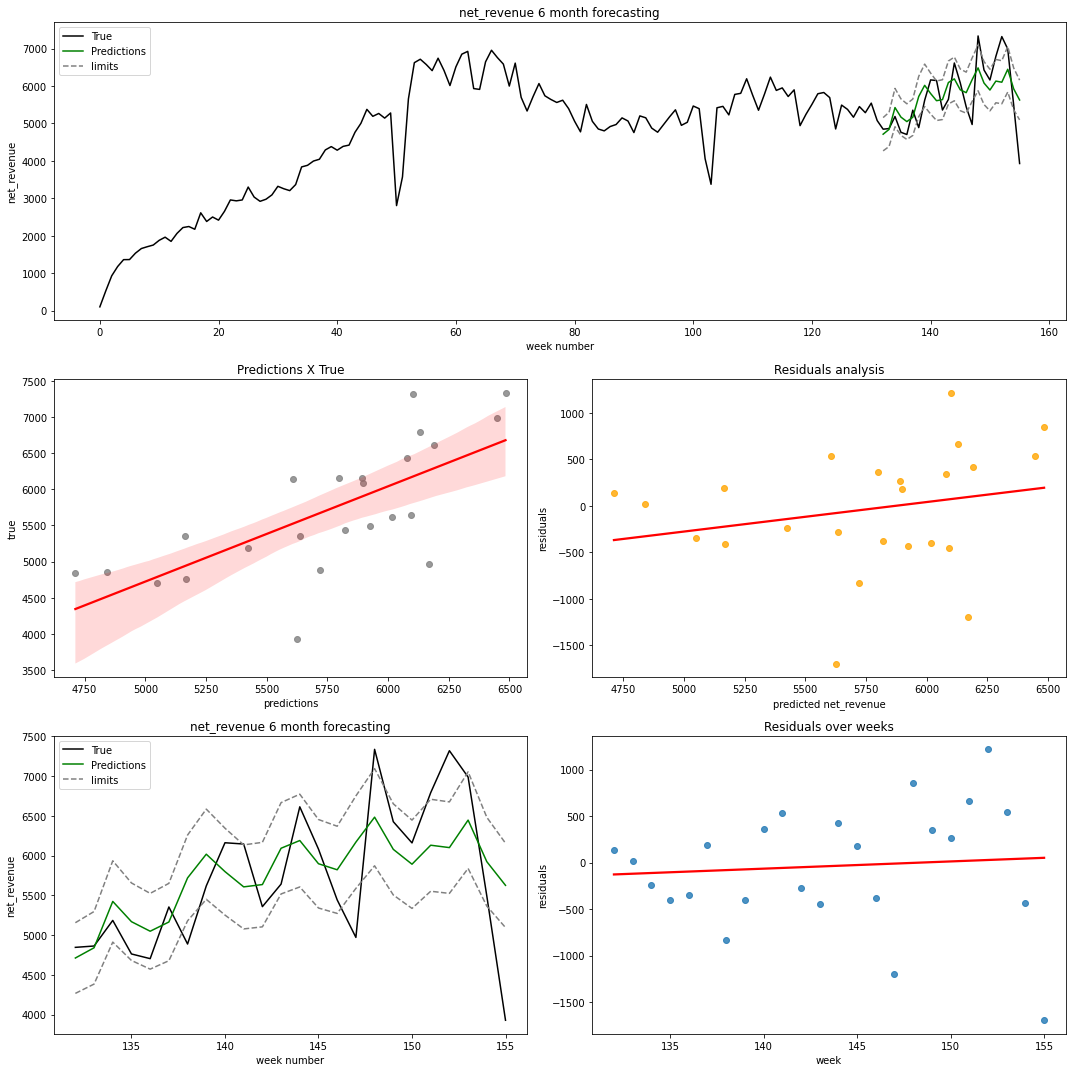

In [286]:
plt.figure(figsize=(15,15))


plt.subplot(3,1,1)
plt.plot(df_grouped['net_revenue'], color='black', label='True')
plt.legend()
plt.plot(df_true_x_predictions['predictions'], color='green', label='Predictions')
plt.legend()
plt.plot(df_true_x_predictions['upper_limit'], color='gray', linestyle='--', label='limits')
plt.legend()
plt.plot(df_true_x_predictions['lower_limit'], color='gray', linestyle='--')
plt.title('net_revenue 6 month forecasting')
plt.xlabel('week number')
plt.ylabel('net_revenue')

plt.subplot(3,2,3)
sns.regplot(x='predictions', y='true', data=df_true_x_predictions,
            scatter_kws={"color": "grey"}, line_kws={"color": "red"})
plt.title('Predictions X True')


plt.subplot(3,2,4)
sns.regplot(x='predictions',y='residuals',data=df_true_x_predictions, ci=False,
            scatter_kws={"color": "orange"}, line_kws={"color": "red"})
plt.xlabel('predicted net_revenue')
plt.title('Residuals analysis')


plt.subplot(3,2,5)
plt.plot(df_true_x_predictions['true'], color='black', label='True')
plt.legend()
plt.plot(df_true_x_predictions['predictions'], color='green', label='Predictions')
plt.legend()
plt.plot(df_true_x_predictions['upper_limit'], color='gray', linestyle='--', label='limits')
plt.legend()
plt.plot(df_true_x_predictions['lower_limit'], color='gray', linestyle='--')
plt.title('net_revenue 6 month forecasting')
plt.xlabel('week number')
plt.ylabel('net_revenue')

plt.subplot(3,2,6)
sns.regplot(x='index',y='residuals',data=df_true_x_predictions.reset_index(), ci=False, line_kws={"color": "red"})
plt.title('Residuals over weeks')
plt.xlabel('week')

plt.tight_layout();

In [278]:
# Correlation between true and predicted values

df_true_x_predictions[['true','predictions']].corr()

,true,predictions
true,1.00000,0.70279
predictions,0.70279,1.00000


In [237]:
r2_score(y_test, y_pred)

0.4632145285702989

## <font color="gray"> 9.1 Main </font>

# 10.0 Deploy

## <font color="gray"> 10.1 Class data_prep.py </font>

## <font color="gray"> 10.2 API_handler.py </font>

## <font color="gray"> 10.3 API tester local </font>

## <font color="gray"> 10.4 API tester remote/cloud </font>

# <font color="green"> Conclusões e pontos de melhora </font>

In [ ]:
# transformar a variável algo

# criar novas features (estação do ano, feriados)



In [ ]:
# não testei o slicing no ARIMA pq dei preferência para a regressão por ser um modelo que alia simplicidade com poder
## adicionar outras varaáveis no futuro, criando "alavancas" para o negócio.

# outra sugestão de melhoria seria testar a rede neural LSTM que é mais adequada para time series, entretanto
## o dataset é pequeno e é bem provável que não retorne bons resultados.

# melhoraria o código substituindo trechos repetidos por funções